In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Concatenate, Dropout, GaussianNoise, LayerNormalization, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

In [16]:
def normalize_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [17]:
(x_train, y_train), (x_test, y_test)  = tf.keras.datasets.fashion_mnist.load_data()

In [18]:
x_train = normalize_tanh(x_train.reshape(-1, 28, 28, 1))

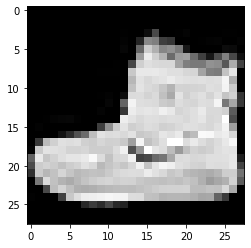

In [19]:
plt.imshow(unnormalize_tanh(normalize_tanh(x_train[0])).reshape(28,28), cmap='gray')

In [20]:
# network parameters
width = 28
height = 28
latent_dim = 100



def build_generator():
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_latent')



    x = Dense(7*7*128)(latent_inputs)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Reshape((7,7,128))(x)


    x = UpSampling2D()(x)
    x = Conv2D(64,3, strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(32,3, strides=1, padding='same')(x)    
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)



    img_outputs = Conv2D(1,5, strides=1, activation='tanh', padding='same')(x)


    return Model(latent_inputs, img_outputs, name='generator')

generator = build_generator()
generator.summary()








Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_latent (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 64)        73

In [21]:
def build_critic():
    inputs = Input(shape=(width,height,1), name='critic_input')
    
    

    
    x = Conv2D(64, 3, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(258, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Flatten()(x)

    valid = Dense(1)(x)



    return Model(inputs, valid, name='critic')
build_critic().summary()

Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
layer_normalization_16 (Laye (None, 14, 14, 64)        128       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
layer_normalization_17 (Laye (None, 7, 7, 128)         256  

In [22]:
generator = build_generator()
critic = build_critic()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
critic_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

In [23]:
@tf.function
def train_step_generator():
    
    batch_size = 64
    latent_dim = 100
    
    with tf.GradientTape() as gen_tape:    
        

        
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=True)       
        

        # gan loss
        fake_output = critic(generated_images, training=False)
        gen_loss = -tf.reduce_mean(fake_output)
   
        generator_loss = gen_loss


    
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss



@tf.function
def train_step_critic(images):
    
    batch_size = 64
    latent_dim = 100
    gp_lambda = 10
    
    with tf.GradientTape() as critic_tape:
        # generate 
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=False)
        
        real_output = critic(images, training=True)
        fake_output = critic(generated_images, training=True)
        
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated_images = generated_images * alpha + images * (1 - alpha)
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_images)
            interpolated_output = critic(interpolated_images, training=True)
        gp_gradients = gp_tape.gradient(interpolated_output, interpolated_images)
        
        # l2 norm on all axis except batch
        gp_gradients_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gp_gradients), axis=[1,2,3]))
        gp = tf.reduce_mean(tf.square(gp_gradients_l2_norm-1))
        
        
        
        loss_real = tf.reduce_mean(real_output)
        loss_fake = tf.reduce_mean(fake_output)
        critic_loss = (loss_fake - loss_real) + gp_lambda * gp 
        
    gradients_of_critic = critic_tape.gradient(critic_loss, critic.trainable_variables)
    
    critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))
    return loss_real, loss_fake
    
        
        
        

Iteration [1/10000]......4.512(s) gen: -0.04867 - critic_fake: -0.04167 - critic_real: -0.42827 - neg_critic: -0.38660
Iteration [2/10000]......0.133(s) gen: 0.06870 - critic_fake: -0.08615 - critic_real: -0.38503 - neg_critic: -0.29887
Iteration [3/10000]......0.128(s) gen: 0.04279 - critic_fake: -0.15656 - critic_real: -0.00545 - neg_critic: 0.15111
Iteration [4/10000]......0.121(s) gen: 0.01981 - critic_fake: -0.10698 - critic_real: 0.22076 - neg_critic: 0.32773
Iteration [5/10000]......0.116(s) gen: 0.02067 - critic_fake: -0.19102 - critic_real: 0.36165 - neg_critic: 0.55267
Iteration [6/10000]......0.114(s) gen: -0.03376 - critic_fake: -0.20207 - critic_real: 0.60751 - neg_critic: 0.80958
Iteration [7/10000]......0.111(s) gen: 0.00829 - critic_fake: -0.22916 - critic_real: 0.62124 - neg_critic: 0.85041
Iteration [8/10000]......0.110(s) gen: -0.06120 - critic_fake: -0.21152 - critic_real: 0.56943 - neg_critic: 0.78095
Iteration [9/10000]......0.109(s) gen: -0.00135 - critic_fake: -

Iteration [71/10000]......0.110(s) gen: -4.32539 - critic_fake: -39.75618 - critic_real: -5.71101 - neg_critic: 34.04518
Iteration [72/10000]......0.112(s) gen: -4.84731 - critic_fake: -40.59058 - critic_real: -6.26897 - neg_critic: 34.32161
Iteration [73/10000]......0.111(s) gen: -4.96358 - critic_fake: -40.09724 - critic_real: -6.71603 - neg_critic: 33.38120
Iteration [74/10000]......0.111(s) gen: -5.33067 - critic_fake: -40.93327 - critic_real: -3.60735 - neg_critic: 37.32592
Iteration [75/10000]......0.110(s) gen: -5.50054 - critic_fake: -42.73398 - critic_real: -5.58271 - neg_critic: 37.15127
Iteration [76/10000]......0.110(s) gen: -6.08223 - critic_fake: -41.57544 - critic_real: -6.79495 - neg_critic: 34.78049
Iteration [77/10000]......0.111(s) gen: -8.13010 - critic_fake: -42.73190 - critic_real: -4.43920 - neg_critic: 38.29270
Iteration [78/10000]......0.110(s) gen: -8.23845 - critic_fake: -43.23796 - critic_real: -4.12336 - neg_critic: 39.11461
Iteration [79/10000]......0.111(

Iteration [139/10000]......0.110(s) gen: -29.57833 - critic_fake: -56.83490 - critic_real: -6.10813 - neg_critic: 50.72677
Iteration [140/10000]......0.111(s) gen: -27.84943 - critic_fake: -56.58681 - critic_real: -7.41986 - neg_critic: 49.16695
Iteration [141/10000]......0.111(s) gen: -27.31412 - critic_fake: -56.20748 - critic_real: -6.42138 - neg_critic: 49.78610
Iteration [142/10000]......0.110(s) gen: -29.18659 - critic_fake: -55.56090 - critic_real: -9.41048 - neg_critic: 46.15042
Iteration [143/10000]......0.111(s) gen: -28.19892 - critic_fake: -56.78191 - critic_real: -7.12692 - neg_critic: 49.65499
Iteration [144/10000]......0.111(s) gen: -28.90989 - critic_fake: -55.18776 - critic_real: -7.59743 - neg_critic: 47.59033
Iteration [145/10000]......0.111(s) gen: -29.46461 - critic_fake: -56.91750 - critic_real: -6.38027 - neg_critic: 50.53722
Iteration [146/10000]......0.110(s) gen: -28.87121 - critic_fake: -56.87387 - critic_real: -7.75106 - neg_critic: 49.12281
Iteration [147/1

Iteration [207/10000]......0.112(s) gen: -39.08636 - critic_fake: -58.92052 - critic_real: -10.57928 - neg_critic: 48.34124
Iteration [208/10000]......0.111(s) gen: -37.82031 - critic_fake: -60.45541 - critic_real: -11.14524 - neg_critic: 49.31017
Iteration [209/10000]......0.111(s) gen: -36.86458 - critic_fake: -59.70414 - critic_real: -8.39862 - neg_critic: 51.30552
Iteration [210/10000]......0.111(s) gen: -39.17258 - critic_fake: -59.60704 - critic_real: -8.30080 - neg_critic: 51.30624
Iteration [211/10000]......0.111(s) gen: -38.03204 - critic_fake: -58.78594 - critic_real: -10.12964 - neg_critic: 48.65630
Iteration [212/10000]......0.111(s) gen: -37.39414 - critic_fake: -59.73664 - critic_real: -10.12244 - neg_critic: 49.61420
Iteration [213/10000]......0.111(s) gen: -37.04636 - critic_fake: -58.88577 - critic_real: -8.93861 - neg_critic: 49.94715
Iteration [214/10000]......0.116(s) gen: -37.95085 - critic_fake: -60.37501 - critic_real: -10.13363 - neg_critic: 50.24138
Iteration [

Iteration [275/10000]......0.115(s) gen: -40.76505 - critic_fake: -61.56136 - critic_real: -9.51711 - neg_critic: 52.04425
Iteration [276/10000]......0.113(s) gen: -40.92787 - critic_fake: -62.12172 - critic_real: -13.51911 - neg_critic: 48.60261
Iteration [277/10000]......0.111(s) gen: -41.38322 - critic_fake: -60.45212 - critic_real: -9.97470 - neg_critic: 50.47743
Iteration [278/10000]......0.111(s) gen: -41.00056 - critic_fake: -61.09646 - critic_real: -10.44496 - neg_critic: 50.65151
Iteration [279/10000]......0.112(s) gen: -41.14742 - critic_fake: -61.42153 - critic_real: -12.03377 - neg_critic: 49.38777
Iteration [280/10000]......0.113(s) gen: -41.19241 - critic_fake: -62.32741 - critic_real: -10.06673 - neg_critic: 52.26067
Iteration [281/10000]......0.110(s) gen: -41.25287 - critic_fake: -61.63773 - critic_real: -9.22333 - neg_critic: 52.41441
Iteration [282/10000]......0.112(s) gen: -41.26667 - critic_fake: -60.27394 - critic_real: -9.96810 - neg_critic: 50.30584
Iteration [2

Iteration [341/10000]......0.112(s) gen: -37.85381 - critic_fake: -52.94891 - critic_real: -16.66751 - neg_critic: 36.28139
Iteration [342/10000]......0.109(s) gen: -37.94702 - critic_fake: -52.28464 - critic_real: -18.15761 - neg_critic: 34.12703
Iteration [343/10000]......0.110(s) gen: -39.21651 - critic_fake: -50.26386 - critic_real: -16.68767 - neg_critic: 33.57619
Iteration [344/10000]......0.111(s) gen: -38.16234 - critic_fake: -51.63060 - critic_real: -18.73834 - neg_critic: 32.89226
Iteration [345/10000]......0.111(s) gen: -38.26636 - critic_fake: -50.91149 - critic_real: -17.70045 - neg_critic: 33.21104
Iteration [346/10000]......0.110(s) gen: -37.76021 - critic_fake: -51.41237 - critic_real: -18.33438 - neg_critic: 33.07799
Iteration [347/10000]......0.110(s) gen: -35.46143 - critic_fake: -50.18497 - critic_real: -19.83342 - neg_critic: 30.35154
Iteration [348/10000]......0.110(s) gen: -36.41845 - critic_fake: -49.58298 - critic_real: -19.71309 - neg_critic: 29.86989
Iteratio

Iteration [409/10000]......0.110(s) gen: 36.17972 - critic_fake: -33.11054 - critic_real: -5.24963 - neg_critic: 27.86091
Iteration [410/10000]......0.110(s) gen: 35.07949 - critic_fake: -32.05576 - critic_real: -5.00467 - neg_critic: 27.05110
Iteration [411/10000]......0.112(s) gen: 34.26172 - critic_fake: -32.77725 - critic_real: -6.18573 - neg_critic: 26.59152
Iteration [412/10000]......0.110(s) gen: 35.27231 - critic_fake: -30.76914 - critic_real: -3.42655 - neg_critic: 27.34259
Iteration [413/10000]......0.110(s) gen: 39.30679 - critic_fake: -32.79700 - critic_real: -4.37907 - neg_critic: 28.41794
Iteration [414/10000]......0.114(s) gen: 37.71604 - critic_fake: -34.68349 - critic_real: -7.21150 - neg_critic: 27.47200
Iteration [415/10000]......0.114(s) gen: 35.51237 - critic_fake: -33.46689 - critic_real: -6.39159 - neg_critic: 27.07530
Iteration [416/10000]......0.112(s) gen: 32.65128 - critic_fake: -33.17616 - critic_real: -6.19737 - neg_critic: 26.97879
Iteration [417/10000]...

Iteration [477/10000]......0.112(s) gen: 42.24523 - critic_fake: -29.83053 - critic_real: -4.27659 - neg_critic: 25.55394
Iteration [478/10000]......0.110(s) gen: 40.66806 - critic_fake: -30.85463 - critic_real: -6.84317 - neg_critic: 24.01146
Iteration [479/10000]......0.112(s) gen: 45.35635 - critic_fake: -32.05313 - critic_real: -5.48678 - neg_critic: 26.56635
Iteration [480/10000]......0.112(s) gen: 37.20699 - critic_fake: -29.57610 - critic_real: -6.46659 - neg_critic: 23.10950
Iteration [481/10000]......0.112(s) gen: 40.56945 - critic_fake: -30.22120 - critic_real: -4.26122 - neg_critic: 25.95999
Iteration [482/10000]......0.111(s) gen: 42.89687 - critic_fake: -29.79541 - critic_real: -5.74055 - neg_critic: 24.05486
Iteration [483/10000]......0.110(s) gen: 37.59355 - critic_fake: -28.91335 - critic_real: -4.78940 - neg_critic: 24.12395
Iteration [484/10000]......0.112(s) gen: 43.52135 - critic_fake: -30.58456 - critic_real: -3.78664 - neg_critic: 26.79792
Iteration [485/10000]...

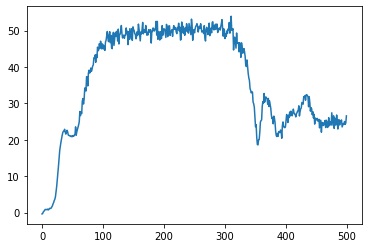

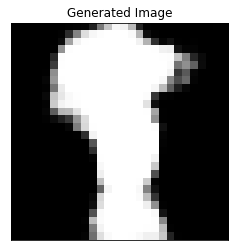

Iteration [501/10000]......0.113(s) gen: 34.87701 - critic_fake: -26.73246 - critic_real: -4.53049 - neg_critic: 22.20197
Iteration [502/10000]......0.112(s) gen: 33.58575 - critic_fake: -27.38887 - critic_real: -5.21648 - neg_critic: 22.17238
Iteration [503/10000]......0.109(s) gen: 38.41226 - critic_fake: -27.84698 - critic_real: -1.86551 - neg_critic: 25.98147
Iteration [504/10000]......0.111(s) gen: 35.74181 - critic_fake: -27.42895 - critic_real: -1.95200 - neg_critic: 25.47695
Iteration [505/10000]......0.112(s) gen: 34.90686 - critic_fake: -26.19245 - critic_real: -1.61132 - neg_critic: 24.58113
Iteration [506/10000]......0.112(s) gen: 32.23909 - critic_fake: -24.93326 - critic_real: -1.82330 - neg_critic: 23.10996
Iteration [507/10000]......0.111(s) gen: 34.07401 - critic_fake: -24.99940 - critic_real: -0.90476 - neg_critic: 24.09464
Iteration [508/10000]......0.111(s) gen: 34.63614 - critic_fake: -25.80259 - critic_real: 0.26911 - neg_critic: 26.07170
Iteration [509/10000]....

Iteration [570/10000]......0.111(s) gen: 11.97323 - critic_fake: -12.33515 - critic_real: 10.73174 - neg_critic: 23.06689
Iteration [571/10000]......0.112(s) gen: 12.52540 - critic_fake: -12.07887 - critic_real: 9.66257 - neg_critic: 21.74144
Iteration [572/10000]......0.116(s) gen: 12.64371 - critic_fake: -12.78576 - critic_real: 9.59265 - neg_critic: 22.37841
Iteration [573/10000]......0.115(s) gen: 13.86458 - critic_fake: -13.74688 - critic_real: 8.54006 - neg_critic: 22.28694
Iteration [574/10000]......0.114(s) gen: 14.72480 - critic_fake: -11.07053 - critic_real: 9.97670 - neg_critic: 21.04723
Iteration [575/10000]......0.111(s) gen: 11.93094 - critic_fake: -15.24357 - critic_real: 6.23409 - neg_critic: 21.47766
Iteration [576/10000]......0.112(s) gen: 15.48461 - critic_fake: -12.46153 - critic_real: 8.49436 - neg_critic: 20.95589
Iteration [577/10000]......0.113(s) gen: 14.22188 - critic_fake: -12.56199 - critic_real: 9.61901 - neg_critic: 22.18100
Iteration [578/10000]......0.11

Iteration [638/10000]......0.113(s) gen: 4.61581 - critic_fake: -8.09274 - critic_real: 10.25323 - neg_critic: 18.34597
Iteration [639/10000]......0.112(s) gen: 4.77343 - critic_fake: -8.41669 - critic_real: 10.16793 - neg_critic: 18.58462
Iteration [640/10000]......0.111(s) gen: 3.82147 - critic_fake: -7.72368 - critic_real: 9.98643 - neg_critic: 17.71012
Iteration [641/10000]......0.111(s) gen: 5.51377 - critic_fake: -9.15149 - critic_real: 9.87943 - neg_critic: 19.03092
Iteration [642/10000]......0.112(s) gen: 2.35394 - critic_fake: -6.82643 - critic_real: 11.70992 - neg_critic: 18.53635
Iteration [643/10000]......0.112(s) gen: 4.05208 - critic_fake: -6.76294 - critic_real: 11.03493 - neg_critic: 17.79787
Iteration [644/10000]......0.112(s) gen: 5.85261 - critic_fake: -8.62940 - critic_real: 11.15130 - neg_critic: 19.78070
Iteration [645/10000]......0.112(s) gen: 4.23761 - critic_fake: -7.67389 - critic_real: 9.39810 - neg_critic: 17.07199
Iteration [646/10000]......0.111(s) gen: 1.

Iteration [708/10000]......0.111(s) gen: 4.67052 - critic_fake: -8.12641 - critic_real: 6.96585 - neg_critic: 15.09226
Iteration [709/10000]......0.111(s) gen: 6.81954 - critic_fake: -7.35814 - critic_real: 9.37711 - neg_critic: 16.73525
Iteration [710/10000]......0.112(s) gen: 6.78876 - critic_fake: -7.83727 - critic_real: 7.38523 - neg_critic: 15.22249
Iteration [711/10000]......0.111(s) gen: 6.49169 - critic_fake: -7.54196 - critic_real: 8.14897 - neg_critic: 15.69093
Iteration [712/10000]......0.113(s) gen: 5.39314 - critic_fake: -5.13525 - critic_real: 9.67845 - neg_critic: 14.81370
Iteration [713/10000]......0.110(s) gen: 7.18317 - critic_fake: -6.69458 - critic_real: 8.95666 - neg_critic: 15.65124
Iteration [714/10000]......0.112(s) gen: 7.10051 - critic_fake: -7.81871 - critic_real: 7.49508 - neg_critic: 15.31380
Iteration [715/10000]......0.113(s) gen: 8.60269 - critic_fake: -8.68789 - critic_real: 7.70698 - neg_critic: 16.39487
Iteration [716/10000]......0.112(s) gen: 8.16645

Iteration [778/10000]......0.117(s) gen: 4.61664 - critic_fake: -6.24215 - critic_real: 7.37560 - neg_critic: 13.61775
Iteration [779/10000]......0.115(s) gen: 5.79575 - critic_fake: -5.56423 - critic_real: 8.22901 - neg_critic: 13.79324
Iteration [780/10000]......0.116(s) gen: 6.14190 - critic_fake: -7.84543 - critic_real: 7.61683 - neg_critic: 15.46226
Iteration [781/10000]......0.118(s) gen: 3.97320 - critic_fake: -5.71704 - critic_real: 8.02219 - neg_critic: 13.73923
Iteration [782/10000]......0.114(s) gen: 3.47486 - critic_fake: -6.00817 - critic_real: 7.34499 - neg_critic: 13.35316
Iteration [783/10000]......0.116(s) gen: 5.13219 - critic_fake: -4.81427 - critic_real: 9.55534 - neg_critic: 14.36961
Iteration [784/10000]......0.116(s) gen: 5.01041 - critic_fake: -5.23365 - critic_real: 8.28576 - neg_critic: 13.51941
Iteration [785/10000]......0.112(s) gen: 5.26848 - critic_fake: -5.92576 - critic_real: 7.61763 - neg_critic: 13.54339
Iteration [786/10000]......0.115(s) gen: 5.42529

Iteration [848/10000]......0.114(s) gen: 4.10166 - critic_fake: -3.46014 - critic_real: 9.19062 - neg_critic: 12.65076
Iteration [849/10000]......0.116(s) gen: 3.92351 - critic_fake: -3.61004 - critic_real: 9.87124 - neg_critic: 13.48127
Iteration [850/10000]......0.117(s) gen: 4.53073 - critic_fake: -4.21868 - critic_real: 8.80730 - neg_critic: 13.02599
Iteration [851/10000]......0.116(s) gen: 3.81054 - critic_fake: -4.18650 - critic_real: 8.99006 - neg_critic: 13.17656
Iteration [852/10000]......0.118(s) gen: 6.22636 - critic_fake: -4.34612 - critic_real: 8.23061 - neg_critic: 12.57673
Iteration [853/10000]......0.116(s) gen: 3.16196 - critic_fake: -6.23392 - critic_real: 7.57271 - neg_critic: 13.80663
Iteration [854/10000]......0.115(s) gen: 5.20065 - critic_fake: -3.86692 - critic_real: 8.83606 - neg_critic: 12.70298
Iteration [855/10000]......0.116(s) gen: 3.13535 - critic_fake: -3.63095 - critic_real: 8.95645 - neg_critic: 12.58741
Iteration [856/10000]......0.116(s) gen: 6.04606

Iteration [918/10000]......0.114(s) gen: 3.23160 - critic_fake: -3.31964 - critic_real: 9.05054 - neg_critic: 12.37018
Iteration [919/10000]......0.113(s) gen: 4.03708 - critic_fake: -3.95992 - critic_real: 8.89193 - neg_critic: 12.85186
Iteration [920/10000]......0.114(s) gen: 3.33046 - critic_fake: -4.02322 - critic_real: 9.33459 - neg_critic: 13.35781
Iteration [921/10000]......0.114(s) gen: 2.70824 - critic_fake: -3.18634 - critic_real: 8.65883 - neg_critic: 11.84518
Iteration [922/10000]......0.113(s) gen: 4.04173 - critic_fake: -2.74719 - critic_real: 9.13520 - neg_critic: 11.88239
Iteration [923/10000]......0.114(s) gen: 3.46675 - critic_fake: -3.34207 - critic_real: 8.84487 - neg_critic: 12.18693
Iteration [924/10000]......0.116(s) gen: 2.59200 - critic_fake: -3.17760 - critic_real: 9.46899 - neg_critic: 12.64659
Iteration [925/10000]......0.115(s) gen: 2.97303 - critic_fake: -2.45126 - critic_real: 9.69131 - neg_critic: 12.14257
Iteration [926/10000]......0.115(s) gen: 2.09598

Iteration [988/10000]......0.113(s) gen: 2.58766 - critic_fake: -2.67128 - critic_real: 9.79356 - neg_critic: 12.46484
Iteration [989/10000]......0.114(s) gen: 3.62508 - critic_fake: -3.56571 - critic_real: 9.22590 - neg_critic: 12.79161
Iteration [990/10000]......0.113(s) gen: 2.27762 - critic_fake: -3.15611 - critic_real: 9.41274 - neg_critic: 12.56885
Iteration [991/10000]......0.111(s) gen: 1.63971 - critic_fake: -2.27237 - critic_real: 10.44611 - neg_critic: 12.71848
Iteration [992/10000]......0.114(s) gen: 5.09066 - critic_fake: -2.78601 - critic_real: 9.38039 - neg_critic: 12.16640
Iteration [993/10000]......0.116(s) gen: 4.08904 - critic_fake: -4.22610 - critic_real: 8.25843 - neg_critic: 12.48453
Iteration [994/10000]......0.115(s) gen: 2.96890 - critic_fake: -3.47657 - critic_real: 8.87089 - neg_critic: 12.34747
Iteration [995/10000]......0.116(s) gen: 3.27925 - critic_fake: -3.39092 - critic_real: 9.53898 - neg_critic: 12.92990
Iteration [996/10000]......0.117(s) gen: 3.5123

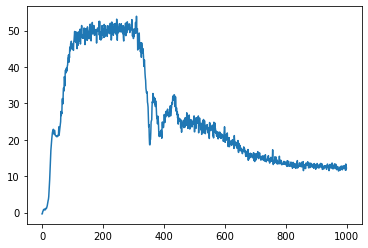

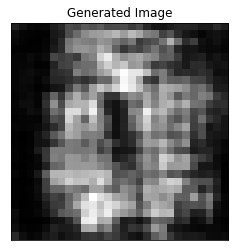

Iteration [1001/10000]......0.117(s) gen: 3.93512 - critic_fake: -2.43514 - critic_real: 9.50428 - neg_critic: 11.93942
Iteration [1002/10000]......0.113(s) gen: 2.25001 - critic_fake: -2.35459 - critic_real: 10.51665 - neg_critic: 12.87125
Iteration [1003/10000]......0.114(s) gen: 2.35020 - critic_fake: -2.27827 - critic_real: 9.64146 - neg_critic: 11.91973
Iteration [1004/10000]......0.114(s) gen: 3.91831 - critic_fake: -2.96623 - critic_real: 9.68322 - neg_critic: 12.64945
Iteration [1005/10000]......0.114(s) gen: 3.69869 - critic_fake: -3.47843 - critic_real: 8.44849 - neg_critic: 11.92692
Iteration [1006/10000]......0.113(s) gen: 1.92054 - critic_fake: -2.86807 - critic_real: 9.65136 - neg_critic: 12.51943
Iteration [1007/10000]......0.114(s) gen: 2.76819 - critic_fake: -2.49059 - critic_real: 10.05856 - neg_critic: 12.54915
Iteration [1008/10000]......0.113(s) gen: 2.14721 - critic_fake: -3.10491 - critic_real: 10.16014 - neg_critic: 13.26505
Iteration [1009/10000]......0.114(s) 

Iteration [1070/10000]......0.115(s) gen: 3.73094 - critic_fake: -2.56368 - critic_real: 9.42921 - neg_critic: 11.99289
Iteration [1071/10000]......0.115(s) gen: 3.22672 - critic_fake: -2.73420 - critic_real: 8.89936 - neg_critic: 11.63356
Iteration [1072/10000]......0.115(s) gen: 3.22921 - critic_fake: -2.19004 - critic_real: 9.38303 - neg_critic: 11.57307
Iteration [1073/10000]......0.115(s) gen: 3.22298 - critic_fake: -3.28381 - critic_real: 8.28644 - neg_critic: 11.57025
Iteration [1074/10000]......0.115(s) gen: 2.25751 - critic_fake: -3.38379 - critic_real: 9.01709 - neg_critic: 12.40088
Iteration [1075/10000]......0.115(s) gen: 0.27884 - critic_fake: -1.27907 - critic_real: 10.66867 - neg_critic: 11.94774
Iteration [1076/10000]......0.115(s) gen: 1.96888 - critic_fake: -1.65731 - critic_real: 9.72971 - neg_critic: 11.38703
Iteration [1077/10000]......0.115(s) gen: 2.87949 - critic_fake: -1.98049 - critic_real: 9.23047 - neg_critic: 11.21097
Iteration [1078/10000]......0.115(s) ge

Iteration [1139/10000]......0.115(s) gen: 2.43239 - critic_fake: -2.20516 - critic_real: 8.65018 - neg_critic: 10.85534
Iteration [1140/10000]......0.115(s) gen: 2.31172 - critic_fake: -2.38910 - critic_real: 9.46246 - neg_critic: 11.85156
Iteration [1141/10000]......0.119(s) gen: 3.21208 - critic_fake: -2.24505 - critic_real: 9.43826 - neg_critic: 11.68332
Iteration [1142/10000]......0.117(s) gen: 2.06121 - critic_fake: -1.78344 - critic_real: 9.94873 - neg_critic: 11.73217
Iteration [1143/10000]......0.114(s) gen: 2.23526 - critic_fake: -2.50115 - critic_real: 9.05911 - neg_critic: 11.56026
Iteration [1144/10000]......0.114(s) gen: 2.30907 - critic_fake: -2.47867 - critic_real: 9.05989 - neg_critic: 11.53856
Iteration [1145/10000]......0.115(s) gen: 2.75014 - critic_fake: -1.91751 - critic_real: 9.83792 - neg_critic: 11.75544
Iteration [1146/10000]......0.116(s) gen: 2.64730 - critic_fake: -2.54721 - critic_real: 9.16487 - neg_critic: 11.71209
Iteration [1147/10000]......0.118(s) gen

Iteration [1208/10000]......0.118(s) gen: 1.46625 - critic_fake: -1.75844 - critic_real: 9.50507 - neg_critic: 11.26351
Iteration [1209/10000]......0.115(s) gen: 2.58254 - critic_fake: -2.17777 - critic_real: 9.61899 - neg_critic: 11.79676
Iteration [1210/10000]......0.116(s) gen: 2.13953 - critic_fake: -1.47112 - critic_real: 9.29011 - neg_critic: 10.76123
Iteration [1211/10000]......0.120(s) gen: 2.58680 - critic_fake: -2.04391 - critic_real: 8.58519 - neg_critic: 10.62911
Iteration [1212/10000]......0.118(s) gen: 3.90319 - critic_fake: -2.54127 - critic_real: 8.77529 - neg_critic: 11.31656
Iteration [1213/10000]......0.118(s) gen: 2.79198 - critic_fake: -3.75743 - critic_real: 7.93277 - neg_critic: 11.69020
Iteration [1214/10000]......0.116(s) gen: 1.91794 - critic_fake: -2.32800 - critic_real: 8.20000 - neg_critic: 10.52800
Iteration [1215/10000]......0.116(s) gen: 2.48537 - critic_fake: -2.08260 - critic_real: 9.09557 - neg_critic: 11.17818
Iteration [1216/10000]......0.120(s) gen

Iteration [1277/10000]......0.114(s) gen: 1.53462 - critic_fake: -2.07666 - critic_real: 9.08629 - neg_critic: 11.16294
Iteration [1278/10000]......0.115(s) gen: 2.48384 - critic_fake: -1.30835 - critic_real: 9.59836 - neg_critic: 10.90670
Iteration [1279/10000]......0.116(s) gen: 1.77844 - critic_fake: -2.05122 - critic_real: 9.56427 - neg_critic: 11.61550
Iteration [1280/10000]......0.117(s) gen: 2.93678 - critic_fake: -2.20581 - critic_real: 9.88712 - neg_critic: 12.09293
Iteration [1281/10000]......0.116(s) gen: 0.68696 - critic_fake: -2.16178 - critic_real: 9.29710 - neg_critic: 11.45888
Iteration [1282/10000]......0.116(s) gen: 2.73334 - critic_fake: -1.86706 - critic_real: 9.36464 - neg_critic: 11.23170
Iteration [1283/10000]......0.117(s) gen: 1.97804 - critic_fake: -3.21015 - critic_real: 8.36134 - neg_critic: 11.57149
Iteration [1284/10000]......0.117(s) gen: 1.77183 - critic_fake: -1.66689 - critic_real: 9.42165 - neg_critic: 11.08854
Iteration [1285/10000]......0.117(s) gen

Iteration [1346/10000]......0.116(s) gen: 2.25523 - critic_fake: -1.51576 - critic_real: 10.12113 - neg_critic: 11.63688
Iteration [1347/10000]......0.115(s) gen: 1.99377 - critic_fake: -1.88561 - critic_real: 8.85330 - neg_critic: 10.73891
Iteration [1348/10000]......0.116(s) gen: 2.92228 - critic_fake: -2.26395 - critic_real: 8.62264 - neg_critic: 10.88659
Iteration [1349/10000]......0.116(s) gen: 2.49561 - critic_fake: -1.79806 - critic_real: 8.83434 - neg_critic: 10.63240
Iteration [1350/10000]......0.114(s) gen: 2.44959 - critic_fake: -1.59355 - critic_real: 9.34946 - neg_critic: 10.94301
Iteration [1351/10000]......0.115(s) gen: 0.73535 - critic_fake: -1.13913 - critic_real: 9.54076 - neg_critic: 10.67989
Iteration [1352/10000]......0.115(s) gen: 2.19098 - critic_fake: -1.99873 - critic_real: 9.37863 - neg_critic: 11.37736
Iteration [1353/10000]......0.114(s) gen: 3.71962 - critic_fake: -2.30314 - critic_real: 9.69728 - neg_critic: 12.00042
Iteration [1354/10000]......0.114(s) ge

Iteration [1415/10000]......0.115(s) gen: 1.65973 - critic_fake: -1.25161 - critic_real: 9.38105 - neg_critic: 10.63266
Iteration [1416/10000]......0.113(s) gen: 2.74956 - critic_fake: -1.93297 - critic_real: 9.29663 - neg_critic: 11.22960
Iteration [1417/10000]......0.114(s) gen: 2.44026 - critic_fake: -3.05576 - critic_real: 7.89677 - neg_critic: 10.95254
Iteration [1418/10000]......0.114(s) gen: 2.49292 - critic_fake: -2.11573 - critic_real: 8.92307 - neg_critic: 11.03880
Iteration [1419/10000]......0.114(s) gen: 2.26989 - critic_fake: -2.66443 - critic_real: 8.09331 - neg_critic: 10.75774
Iteration [1420/10000]......0.113(s) gen: 1.85606 - critic_fake: -2.05800 - critic_real: 8.68589 - neg_critic: 10.74389
Iteration [1421/10000]......0.114(s) gen: 2.41977 - critic_fake: -1.76571 - critic_real: 8.85568 - neg_critic: 10.62138
Iteration [1422/10000]......0.113(s) gen: 2.38827 - critic_fake: -2.51824 - critic_real: 8.04301 - neg_critic: 10.56125
Iteration [1423/10000]......0.114(s) gen

Iteration [1484/10000]......0.121(s) gen: 1.48298 - critic_fake: -1.89331 - critic_real: 8.59499 - neg_critic: 10.48830
Iteration [1485/10000]......0.117(s) gen: 2.94791 - critic_fake: -1.86010 - critic_real: 8.78574 - neg_critic: 10.64584
Iteration [1486/10000]......0.117(s) gen: 2.09961 - critic_fake: -2.12229 - critic_real: 8.38977 - neg_critic: 10.51206
Iteration [1487/10000]......0.121(s) gen: 2.84683 - critic_fake: -1.91698 - critic_real: 8.62287 - neg_critic: 10.53985
Iteration [1488/10000]......0.120(s) gen: 1.25379 - critic_fake: -2.43005 - critic_real: 8.02095 - neg_critic: 10.45100
Iteration [1489/10000]......0.118(s) gen: 2.17836 - critic_fake: -1.16410 - critic_real: 8.95066 - neg_critic: 10.11476
Iteration [1490/10000]......0.117(s) gen: 2.15090 - critic_fake: -1.64623 - critic_real: 7.90785 - neg_critic: 9.55408
Iteration [1491/10000]......0.119(s) gen: 1.52572 - critic_fake: -1.69741 - critic_real: 8.38259 - neg_critic: 10.07999
Iteration [1492/10000]......0.119(s) gen:

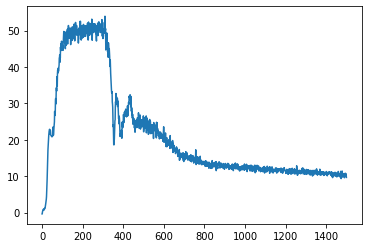

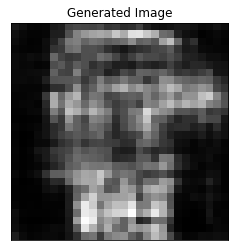

Iteration [1501/10000]......0.117(s) gen: 1.59860 - critic_fake: -1.65854 - critic_real: 8.33790 - neg_critic: 9.99644
Iteration [1502/10000]......0.117(s) gen: 2.53095 - critic_fake: -1.96648 - critic_real: 8.71499 - neg_critic: 10.68147
Iteration [1503/10000]......0.112(s) gen: 2.23145 - critic_fake: -1.92207 - critic_real: 7.72288 - neg_critic: 9.64496
Iteration [1504/10000]......0.112(s) gen: 1.25563 - critic_fake: -1.44459 - critic_real: 9.29552 - neg_critic: 10.74011
Iteration [1505/10000]......0.113(s) gen: 1.08938 - critic_fake: -1.77790 - critic_real: 8.06678 - neg_critic: 9.84468
Iteration [1506/10000]......0.113(s) gen: 0.99430 - critic_fake: -0.56101 - critic_real: 10.37371 - neg_critic: 10.93471
Iteration [1507/10000]......0.116(s) gen: 0.60134 - critic_fake: -0.95080 - critic_real: 8.42486 - neg_critic: 9.37565
Iteration [1508/10000]......0.111(s) gen: 2.68659 - critic_fake: -1.64644 - critic_real: 8.77175 - neg_critic: 10.41819
Iteration [1509/10000]......0.115(s) gen: 2

Iteration [1570/10000]......0.116(s) gen: 1.15118 - critic_fake: -0.86544 - critic_real: 8.93634 - neg_critic: 9.80179
Iteration [1571/10000]......0.115(s) gen: 1.65187 - critic_fake: -0.86285 - critic_real: 9.43932 - neg_critic: 10.30216
Iteration [1572/10000]......0.115(s) gen: 1.99368 - critic_fake: -0.77899 - critic_real: 9.44372 - neg_critic: 10.22270
Iteration [1573/10000]......0.115(s) gen: 1.50965 - critic_fake: -1.29955 - critic_real: 8.16345 - neg_critic: 9.46300
Iteration [1574/10000]......0.114(s) gen: 0.81531 - critic_fake: -0.85980 - critic_real: 9.04590 - neg_critic: 9.90570
Iteration [1575/10000]......0.117(s) gen: 2.73675 - critic_fake: -1.43024 - critic_real: 8.46003 - neg_critic: 9.89027
Iteration [1576/10000]......0.117(s) gen: 1.32311 - critic_fake: -2.36142 - critic_real: 7.79620 - neg_critic: 10.15761
Iteration [1577/10000]......0.115(s) gen: 2.59554 - critic_fake: -1.07714 - critic_real: 8.94815 - neg_critic: 10.02529
Iteration [1578/10000]......0.114(s) gen: 1.

Iteration [1639/10000]......0.119(s) gen: 1.32697 - critic_fake: -1.95315 - critic_real: 7.84927 - neg_critic: 9.80241
Iteration [1640/10000]......0.121(s) gen: 2.14932 - critic_fake: -1.36339 - critic_real: 8.91208 - neg_critic: 10.27547
Iteration [1641/10000]......0.121(s) gen: 1.07630 - critic_fake: -1.21942 - critic_real: 8.33279 - neg_critic: 9.55221
Iteration [1642/10000]......0.118(s) gen: 1.16264 - critic_fake: -0.41420 - critic_real: 9.11638 - neg_critic: 9.53058
Iteration [1643/10000]......0.120(s) gen: 1.63766 - critic_fake: -0.84763 - critic_real: 8.64413 - neg_critic: 9.49176
Iteration [1644/10000]......0.125(s) gen: 2.85417 - critic_fake: -1.53551 - critic_real: 8.02380 - neg_critic: 9.55931
Iteration [1645/10000]......0.118(s) gen: 2.13362 - critic_fake: -1.83404 - critic_real: 7.91481 - neg_critic: 9.74885
Iteration [1646/10000]......0.116(s) gen: 0.74464 - critic_fake: -0.78958 - critic_real: 8.93416 - neg_critic: 9.72374
Iteration [1647/10000]......0.115(s) gen: 1.884

Iteration [1708/10000]......0.120(s) gen: 1.49298 - critic_fake: -0.82667 - critic_real: 8.57527 - neg_critic: 9.40193
Iteration [1709/10000]......0.117(s) gen: 0.75264 - critic_fake: -0.73645 - critic_real: 9.01883 - neg_critic: 9.75527
Iteration [1710/10000]......0.117(s) gen: 1.62293 - critic_fake: -0.03990 - critic_real: 9.06242 - neg_critic: 9.10233
Iteration [1711/10000]......0.117(s) gen: 0.94950 - critic_fake: -1.14153 - critic_real: 8.33939 - neg_critic: 9.48093
Iteration [1712/10000]......0.118(s) gen: 1.43732 - critic_fake: -1.05597 - critic_real: 8.66041 - neg_critic: 9.71638
Iteration [1713/10000]......0.117(s) gen: 1.37454 - critic_fake: -1.19169 - critic_real: 8.25909 - neg_critic: 9.45078
Iteration [1714/10000]......0.117(s) gen: 0.17351 - critic_fake: -0.23437 - critic_real: 8.91201 - neg_critic: 9.14638
Iteration [1715/10000]......0.117(s) gen: 1.55636 - critic_fake: -0.52270 - critic_real: 8.48152 - neg_critic: 9.00422
Iteration [1716/10000]......0.116(s) gen: 0.6662

Iteration [1777/10000]......0.116(s) gen: -0.01532 - critic_fake: -0.90740 - critic_real: 7.80484 - neg_critic: 8.71224
Iteration [1778/10000]......0.118(s) gen: 0.34874 - critic_fake: -0.31594 - critic_real: 8.96015 - neg_critic: 9.27609
Iteration [1779/10000]......0.116(s) gen: 0.42330 - critic_fake: -0.16514 - critic_real: 9.08926 - neg_critic: 9.25440
Iteration [1780/10000]......0.115(s) gen: 1.26230 - critic_fake: -0.89479 - critic_real: 8.69265 - neg_critic: 9.58745
Iteration [1781/10000]......0.115(s) gen: 1.01894 - critic_fake: -0.91924 - critic_real: 8.50700 - neg_critic: 9.42624
Iteration [1782/10000]......0.117(s) gen: 1.31535 - critic_fake: -1.16990 - critic_real: 7.58673 - neg_critic: 8.75664
Iteration [1783/10000]......0.118(s) gen: 0.79134 - critic_fake: -1.14238 - critic_real: 7.57053 - neg_critic: 8.71291
Iteration [1784/10000]......0.117(s) gen: -0.26885 - critic_fake: -0.65030 - critic_real: 8.78759 - neg_critic: 9.43789
Iteration [1785/10000]......0.117(s) gen: 0.56

Iteration [1846/10000]......0.118(s) gen: 0.13035 - critic_fake: -0.76704 - critic_real: 8.47026 - neg_critic: 9.23730
Iteration [1847/10000]......0.116(s) gen: 0.81411 - critic_fake: -0.46606 - critic_real: 8.66156 - neg_critic: 9.12762
Iteration [1848/10000]......0.116(s) gen: 0.02165 - critic_fake: -0.96536 - critic_real: 8.20339 - neg_critic: 9.16874
Iteration [1849/10000]......0.116(s) gen: 0.83901 - critic_fake: -0.62081 - critic_real: 7.65534 - neg_critic: 8.27615
Iteration [1850/10000]......0.119(s) gen: 0.09221 - critic_fake: -0.37975 - critic_real: 8.17600 - neg_critic: 8.55576
Iteration [1851/10000]......0.120(s) gen: 0.96388 - critic_fake: -0.61842 - critic_real: 7.96988 - neg_critic: 8.58830
Iteration [1852/10000]......0.116(s) gen: 1.08252 - critic_fake: -1.57996 - critic_real: 7.04011 - neg_critic: 8.62007
Iteration [1853/10000]......0.116(s) gen: 1.22962 - critic_fake: -1.33095 - critic_real: 7.52832 - neg_critic: 8.85926
Iteration [1854/10000]......0.123(s) gen: 2.3141

Iteration [1915/10000]......0.117(s) gen: -0.47577 - critic_fake: -1.10507 - critic_real: 7.35561 - neg_critic: 8.46068
Iteration [1916/10000]......0.117(s) gen: 0.81612 - critic_fake: -0.22159 - critic_real: 8.01482 - neg_critic: 8.23641
Iteration [1917/10000]......0.115(s) gen: 1.45115 - critic_fake: -0.83710 - critic_real: 7.60185 - neg_critic: 8.43894
Iteration [1918/10000]......0.116(s) gen: 0.44448 - critic_fake: -0.12631 - critic_real: 8.18762 - neg_critic: 8.31393
Iteration [1919/10000]......0.115(s) gen: 0.90633 - critic_fake: -1.00228 - critic_real: 7.66879 - neg_critic: 8.67107
Iteration [1920/10000]......0.116(s) gen: 1.11960 - critic_fake: -1.68069 - critic_real: 7.38667 - neg_critic: 9.06736
Iteration [1921/10000]......0.117(s) gen: 1.63346 - critic_fake: -1.19044 - critic_real: 7.90975 - neg_critic: 9.10019
Iteration [1922/10000]......0.117(s) gen: 1.09622 - critic_fake: -1.05932 - critic_real: 7.29185 - neg_critic: 8.35117
Iteration [1923/10000]......0.115(s) gen: 1.921

Iteration [1984/10000]......0.123(s) gen: 1.12743 - critic_fake: -0.63283 - critic_real: 8.19073 - neg_critic: 8.82356
Iteration [1985/10000]......0.119(s) gen: 1.13845 - critic_fake: -1.08076 - critic_real: 7.75461 - neg_critic: 8.83536
Iteration [1986/10000]......0.117(s) gen: 1.64562 - critic_fake: -0.58340 - critic_real: 7.92174 - neg_critic: 8.50514
Iteration [1987/10000]......0.116(s) gen: 0.87238 - critic_fake: -1.47633 - critic_real: 6.96991 - neg_critic: 8.44624
Iteration [1988/10000]......0.116(s) gen: 1.87116 - critic_fake: -1.61552 - critic_real: 6.74290 - neg_critic: 8.35842
Iteration [1989/10000]......0.116(s) gen: 1.01506 - critic_fake: -1.41632 - critic_real: 7.20267 - neg_critic: 8.61899
Iteration [1990/10000]......0.119(s) gen: 1.40141 - critic_fake: -1.20693 - critic_real: 7.67579 - neg_critic: 8.88271
Iteration [1991/10000]......0.118(s) gen: 0.21790 - critic_fake: -1.06257 - critic_real: 7.68383 - neg_critic: 8.74640
Iteration [1992/10000]......0.116(s) gen: 0.4905

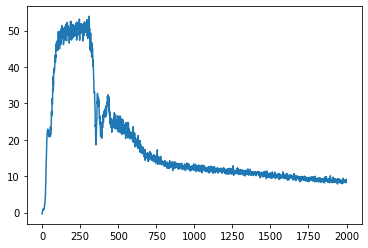

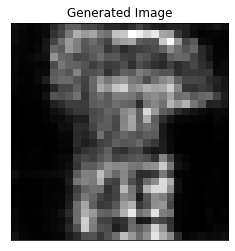

Iteration [2001/10000]......0.120(s) gen: 0.70564 - critic_fake: -0.62131 - critic_real: 8.06741 - neg_critic: 8.68872
Iteration [2002/10000]......0.122(s) gen: 0.38557 - critic_fake: -0.75727 - critic_real: 7.64726 - neg_critic: 8.40453
Iteration [2003/10000]......0.130(s) gen: 0.27183 - critic_fake: -0.69848 - critic_real: 7.63645 - neg_critic: 8.33493
Iteration [2004/10000]......0.131(s) gen: 0.46606 - critic_fake: -0.56624 - critic_real: 8.16418 - neg_critic: 8.73042
Iteration [2005/10000]......0.137(s) gen: -0.09025 - critic_fake: -0.60184 - critic_real: 7.40791 - neg_critic: 8.00975
Iteration [2006/10000]......0.145(s) gen: 1.26685 - critic_fake: -0.21237 - critic_real: 8.53892 - neg_critic: 8.75129
Iteration [2007/10000]......0.142(s) gen: 0.28722 - critic_fake: -0.46254 - critic_real: 7.63341 - neg_critic: 8.09595
Iteration [2008/10000]......0.129(s) gen: -0.37569 - critic_fake: -1.04527 - critic_real: 7.87912 - neg_critic: 8.92439
Iteration [2009/10000]......0.132(s) gen: 0.37

Iteration [2070/10000]......0.117(s) gen: 1.47656 - critic_fake: -0.79535 - critic_real: 7.83421 - neg_critic: 8.62956
Iteration [2071/10000]......0.114(s) gen: 0.60945 - critic_fake: -0.67906 - critic_real: 7.43093 - neg_critic: 8.10999
Iteration [2072/10000]......0.115(s) gen: 0.99243 - critic_fake: -0.87474 - critic_real: 7.52695 - neg_critic: 8.40169
Iteration [2073/10000]......0.115(s) gen: 1.23963 - critic_fake: -0.67053 - critic_real: 7.56341 - neg_critic: 8.23394
Iteration [2074/10000]......0.117(s) gen: 1.39528 - critic_fake: -1.47657 - critic_real: 6.91457 - neg_critic: 8.39114
Iteration [2075/10000]......0.116(s) gen: 1.68810 - critic_fake: -1.03006 - critic_real: 6.68206 - neg_critic: 7.71212
Iteration [2076/10000]......0.116(s) gen: 1.10460 - critic_fake: -1.25516 - critic_real: 7.46272 - neg_critic: 8.71789
Iteration [2077/10000]......0.115(s) gen: 0.85034 - critic_fake: -0.73090 - critic_real: 7.81076 - neg_critic: 8.54166
Iteration [2078/10000]......0.115(s) gen: 0.0494

Iteration [2140/10000]......0.119(s) gen: 0.87768 - critic_fake: -0.97116 - critic_real: 6.88879 - neg_critic: 7.85994
Iteration [2141/10000]......0.117(s) gen: 1.51723 - critic_fake: -1.11044 - critic_real: 7.22183 - neg_critic: 8.33227
Iteration [2142/10000]......0.116(s) gen: 0.84324 - critic_fake: -1.08882 - critic_real: 6.99157 - neg_critic: 8.08039
Iteration [2143/10000]......0.119(s) gen: 1.86814 - critic_fake: -0.81146 - critic_real: 7.08558 - neg_critic: 7.89704
Iteration [2144/10000]......0.119(s) gen: 1.16245 - critic_fake: -1.25926 - critic_real: 6.78626 - neg_critic: 8.04551
Iteration [2145/10000]......0.123(s) gen: 0.99355 - critic_fake: -0.94022 - critic_real: 7.08071 - neg_critic: 8.02093
Iteration [2146/10000]......0.117(s) gen: 2.04001 - critic_fake: -1.09247 - critic_real: 7.36521 - neg_critic: 8.45768
Iteration [2147/10000]......0.116(s) gen: 1.33971 - critic_fake: -1.19353 - critic_real: 7.54867 - neg_critic: 8.74220
Iteration [2148/10000]......0.116(s) gen: 1.1034

Iteration [2210/10000]......0.116(s) gen: 0.86177 - critic_fake: -0.45798 - critic_real: 6.75603 - neg_critic: 7.21401
Iteration [2211/10000]......0.117(s) gen: 1.45685 - critic_fake: -0.89740 - critic_real: 7.30093 - neg_critic: 8.19833
Iteration [2212/10000]......0.119(s) gen: 0.78271 - critic_fake: -0.21005 - critic_real: 7.04836 - neg_critic: 7.25840
Iteration [2213/10000]......0.119(s) gen: 1.52458 - critic_fake: -1.52848 - critic_real: 6.61909 - neg_critic: 8.14757
Iteration [2214/10000]......0.116(s) gen: 0.25180 - critic_fake: -1.03278 - critic_real: 6.55631 - neg_critic: 7.58909
Iteration [2215/10000]......0.123(s) gen: 1.08171 - critic_fake: -1.24478 - critic_real: 7.19264 - neg_critic: 8.43742
Iteration [2216/10000]......0.116(s) gen: 1.03656 - critic_fake: -1.18187 - critic_real: 7.10779 - neg_critic: 8.28966
Iteration [2217/10000]......0.115(s) gen: 2.21537 - critic_fake: -1.32145 - critic_real: 6.62815 - neg_critic: 7.94959
Iteration [2218/10000]......0.117(s) gen: 2.0491

Iteration [2280/10000]......0.119(s) gen: 0.87421 - critic_fake: -0.83028 - critic_real: 7.00717 - neg_critic: 7.83745
Iteration [2281/10000]......0.117(s) gen: 0.97111 - critic_fake: -0.99534 - critic_real: 6.98548 - neg_critic: 7.98083
Iteration [2282/10000]......0.119(s) gen: 0.57179 - critic_fake: -0.65592 - critic_real: 7.37546 - neg_critic: 8.03137
Iteration [2283/10000]......0.118(s) gen: 0.48388 - critic_fake: -0.35472 - critic_real: 6.69263 - neg_critic: 7.04734
Iteration [2284/10000]......0.118(s) gen: 1.33360 - critic_fake: -0.60130 - critic_real: 6.93250 - neg_critic: 7.53379
Iteration [2285/10000]......0.117(s) gen: 0.84986 - critic_fake: -0.61767 - critic_real: 6.64918 - neg_critic: 7.26685
Iteration [2286/10000]......0.119(s) gen: 0.86814 - critic_fake: -0.34235 - critic_real: 7.49004 - neg_critic: 7.83239
Iteration [2287/10000]......0.118(s) gen: 0.71745 - critic_fake: -0.88937 - critic_real: 6.88655 - neg_critic: 7.77592
Iteration [2288/10000]......0.122(s) gen: 0.2644

Iteration [2350/10000]......0.120(s) gen: 1.08977 - critic_fake: -0.80783 - critic_real: 6.33494 - neg_critic: 7.14277
Iteration [2351/10000]......0.118(s) gen: 2.00976 - critic_fake: -0.98744 - critic_real: 6.57926 - neg_critic: 7.56671
Iteration [2352/10000]......0.123(s) gen: 0.94521 - critic_fake: -1.34631 - critic_real: 6.81253 - neg_critic: 8.15884
Iteration [2353/10000]......0.118(s) gen: 0.69082 - critic_fake: -1.13967 - critic_real: 5.95937 - neg_critic: 7.09904
Iteration [2354/10000]......0.121(s) gen: 1.56367 - critic_fake: -0.99913 - critic_real: 6.39906 - neg_critic: 7.39819
Iteration [2355/10000]......0.123(s) gen: 0.99952 - critic_fake: -1.82134 - critic_real: 6.04186 - neg_critic: 7.86320
Iteration [2356/10000]......0.118(s) gen: 1.09854 - critic_fake: -0.71104 - critic_real: 6.61502 - neg_critic: 7.32605
Iteration [2357/10000]......0.119(s) gen: 0.37946 - critic_fake: -0.55213 - critic_real: 6.72372 - neg_critic: 7.27585
Iteration [2358/10000]......0.119(s) gen: 1.1754

Iteration [2420/10000]......0.119(s) gen: 0.63956 - critic_fake: -0.96678 - critic_real: 6.37071 - neg_critic: 7.33750
Iteration [2421/10000]......0.118(s) gen: 0.79818 - critic_fake: -0.71758 - critic_real: 6.31724 - neg_critic: 7.03482
Iteration [2422/10000]......0.120(s) gen: 1.52784 - critic_fake: -0.74652 - critic_real: 6.79656 - neg_critic: 7.54309
Iteration [2423/10000]......0.118(s) gen: 0.68725 - critic_fake: -0.70561 - critic_real: 6.75166 - neg_critic: 7.45727
Iteration [2424/10000]......0.117(s) gen: 1.73297 - critic_fake: -1.16788 - critic_real: 6.57663 - neg_critic: 7.74451
Iteration [2425/10000]......0.119(s) gen: 0.71523 - critic_fake: -0.50557 - critic_real: 6.81639 - neg_critic: 7.32196
Iteration [2426/10000]......0.118(s) gen: 1.31967 - critic_fake: -0.85026 - critic_real: 6.64248 - neg_critic: 7.49274
Iteration [2427/10000]......0.115(s) gen: 1.03237 - critic_fake: -0.75952 - critic_real: 6.58714 - neg_critic: 7.34666
Iteration [2428/10000]......0.116(s) gen: 0.7405

Iteration [2490/10000]......0.119(s) gen: 1.80019 - critic_fake: -1.66845 - critic_real: 6.09951 - neg_critic: 7.76797
Iteration [2491/10000]......0.119(s) gen: 0.72310 - critic_fake: -1.37724 - critic_real: 5.78876 - neg_critic: 7.16600
Iteration [2492/10000]......0.119(s) gen: 0.27519 - critic_fake: -1.09268 - critic_real: 5.99530 - neg_critic: 7.08798
Iteration [2493/10000]......0.119(s) gen: 0.92966 - critic_fake: -1.12093 - critic_real: 6.72435 - neg_critic: 7.84528
Iteration [2494/10000]......0.120(s) gen: 1.45632 - critic_fake: -0.42760 - critic_real: 6.52268 - neg_critic: 6.95028
Iteration [2495/10000]......0.120(s) gen: 1.54508 - critic_fake: -1.22590 - critic_real: 5.61452 - neg_critic: 6.84043
Iteration [2496/10000]......0.121(s) gen: 1.15450 - critic_fake: -1.29081 - critic_real: 6.41749 - neg_critic: 7.70830
Iteration [2497/10000]......0.121(s) gen: 1.20421 - critic_fake: -1.05613 - critic_real: 6.22198 - neg_critic: 7.27810
Iteration [2498/10000]......0.120(s) gen: 1.9475

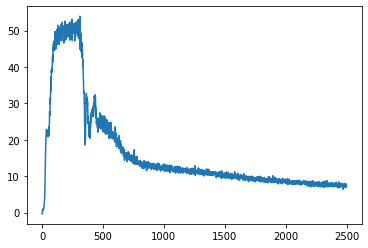

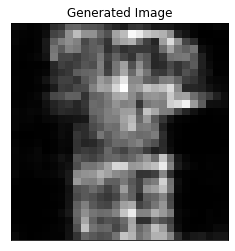

Iteration [2501/10000]......0.117(s) gen: 0.48481 - critic_fake: -1.10058 - critic_real: 6.90568 - neg_critic: 8.00626
Iteration [2502/10000]......0.115(s) gen: 0.99464 - critic_fake: -0.67785 - critic_real: 6.81839 - neg_critic: 7.49624
Iteration [2503/10000]......0.117(s) gen: 1.40060 - critic_fake: -1.24084 - critic_real: 6.59606 - neg_critic: 7.83691
Iteration [2504/10000]......0.117(s) gen: 1.90984 - critic_fake: -1.63960 - critic_real: 6.38472 - neg_critic: 8.02432
Iteration [2505/10000]......0.116(s) gen: 1.78517 - critic_fake: -2.01337 - critic_real: 5.51223 - neg_critic: 7.52560
Iteration [2506/10000]......0.117(s) gen: 1.34391 - critic_fake: -1.58277 - critic_real: 5.77904 - neg_critic: 7.36181
Iteration [2507/10000]......0.118(s) gen: 1.34438 - critic_fake: -1.31449 - critic_real: 6.48531 - neg_critic: 7.79980
Iteration [2508/10000]......0.133(s) gen: 1.52214 - critic_fake: -0.87420 - critic_real: 6.36407 - neg_critic: 7.23827
Iteration [2509/10000]......0.132(s) gen: 1.2421

Iteration [2570/10000]......0.117(s) gen: 0.83528 - critic_fake: -1.20234 - critic_real: 5.84502 - neg_critic: 7.04736
Iteration [2571/10000]......0.120(s) gen: 1.24480 - critic_fake: -0.94065 - critic_real: 6.86342 - neg_critic: 7.80407
Iteration [2572/10000]......0.122(s) gen: 0.18060 - critic_fake: -0.91160 - critic_real: 6.08725 - neg_critic: 6.99886
Iteration [2573/10000]......0.119(s) gen: 1.12823 - critic_fake: -0.92500 - critic_real: 6.68506 - neg_critic: 7.61006
Iteration [2574/10000]......0.119(s) gen: 0.90795 - critic_fake: -0.66789 - critic_real: 5.93032 - neg_critic: 6.59820
Iteration [2575/10000]......0.118(s) gen: 0.75256 - critic_fake: -0.94841 - critic_real: 6.26490 - neg_critic: 7.21332
Iteration [2576/10000]......0.116(s) gen: 1.18115 - critic_fake: -0.74084 - critic_real: 6.15220 - neg_critic: 6.89305
Iteration [2577/10000]......0.117(s) gen: 0.94162 - critic_fake: -1.06375 - critic_real: 7.08615 - neg_critic: 8.14990
Iteration [2578/10000]......0.120(s) gen: 0.5952

Iteration [2640/10000]......0.124(s) gen: 1.47524 - critic_fake: -1.71338 - critic_real: 5.64206 - neg_critic: 7.35543
Iteration [2641/10000]......0.125(s) gen: 0.55473 - critic_fake: -1.19857 - critic_real: 6.09958 - neg_critic: 7.29815
Iteration [2642/10000]......0.118(s) gen: 2.09804 - critic_fake: -1.31097 - critic_real: 6.42111 - neg_critic: 7.73208
Iteration [2643/10000]......0.118(s) gen: 1.01598 - critic_fake: -1.06861 - critic_real: 5.97329 - neg_critic: 7.04190
Iteration [2644/10000]......0.120(s) gen: 1.68980 - critic_fake: -0.96413 - critic_real: 6.22792 - neg_critic: 7.19204
Iteration [2645/10000]......0.119(s) gen: 0.54135 - critic_fake: -0.69167 - critic_real: 6.68139 - neg_critic: 7.37306
Iteration [2646/10000]......0.116(s) gen: 0.50377 - critic_fake: -0.92651 - critic_real: 5.82524 - neg_critic: 6.75174
Iteration [2647/10000]......0.116(s) gen: 1.38767 - critic_fake: -0.32676 - critic_real: 6.79785 - neg_critic: 7.12461
Iteration [2648/10000]......0.118(s) gen: 1.4623

Iteration [2710/10000]......0.120(s) gen: 1.45620 - critic_fake: -1.13198 - critic_real: 6.21988 - neg_critic: 7.35186
Iteration [2711/10000]......0.127(s) gen: 1.23777 - critic_fake: -1.12680 - critic_real: 6.36428 - neg_critic: 7.49108
Iteration [2712/10000]......0.115(s) gen: 0.69108 - critic_fake: -0.57966 - critic_real: 6.70320 - neg_critic: 7.28286
Iteration [2713/10000]......0.115(s) gen: 0.70989 - critic_fake: -0.78086 - critic_real: 6.34359 - neg_critic: 7.12446
Iteration [2714/10000]......0.118(s) gen: 0.85658 - critic_fake: -1.19818 - critic_real: 6.30332 - neg_critic: 7.50150
Iteration [2715/10000]......0.117(s) gen: 0.72108 - critic_fake: -0.42589 - critic_real: 6.61258 - neg_critic: 7.03847
Iteration [2716/10000]......0.119(s) gen: 0.67565 - critic_fake: -0.49708 - critic_real: 6.62551 - neg_critic: 7.12259
Iteration [2717/10000]......0.116(s) gen: 0.88820 - critic_fake: -0.38238 - critic_real: 6.40779 - neg_critic: 6.79017
Iteration [2718/10000]......0.116(s) gen: 1.2638

Iteration [2780/10000]......0.116(s) gen: 1.14400 - critic_fake: -0.65986 - critic_real: 6.95338 - neg_critic: 7.61324
Iteration [2781/10000]......0.116(s) gen: 0.31999 - critic_fake: -0.73056 - critic_real: 6.57751 - neg_critic: 7.30807
Iteration [2782/10000]......0.117(s) gen: 0.99154 - critic_fake: -1.02204 - critic_real: 6.47605 - neg_critic: 7.49809
Iteration [2783/10000]......0.117(s) gen: 0.14802 - critic_fake: -1.52866 - critic_real: 5.50628 - neg_critic: 7.03495
Iteration [2784/10000]......0.115(s) gen: 0.05317 - critic_fake: 0.07616 - critic_real: 7.10750 - neg_critic: 7.03134
Iteration [2785/10000]......0.117(s) gen: 0.84461 - critic_fake: -0.45545 - critic_real: 6.70375 - neg_critic: 7.15920
Iteration [2786/10000]......0.117(s) gen: -0.29151 - critic_fake: -0.72246 - critic_real: 6.63823 - neg_critic: 7.36069
Iteration [2787/10000]......0.117(s) gen: 1.33395 - critic_fake: -0.27700 - critic_real: 6.51309 - neg_critic: 6.79009
Iteration [2788/10000]......0.120(s) gen: 0.9803

Iteration [2850/10000]......0.119(s) gen: 0.86383 - critic_fake: -0.71057 - critic_real: 5.95136 - neg_critic: 6.66194
Iteration [2851/10000]......0.118(s) gen: 1.37385 - critic_fake: -1.64299 - critic_real: 5.65332 - neg_critic: 7.29632
Iteration [2852/10000]......0.119(s) gen: 0.94468 - critic_fake: -0.52218 - critic_real: 6.39749 - neg_critic: 6.91967
Iteration [2853/10000]......0.118(s) gen: 1.13861 - critic_fake: -0.88007 - critic_real: 6.37321 - neg_critic: 7.25328
Iteration [2854/10000]......0.116(s) gen: 1.09162 - critic_fake: -1.26517 - critic_real: 5.37000 - neg_critic: 6.63517
Iteration [2855/10000]......0.117(s) gen: 1.84206 - critic_fake: -1.04905 - critic_real: 5.71811 - neg_critic: 6.76716
Iteration [2856/10000]......0.117(s) gen: 1.47487 - critic_fake: -0.94540 - critic_real: 6.25159 - neg_critic: 7.19699
Iteration [2857/10000]......0.116(s) gen: 1.12103 - critic_fake: -0.97554 - critic_real: 6.16470 - neg_critic: 7.14024
Iteration [2858/10000]......0.115(s) gen: 1.3505

Iteration [2920/10000]......0.116(s) gen: 0.43439 - critic_fake: -0.83850 - critic_real: 6.02565 - neg_critic: 6.86414
Iteration [2921/10000]......0.114(s) gen: 0.80790 - critic_fake: -1.04790 - critic_real: 6.25746 - neg_critic: 7.30536
Iteration [2922/10000]......0.113(s) gen: 1.47327 - critic_fake: -0.69264 - critic_real: 6.29771 - neg_critic: 6.99035
Iteration [2923/10000]......0.112(s) gen: 1.27794 - critic_fake: -0.98597 - critic_real: 5.85954 - neg_critic: 6.84551
Iteration [2924/10000]......0.116(s) gen: 0.20874 - critic_fake: -0.77472 - critic_real: 5.93113 - neg_critic: 6.70585
Iteration [2925/10000]......0.118(s) gen: 0.38916 - critic_fake: -0.63445 - critic_real: 6.25838 - neg_critic: 6.89284
Iteration [2926/10000]......0.114(s) gen: 1.12635 - critic_fake: -0.65363 - critic_real: 6.60501 - neg_critic: 7.25864
Iteration [2927/10000]......0.113(s) gen: 0.28048 - critic_fake: -1.01103 - critic_real: 6.02557 - neg_critic: 7.03660
Iteration [2928/10000]......0.114(s) gen: 0.9069

Iteration [2990/10000]......0.117(s) gen: 1.65018 - critic_fake: -1.28449 - critic_real: 5.52672 - neg_critic: 6.81120
Iteration [2991/10000]......0.117(s) gen: 0.82479 - critic_fake: -1.44747 - critic_real: 5.60032 - neg_critic: 7.04779
Iteration [2992/10000]......0.117(s) gen: 0.97467 - critic_fake: -0.62158 - critic_real: 5.92299 - neg_critic: 6.54457
Iteration [2993/10000]......0.116(s) gen: 0.96078 - critic_fake: -0.85601 - critic_real: 5.60547 - neg_critic: 6.46148
Iteration [2994/10000]......0.117(s) gen: -0.02607 - critic_fake: -1.18715 - critic_real: 5.99104 - neg_critic: 7.17819
Iteration [2995/10000]......0.116(s) gen: 1.90135 - critic_fake: -0.86439 - critic_real: 6.04726 - neg_critic: 6.91164
Iteration [2996/10000]......0.117(s) gen: 0.96317 - critic_fake: -1.15682 - critic_real: 5.74191 - neg_critic: 6.89873
Iteration [2997/10000]......0.116(s) gen: 0.96017 - critic_fake: -1.20846 - critic_real: 5.73168 - neg_critic: 6.94013
Iteration [2998/10000]......0.117(s) gen: 0.590

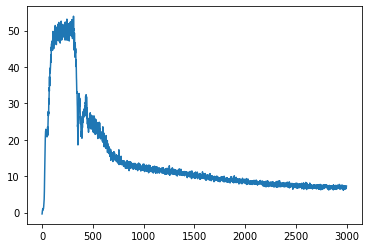

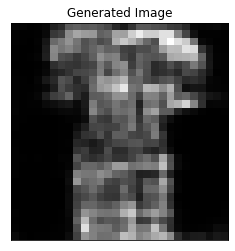

Iteration [3001/10000]......0.117(s) gen: 1.19926 - critic_fake: -1.28713 - critic_real: 5.98209 - neg_critic: 7.26922
Iteration [3002/10000]......0.115(s) gen: 0.90883 - critic_fake: -1.37123 - critic_real: 5.41865 - neg_critic: 6.78988
Iteration [3003/10000]......0.113(s) gen: 0.48580 - critic_fake: -0.69622 - critic_real: 5.92761 - neg_critic: 6.62382
Iteration [3004/10000]......0.113(s) gen: 1.23131 - critic_fake: -0.84978 - critic_real: 6.34643 - neg_critic: 7.19620
Iteration [3005/10000]......0.117(s) gen: 1.15438 - critic_fake: -1.11949 - critic_real: 5.84645 - neg_critic: 6.96593
Iteration [3006/10000]......0.115(s) gen: 1.10497 - critic_fake: -1.51977 - critic_real: 5.19568 - neg_critic: 6.71545
Iteration [3007/10000]......0.114(s) gen: 0.93975 - critic_fake: -0.97814 - critic_real: 5.97069 - neg_critic: 6.94883
Iteration [3008/10000]......0.116(s) gen: 1.26685 - critic_fake: -0.80546 - critic_real: 6.28105 - neg_critic: 7.08651
Iteration [3009/10000]......0.118(s) gen: 0.6542

Iteration [3070/10000]......0.116(s) gen: 0.95676 - critic_fake: -0.76135 - critic_real: 6.25276 - neg_critic: 7.01410
Iteration [3071/10000]......0.117(s) gen: 1.13740 - critic_fake: -0.68160 - critic_real: 6.25114 - neg_critic: 6.93274
Iteration [3072/10000]......0.117(s) gen: 1.45651 - critic_fake: -1.78287 - critic_real: 6.14804 - neg_critic: 7.93091
Iteration [3073/10000]......0.116(s) gen: 1.49858 - critic_fake: -1.33939 - critic_real: 4.87579 - neg_critic: 6.21518
Iteration [3074/10000]......0.115(s) gen: 1.22028 - critic_fake: -0.97661 - critic_real: 5.55156 - neg_critic: 6.52817
Iteration [3075/10000]......0.117(s) gen: -0.27033 - critic_fake: -0.59917 - critic_real: 6.44284 - neg_critic: 7.04202
Iteration [3076/10000]......0.116(s) gen: 0.19314 - critic_fake: 0.02986 - critic_real: 6.48614 - neg_critic: 6.45629
Iteration [3077/10000]......0.119(s) gen: 0.41583 - critic_fake: -0.45700 - critic_real: 5.71480 - neg_critic: 6.17179
Iteration [3078/10000]......0.119(s) gen: -0.125

Iteration [3140/10000]......0.118(s) gen: 1.17953 - critic_fake: -1.39347 - critic_real: 5.58747 - neg_critic: 6.98094
Iteration [3141/10000]......0.116(s) gen: 0.23494 - critic_fake: -1.17527 - critic_real: 5.91986 - neg_critic: 7.09513
Iteration [3142/10000]......0.117(s) gen: 0.96837 - critic_fake: -0.62830 - critic_real: 6.42274 - neg_critic: 7.05104
Iteration [3143/10000]......0.115(s) gen: 1.31239 - critic_fake: -0.62919 - critic_real: 5.93808 - neg_critic: 6.56726
Iteration [3144/10000]......0.118(s) gen: 0.63324 - critic_fake: -0.61237 - critic_real: 5.63665 - neg_critic: 6.24902
Iteration [3145/10000]......0.117(s) gen: 0.47852 - critic_fake: -0.61849 - critic_real: 6.13851 - neg_critic: 6.75700
Iteration [3146/10000]......0.116(s) gen: 1.99084 - critic_fake: -0.87391 - critic_real: 5.48400 - neg_critic: 6.35792
Iteration [3147/10000]......0.117(s) gen: 0.53738 - critic_fake: -1.21209 - critic_real: 6.16774 - neg_critic: 7.37983
Iteration [3148/10000]......0.118(s) gen: 1.2684

Iteration [3210/10000]......0.118(s) gen: 1.05184 - critic_fake: -1.16621 - critic_real: 5.41181 - neg_critic: 6.57803
Iteration [3211/10000]......0.117(s) gen: 1.14673 - critic_fake: -1.22521 - critic_real: 5.57066 - neg_critic: 6.79587
Iteration [3212/10000]......0.118(s) gen: 0.59994 - critic_fake: -1.27483 - critic_real: 6.15058 - neg_critic: 7.42541
Iteration [3213/10000]......0.116(s) gen: 1.38138 - critic_fake: -0.91064 - critic_real: 6.24113 - neg_critic: 7.15176
Iteration [3214/10000]......0.115(s) gen: 0.63112 - critic_fake: -1.08206 - critic_real: 5.55007 - neg_critic: 6.63213
Iteration [3215/10000]......0.117(s) gen: 1.03774 - critic_fake: -1.12636 - critic_real: 5.50328 - neg_critic: 6.62965
Iteration [3216/10000]......0.117(s) gen: 0.94769 - critic_fake: -1.06019 - critic_real: 5.37272 - neg_critic: 6.43290
Iteration [3217/10000]......0.117(s) gen: 1.73281 - critic_fake: -0.79476 - critic_real: 6.16763 - neg_critic: 6.96240
Iteration [3218/10000]......0.118(s) gen: 1.4779

Iteration [3280/10000]......0.115(s) gen: 1.78507 - critic_fake: -1.18824 - critic_real: 5.37692 - neg_critic: 6.56516
Iteration [3281/10000]......0.117(s) gen: 1.10785 - critic_fake: -1.03864 - critic_real: 5.42608 - neg_critic: 6.46472
Iteration [3282/10000]......0.121(s) gen: 1.12848 - critic_fake: -1.14568 - critic_real: 5.69070 - neg_critic: 6.83638
Iteration [3283/10000]......0.117(s) gen: 1.31468 - critic_fake: -1.35559 - critic_real: 5.46017 - neg_critic: 6.81576
Iteration [3284/10000]......0.118(s) gen: 0.55296 - critic_fake: -0.71491 - critic_real: 5.36684 - neg_critic: 6.08175
Iteration [3285/10000]......0.117(s) gen: 0.54910 - critic_fake: -0.83471 - critic_real: 6.19818 - neg_critic: 7.03289
Iteration [3286/10000]......0.115(s) gen: 0.47173 - critic_fake: -0.44211 - critic_real: 6.21786 - neg_critic: 6.65997
Iteration [3287/10000]......0.115(s) gen: 0.67772 - critic_fake: -1.03437 - critic_real: 5.90954 - neg_critic: 6.94391
Iteration [3288/10000]......0.116(s) gen: 0.8485

Iteration [3350/10000]......0.123(s) gen: 1.24227 - critic_fake: -1.40063 - critic_real: 5.79762 - neg_critic: 7.19825
Iteration [3351/10000]......0.123(s) gen: 1.10289 - critic_fake: -1.09120 - critic_real: 5.39571 - neg_critic: 6.48692
Iteration [3352/10000]......0.133(s) gen: 1.98790 - critic_fake: -1.60463 - critic_real: 4.95645 - neg_critic: 6.56108
Iteration [3353/10000]......0.121(s) gen: 1.28051 - critic_fake: -1.56724 - critic_real: 4.89860 - neg_critic: 6.46584
Iteration [3354/10000]......0.117(s) gen: 0.66906 - critic_fake: -0.86073 - critic_real: 5.86708 - neg_critic: 6.72781
Iteration [3355/10000]......0.119(s) gen: 0.76398 - critic_fake: -0.68367 - critic_real: 5.55786 - neg_critic: 6.24153
Iteration [3356/10000]......0.124(s) gen: 0.93060 - critic_fake: -1.21284 - critic_real: 5.28154 - neg_critic: 6.49438
Iteration [3357/10000]......0.114(s) gen: 0.79074 - critic_fake: -1.47551 - critic_real: 5.80130 - neg_critic: 7.27682
Iteration [3358/10000]......0.117(s) gen: 1.4627

Iteration [3420/10000]......0.120(s) gen: 0.20172 - critic_fake: -0.37455 - critic_real: 6.38457 - neg_critic: 6.75912
Iteration [3421/10000]......0.116(s) gen: 0.94235 - critic_fake: -0.00233 - critic_real: 5.75821 - neg_critic: 5.76054
Iteration [3422/10000]......0.115(s) gen: 0.88928 - critic_fake: -1.04419 - critic_real: 5.41031 - neg_critic: 6.45450
Iteration [3423/10000]......0.114(s) gen: 1.14917 - critic_fake: -1.21689 - critic_real: 5.18354 - neg_critic: 6.40044
Iteration [3424/10000]......0.115(s) gen: 1.22225 - critic_fake: -0.97964 - critic_real: 5.76259 - neg_critic: 6.74223
Iteration [3425/10000]......0.116(s) gen: 1.15860 - critic_fake: -1.00980 - critic_real: 5.44685 - neg_critic: 6.45664
Iteration [3426/10000]......0.118(s) gen: 1.22524 - critic_fake: -1.13894 - critic_real: 5.05850 - neg_critic: 6.19744
Iteration [3427/10000]......0.120(s) gen: 1.88313 - critic_fake: -1.51731 - critic_real: 5.22717 - neg_critic: 6.74448
Iteration [3428/10000]......0.119(s) gen: 1.9407

Iteration [3490/10000]......0.116(s) gen: 0.33758 - critic_fake: -1.29192 - critic_real: 5.37974 - neg_critic: 6.67166
Iteration [3491/10000]......0.116(s) gen: 1.74354 - critic_fake: -0.50637 - critic_real: 5.60257 - neg_critic: 6.10894
Iteration [3492/10000]......0.115(s) gen: 1.38815 - critic_fake: -0.97747 - critic_real: 5.27017 - neg_critic: 6.24763
Iteration [3493/10000]......0.113(s) gen: 1.83176 - critic_fake: -1.09330 - critic_real: 5.50366 - neg_critic: 6.59696
Iteration [3494/10000]......0.115(s) gen: 1.16623 - critic_fake: -1.30304 - critic_real: 5.22648 - neg_critic: 6.52952
Iteration [3495/10000]......0.114(s) gen: 1.23500 - critic_fake: -0.93975 - critic_real: 5.21914 - neg_critic: 6.15889
Iteration [3496/10000]......0.115(s) gen: 2.12347 - critic_fake: -1.61176 - critic_real: 5.64948 - neg_critic: 7.26124
Iteration [3497/10000]......0.117(s) gen: 1.40653 - critic_fake: -1.49925 - critic_real: 5.40767 - neg_critic: 6.90692
Iteration [3498/10000]......0.120(s) gen: 1.1671

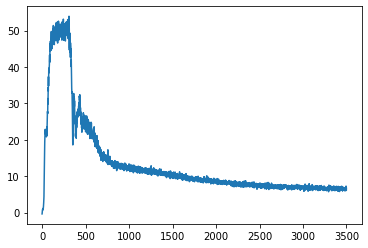

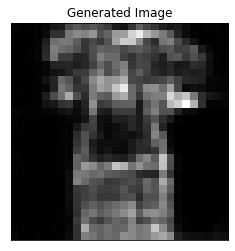

Iteration [3501/10000]......0.117(s) gen: 1.27496 - critic_fake: -0.32750 - critic_real: 6.22690 - neg_critic: 6.55440
Iteration [3502/10000]......0.117(s) gen: 0.73678 - critic_fake: -0.78158 - critic_real: 5.47997 - neg_critic: 6.26155
Iteration [3503/10000]......0.121(s) gen: 0.85861 - critic_fake: -0.23912 - critic_real: 5.94185 - neg_critic: 6.18097
Iteration [3504/10000]......0.117(s) gen: 1.43953 - critic_fake: -0.58316 - critic_real: 5.44645 - neg_critic: 6.02961
Iteration [3505/10000]......0.115(s) gen: 1.32121 - critic_fake: -1.14982 - critic_real: 5.81202 - neg_critic: 6.96185
Iteration [3506/10000]......0.117(s) gen: 0.47282 - critic_fake: -0.93945 - critic_real: 6.08477 - neg_critic: 7.02423
Iteration [3507/10000]......0.118(s) gen: 1.12505 - critic_fake: -0.91856 - critic_real: 5.65658 - neg_critic: 6.57513
Iteration [3508/10000]......0.119(s) gen: 0.37261 - critic_fake: -0.27111 - critic_real: 6.32599 - neg_critic: 6.59710
Iteration [3509/10000]......0.122(s) gen: 1.3466

Iteration [3570/10000]......0.120(s) gen: 0.45958 - critic_fake: -0.29425 - critic_real: 6.46018 - neg_critic: 6.75443
Iteration [3571/10000]......0.120(s) gen: 0.81407 - critic_fake: -0.50404 - critic_real: 5.73380 - neg_critic: 6.23784
Iteration [3572/10000]......0.120(s) gen: 0.77444 - critic_fake: -0.70102 - critic_real: 5.81101 - neg_critic: 6.51204
Iteration [3573/10000]......0.118(s) gen: 0.70300 - critic_fake: -0.67327 - critic_real: 5.72619 - neg_critic: 6.39946
Iteration [3574/10000]......0.120(s) gen: 0.91047 - critic_fake: -0.60786 - critic_real: 6.00210 - neg_critic: 6.60996
Iteration [3575/10000]......0.117(s) gen: 0.98487 - critic_fake: -1.20685 - critic_real: 5.94983 - neg_critic: 7.15669
Iteration [3576/10000]......0.119(s) gen: 1.14127 - critic_fake: -1.01769 - critic_real: 5.06520 - neg_critic: 6.08289
Iteration [3577/10000]......0.119(s) gen: 0.58397 - critic_fake: -0.79622 - critic_real: 5.93807 - neg_critic: 6.73429
Iteration [3578/10000]......0.116(s) gen: 1.6484

Iteration [3640/10000]......0.122(s) gen: 1.07740 - critic_fake: -1.35928 - critic_real: 5.17497 - neg_critic: 6.53425
Iteration [3641/10000]......0.119(s) gen: 0.71031 - critic_fake: -0.41438 - critic_real: 6.53077 - neg_critic: 6.94515
Iteration [3642/10000]......0.118(s) gen: 1.26009 - critic_fake: -0.66312 - critic_real: 5.49512 - neg_critic: 6.15825
Iteration [3643/10000]......0.119(s) gen: 0.72134 - critic_fake: -1.17641 - critic_real: 5.24528 - neg_critic: 6.42168
Iteration [3644/10000]......0.118(s) gen: 1.20807 - critic_fake: -0.83444 - critic_real: 6.16521 - neg_critic: 6.99965
Iteration [3645/10000]......0.118(s) gen: 0.62862 - critic_fake: -0.68419 - critic_real: 6.18808 - neg_critic: 6.87227
Iteration [3646/10000]......0.119(s) gen: 1.69946 - critic_fake: -0.78540 - critic_real: 5.73133 - neg_critic: 6.51673
Iteration [3647/10000]......0.118(s) gen: 0.66022 - critic_fake: -1.14049 - critic_real: 5.39265 - neg_critic: 6.53314
Iteration [3648/10000]......0.116(s) gen: 1.5395

Iteration [3710/10000]......0.119(s) gen: 0.08530 - critic_fake: -0.63638 - critic_real: 5.68406 - neg_critic: 6.32043
Iteration [3711/10000]......0.121(s) gen: 0.76323 - critic_fake: -0.84089 - critic_real: 5.31234 - neg_critic: 6.15323
Iteration [3712/10000]......0.124(s) gen: 0.74854 - critic_fake: -0.52975 - critic_real: 5.55063 - neg_critic: 6.08039
Iteration [3713/10000]......0.121(s) gen: 0.84451 - critic_fake: -0.86387 - critic_real: 5.39432 - neg_critic: 6.25819
Iteration [3714/10000]......0.120(s) gen: 1.30988 - critic_fake: -1.16620 - critic_real: 5.57444 - neg_critic: 6.74063
Iteration [3715/10000]......0.123(s) gen: 1.43969 - critic_fake: -1.27484 - critic_real: 5.31613 - neg_critic: 6.59097
Iteration [3716/10000]......0.122(s) gen: 1.06318 - critic_fake: -1.49686 - critic_real: 4.64478 - neg_critic: 6.14164
Iteration [3717/10000]......0.118(s) gen: 0.67849 - critic_fake: -1.09371 - critic_real: 4.75330 - neg_critic: 5.84701
Iteration [3718/10000]......0.119(s) gen: 1.8201

Iteration [3780/10000]......0.123(s) gen: 0.72225 - critic_fake: -0.78856 - critic_real: 5.61031 - neg_critic: 6.39887
Iteration [3781/10000]......0.121(s) gen: 1.33368 - critic_fake: -1.24926 - critic_real: 5.29610 - neg_critic: 6.54536
Iteration [3782/10000]......0.118(s) gen: 1.25105 - critic_fake: -1.83512 - critic_real: 5.08253 - neg_critic: 6.91765
Iteration [3783/10000]......0.121(s) gen: 1.08273 - critic_fake: -1.27282 - critic_real: 5.04460 - neg_critic: 6.31742
Iteration [3784/10000]......0.119(s) gen: 1.64379 - critic_fake: -1.48095 - critic_real: 5.16662 - neg_critic: 6.64757
Iteration [3785/10000]......0.118(s) gen: 0.77540 - critic_fake: -0.78594 - critic_real: 5.68326 - neg_critic: 6.46920
Iteration [3786/10000]......0.118(s) gen: 1.59485 - critic_fake: -1.03121 - critic_real: 5.38262 - neg_critic: 6.41382
Iteration [3787/10000]......0.119(s) gen: 2.46466 - critic_fake: -1.59921 - critic_real: 4.53647 - neg_critic: 6.13568
Iteration [3788/10000]......0.118(s) gen: 1.3327

Iteration [3850/10000]......0.125(s) gen: 0.61454 - critic_fake: -0.86929 - critic_real: 4.97871 - neg_critic: 5.84800
Iteration [3851/10000]......0.123(s) gen: 1.02605 - critic_fake: -0.44915 - critic_real: 5.46965 - neg_critic: 5.91879
Iteration [3852/10000]......0.123(s) gen: 0.98179 - critic_fake: -0.81173 - critic_real: 5.24910 - neg_critic: 6.06084
Iteration [3853/10000]......0.121(s) gen: 0.14131 - critic_fake: -0.73702 - critic_real: 5.40834 - neg_critic: 6.14537
Iteration [3854/10000]......0.122(s) gen: 1.34081 - critic_fake: -0.73071 - critic_real: 5.51434 - neg_critic: 6.24505
Iteration [3855/10000]......0.121(s) gen: -0.26959 - critic_fake: -0.50420 - critic_real: 5.62055 - neg_critic: 6.12475
Iteration [3856/10000]......0.120(s) gen: 0.90014 - critic_fake: 0.04712 - critic_real: 6.33990 - neg_critic: 6.29278
Iteration [3857/10000]......0.120(s) gen: 0.85851 - critic_fake: -0.24217 - critic_real: 5.63782 - neg_critic: 5.87999
Iteration [3858/10000]......0.119(s) gen: 0.0149

Iteration [3920/10000]......0.120(s) gen: 0.61617 - critic_fake: -1.00467 - critic_real: 5.64147 - neg_critic: 6.64615
Iteration [3921/10000]......0.119(s) gen: 0.58354 - critic_fake: -0.73357 - critic_real: 5.19971 - neg_critic: 5.93328
Iteration [3922/10000]......0.123(s) gen: 0.94266 - critic_fake: -0.99650 - critic_real: 5.21034 - neg_critic: 6.20684
Iteration [3923/10000]......0.120(s) gen: 1.00030 - critic_fake: -1.03861 - critic_real: 5.06074 - neg_critic: 6.09936
Iteration [3924/10000]......0.121(s) gen: 0.35554 - critic_fake: -1.30705 - critic_real: 5.25482 - neg_critic: 6.56187
Iteration [3925/10000]......0.121(s) gen: 0.51113 - critic_fake: -0.02150 - critic_real: 5.55379 - neg_critic: 5.57529
Iteration [3926/10000]......0.121(s) gen: 0.02895 - critic_fake: -0.50187 - critic_real: 5.92413 - neg_critic: 6.42601
Iteration [3927/10000]......0.118(s) gen: 0.61785 - critic_fake: -0.27043 - critic_real: 5.78197 - neg_critic: 6.05240
Iteration [3928/10000]......0.119(s) gen: 0.3103

Iteration [3990/10000]......0.119(s) gen: 1.43023 - critic_fake: -1.27297 - critic_real: 5.16700 - neg_critic: 6.43997
Iteration [3991/10000]......0.117(s) gen: 0.41240 - critic_fake: -0.95869 - critic_real: 5.36520 - neg_critic: 6.32389
Iteration [3992/10000]......0.121(s) gen: 1.11838 - critic_fake: -0.81800 - critic_real: 5.37964 - neg_critic: 6.19764
Iteration [3993/10000]......0.117(s) gen: 0.37500 - critic_fake: -0.48285 - critic_real: 5.68782 - neg_critic: 6.17067
Iteration [3994/10000]......0.120(s) gen: 0.77609 - critic_fake: -0.93822 - critic_real: 5.42875 - neg_critic: 6.36696
Iteration [3995/10000]......0.122(s) gen: 0.87780 - critic_fake: -0.78424 - critic_real: 5.38624 - neg_critic: 6.17048
Iteration [3996/10000]......0.121(s) gen: 1.16240 - critic_fake: -0.71541 - critic_real: 5.48774 - neg_critic: 6.20315
Iteration [3997/10000]......0.119(s) gen: 0.79134 - critic_fake: -0.56152 - critic_real: 5.54117 - neg_critic: 6.10269
Iteration [3998/10000]......0.120(s) gen: 0.9076

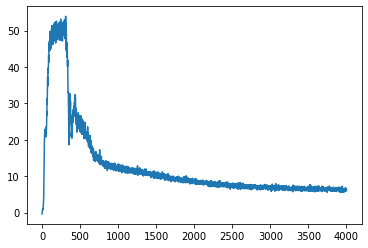

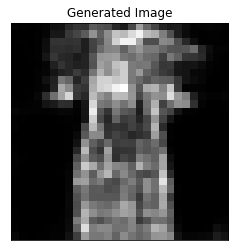

Iteration [4001/10000]......0.114(s) gen: 0.97866 - critic_fake: -1.12752 - critic_real: 5.66420 - neg_critic: 6.79172
Iteration [4002/10000]......0.113(s) gen: 1.15633 - critic_fake: -1.19359 - critic_real: 5.17628 - neg_critic: 6.36987
Iteration [4003/10000]......0.113(s) gen: 2.49436 - critic_fake: -1.36504 - critic_real: 4.73291 - neg_critic: 6.09795
Iteration [4004/10000]......0.114(s) gen: 1.87347 - critic_fake: -1.35444 - critic_real: 4.57568 - neg_critic: 5.93012
Iteration [4005/10000]......0.113(s) gen: 1.11905 - critic_fake: -1.35473 - critic_real: 5.00415 - neg_critic: 6.35888
Iteration [4006/10000]......0.113(s) gen: 1.20270 - critic_fake: -0.92973 - critic_real: 5.32174 - neg_critic: 6.25147
Iteration [4007/10000]......0.113(s) gen: 0.77818 - critic_fake: -0.96562 - critic_real: 5.15831 - neg_critic: 6.12393
Iteration [4008/10000]......0.116(s) gen: 0.99974 - critic_fake: -1.11635 - critic_real: 5.14885 - neg_critic: 6.26521
Iteration [4009/10000]......0.116(s) gen: 0.8321

Iteration [4070/10000]......0.120(s) gen: 0.95448 - critic_fake: -0.84336 - critic_real: 4.88688 - neg_critic: 5.73025
Iteration [4071/10000]......0.117(s) gen: 0.59739 - critic_fake: -1.01133 - critic_real: 5.35719 - neg_critic: 6.36853
Iteration [4072/10000]......0.119(s) gen: 0.03967 - critic_fake: -0.78965 - critic_real: 5.53656 - neg_critic: 6.32621
Iteration [4073/10000]......0.119(s) gen: 0.72776 - critic_fake: -0.64298 - critic_real: 5.31294 - neg_critic: 5.95592
Iteration [4074/10000]......0.120(s) gen: 0.81128 - critic_fake: -1.03575 - critic_real: 5.54601 - neg_critic: 6.58176
Iteration [4075/10000]......0.119(s) gen: 0.89273 - critic_fake: -0.93547 - critic_real: 5.32041 - neg_critic: 6.25588
Iteration [4076/10000]......0.119(s) gen: 0.67954 - critic_fake: -0.60661 - critic_real: 6.19083 - neg_critic: 6.79744
Iteration [4077/10000]......0.120(s) gen: 1.45095 - critic_fake: -1.04466 - critic_real: 5.40469 - neg_critic: 6.44935
Iteration [4078/10000]......0.122(s) gen: 1.4804

Iteration [4140/10000]......0.121(s) gen: 0.57443 - critic_fake: -0.57472 - critic_real: 6.12655 - neg_critic: 6.70127
Iteration [4141/10000]......0.121(s) gen: 0.31285 - critic_fake: -0.74041 - critic_real: 5.33599 - neg_critic: 6.07640
Iteration [4142/10000]......0.121(s) gen: 0.76915 - critic_fake: -0.56719 - critic_real: 5.39902 - neg_critic: 5.96621
Iteration [4143/10000]......0.119(s) gen: 0.62634 - critic_fake: -0.75065 - critic_real: 5.25187 - neg_critic: 6.00252
Iteration [4144/10000]......0.117(s) gen: 0.92203 - critic_fake: -0.63566 - critic_real: 5.34832 - neg_critic: 5.98398
Iteration [4145/10000]......0.116(s) gen: 0.91688 - critic_fake: -0.47696 - critic_real: 5.61763 - neg_critic: 6.09458
Iteration [4146/10000]......0.120(s) gen: 1.02737 - critic_fake: -0.54353 - critic_real: 5.07664 - neg_critic: 5.62017
Iteration [4147/10000]......0.117(s) gen: 0.96427 - critic_fake: -0.30404 - critic_real: 6.01264 - neg_critic: 6.31668
Iteration [4148/10000]......0.115(s) gen: 1.0082

Iteration [4210/10000]......0.120(s) gen: 1.24114 - critic_fake: -1.50065 - critic_real: 4.79937 - neg_critic: 6.30002
Iteration [4211/10000]......0.117(s) gen: 1.34093 - critic_fake: -1.60092 - critic_real: 4.65502 - neg_critic: 6.25594
Iteration [4212/10000]......0.117(s) gen: 1.35178 - critic_fake: -1.26774 - critic_real: 4.63759 - neg_critic: 5.90532
Iteration [4213/10000]......0.117(s) gen: 0.89140 - critic_fake: -1.03016 - critic_real: 4.78685 - neg_critic: 5.81701
Iteration [4214/10000]......0.116(s) gen: 0.97678 - critic_fake: -0.81818 - critic_real: 5.06626 - neg_critic: 5.88444
Iteration [4215/10000]......0.118(s) gen: 0.27943 - critic_fake: -0.82528 - critic_real: 5.14218 - neg_critic: 5.96746
Iteration [4216/10000]......0.118(s) gen: 0.82654 - critic_fake: -0.48533 - critic_real: 5.64059 - neg_critic: 6.12592
Iteration [4217/10000]......0.114(s) gen: 0.64079 - critic_fake: -0.62827 - critic_real: 5.44679 - neg_critic: 6.07506
Iteration [4218/10000]......0.116(s) gen: 0.2095

Iteration [4280/10000]......0.119(s) gen: -0.23088 - critic_fake: -0.73104 - critic_real: 5.36879 - neg_critic: 6.09984
Iteration [4281/10000]......0.119(s) gen: 1.33397 - critic_fake: -0.67419 - critic_real: 5.64112 - neg_critic: 6.31531
Iteration [4282/10000]......0.118(s) gen: 1.27927 - critic_fake: -1.47647 - critic_real: 5.28213 - neg_critic: 6.75859
Iteration [4283/10000]......0.119(s) gen: 0.67713 - critic_fake: -0.93136 - critic_real: 5.17024 - neg_critic: 6.10160
Iteration [4284/10000]......0.121(s) gen: 0.67969 - critic_fake: -1.23850 - critic_real: 5.23831 - neg_critic: 6.47681
Iteration [4285/10000]......0.122(s) gen: 1.10844 - critic_fake: -0.92963 - critic_real: 5.22682 - neg_critic: 6.15645
Iteration [4286/10000]......0.120(s) gen: 0.50574 - critic_fake: -1.53028 - critic_real: 4.87202 - neg_critic: 6.40229
Iteration [4287/10000]......0.118(s) gen: 0.45434 - critic_fake: -1.46463 - critic_real: 5.33280 - neg_critic: 6.79743
Iteration [4288/10000]......0.118(s) gen: 1.336

Iteration [4350/10000]......0.120(s) gen: 1.26935 - critic_fake: -1.12792 - critic_real: 4.84732 - neg_critic: 5.97523
Iteration [4351/10000]......0.121(s) gen: 1.09114 - critic_fake: -1.19923 - critic_real: 4.76727 - neg_critic: 5.96650
Iteration [4352/10000]......0.119(s) gen: 0.50392 - critic_fake: -0.96709 - critic_real: 5.04043 - neg_critic: 6.00752
Iteration [4353/10000]......0.121(s) gen: 1.13418 - critic_fake: -0.22775 - critic_real: 5.52388 - neg_critic: 5.75164
Iteration [4354/10000]......0.119(s) gen: 0.55856 - critic_fake: -0.62665 - critic_real: 5.46396 - neg_critic: 6.09061
Iteration [4355/10000]......0.119(s) gen: 0.34412 - critic_fake: -0.60413 - critic_real: 5.77476 - neg_critic: 6.37889
Iteration [4356/10000]......0.119(s) gen: 0.26999 - critic_fake: -0.79662 - critic_real: 4.88363 - neg_critic: 5.68025
Iteration [4357/10000]......0.118(s) gen: 0.79634 - critic_fake: -0.66605 - critic_real: 5.33483 - neg_critic: 6.00088
Iteration [4358/10000]......0.119(s) gen: 0.6643

Iteration [4420/10000]......0.119(s) gen: 0.33485 - critic_fake: -0.21605 - critic_real: 5.49668 - neg_critic: 5.71273
Iteration [4421/10000]......0.119(s) gen: 0.57680 - critic_fake: -0.93516 - critic_real: 5.49970 - neg_critic: 6.43486
Iteration [4422/10000]......0.121(s) gen: 0.66603 - critic_fake: -0.43365 - critic_real: 5.69579 - neg_critic: 6.12944
Iteration [4423/10000]......0.123(s) gen: 0.45113 - critic_fake: -0.89432 - critic_real: 5.54120 - neg_critic: 6.43552
Iteration [4424/10000]......0.125(s) gen: 0.76399 - critic_fake: -0.73461 - critic_real: 5.07154 - neg_critic: 5.80615
Iteration [4425/10000]......0.121(s) gen: 0.03443 - critic_fake: -0.37861 - critic_real: 5.93130 - neg_critic: 6.30992
Iteration [4426/10000]......0.123(s) gen: 0.59325 - critic_fake: -0.60018 - critic_real: 5.48704 - neg_critic: 6.08722
Iteration [4427/10000]......0.122(s) gen: 0.79648 - critic_fake: -0.32866 - critic_real: 5.51090 - neg_critic: 5.83956
Iteration [4428/10000]......0.122(s) gen: 0.6342

Iteration [4490/10000]......0.122(s) gen: 0.68814 - critic_fake: -1.00672 - critic_real: 4.79574 - neg_critic: 5.80246
Iteration [4491/10000]......0.121(s) gen: 0.96384 - critic_fake: -0.55252 - critic_real: 5.38286 - neg_critic: 5.93538
Iteration [4492/10000]......0.120(s) gen: 1.79539 - critic_fake: -0.89669 - critic_real: 5.10595 - neg_critic: 6.00264
Iteration [4493/10000]......0.118(s) gen: 0.98976 - critic_fake: -1.05022 - critic_real: 5.24345 - neg_critic: 6.29366
Iteration [4494/10000]......0.118(s) gen: 1.67724 - critic_fake: -0.80826 - critic_real: 5.19275 - neg_critic: 6.00101
Iteration [4495/10000]......0.120(s) gen: 1.69414 - critic_fake: -1.25817 - critic_real: 4.88783 - neg_critic: 6.14599
Iteration [4496/10000]......0.119(s) gen: 0.92063 - critic_fake: -1.29439 - critic_real: 4.47763 - neg_critic: 5.77203
Iteration [4497/10000]......0.118(s) gen: 0.24571 - critic_fake: -0.45782 - critic_real: 5.36682 - neg_critic: 5.82464
Iteration [4498/10000]......0.119(s) gen: 0.8394

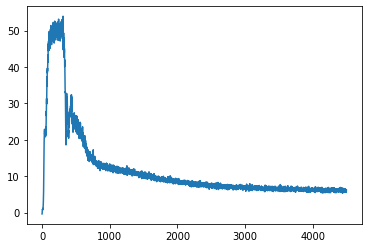

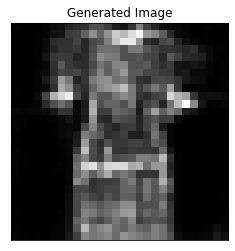

Iteration [4501/10000]......0.122(s) gen: 1.02085 - critic_fake: -1.28368 - critic_real: 4.51823 - neg_critic: 5.80191
Iteration [4502/10000]......0.136(s) gen: 0.72745 - critic_fake: -1.01163 - critic_real: 4.86148 - neg_critic: 5.87311
Iteration [4503/10000]......0.138(s) gen: 0.38176 - critic_fake: -1.02745 - critic_real: 5.34284 - neg_critic: 6.37029
Iteration [4504/10000]......0.136(s) gen: 0.86359 - critic_fake: -0.73042 - critic_real: 5.35600 - neg_critic: 6.08642
Iteration [4505/10000]......0.134(s) gen: 1.63703 - critic_fake: -0.97473 - critic_real: 5.24599 - neg_critic: 6.22072
Iteration [4506/10000]......0.135(s) gen: 1.02466 - critic_fake: -0.79521 - critic_real: 4.48263 - neg_critic: 5.27784
Iteration [4507/10000]......0.138(s) gen: 1.33806 - critic_fake: -1.38381 - critic_real: 4.80575 - neg_critic: 6.18956
Iteration [4508/10000]......0.136(s) gen: 1.49020 - critic_fake: -0.92260 - critic_real: 5.06669 - neg_critic: 5.98929
Iteration [4509/10000]......0.136(s) gen: 1.0276

Iteration [4570/10000]......0.120(s) gen: 0.47865 - critic_fake: -1.03843 - critic_real: 5.25539 - neg_critic: 6.29382
Iteration [4571/10000]......0.119(s) gen: 1.17190 - critic_fake: -0.88247 - critic_real: 4.93773 - neg_critic: 5.82020
Iteration [4572/10000]......0.117(s) gen: 1.24557 - critic_fake: -0.92304 - critic_real: 4.72927 - neg_critic: 5.65231
Iteration [4573/10000]......0.119(s) gen: 1.46115 - critic_fake: -1.14044 - critic_real: 4.77848 - neg_critic: 5.91892
Iteration [4574/10000]......0.121(s) gen: 0.54762 - critic_fake: -0.90795 - critic_real: 5.46870 - neg_critic: 6.37665
Iteration [4575/10000]......0.118(s) gen: 1.13240 - critic_fake: -0.52297 - critic_real: 5.23497 - neg_critic: 5.75794
Iteration [4576/10000]......0.117(s) gen: 0.16038 - critic_fake: -0.62886 - critic_real: 5.27039 - neg_critic: 5.89925
Iteration [4577/10000]......0.118(s) gen: 0.78893 - critic_fake: -0.49178 - critic_real: 5.52569 - neg_critic: 6.01748
Iteration [4578/10000]......0.117(s) gen: 0.6387

Iteration [4639/10000]......0.115(s) gen: 0.88835 - critic_fake: -0.81449 - critic_real: 4.97301 - neg_critic: 5.78750
Iteration [4640/10000]......0.114(s) gen: 0.75116 - critic_fake: -1.13571 - critic_real: 4.75194 - neg_critic: 5.88765
Iteration [4641/10000]......0.116(s) gen: 1.61075 - critic_fake: -1.27851 - critic_real: 5.32801 - neg_critic: 6.60652
Iteration [4642/10000]......0.118(s) gen: 0.34935 - critic_fake: -1.13607 - critic_real: 4.98204 - neg_critic: 6.11811
Iteration [4643/10000]......0.115(s) gen: 1.28355 - critic_fake: -1.00271 - critic_real: 4.90421 - neg_critic: 5.90692
Iteration [4644/10000]......0.120(s) gen: 0.98557 - critic_fake: -1.09466 - critic_real: 5.22322 - neg_critic: 6.31788
Iteration [4645/10000]......0.119(s) gen: 0.75563 - critic_fake: -1.13654 - critic_real: 4.66240 - neg_critic: 5.79894
Iteration [4646/10000]......0.119(s) gen: 1.49601 - critic_fake: -0.95313 - critic_real: 4.93572 - neg_critic: 5.88885
Iteration [4647/10000]......0.115(s) gen: 0.7359

Iteration [4708/10000]......0.120(s) gen: 0.45220 - critic_fake: -0.46575 - critic_real: 5.34788 - neg_critic: 5.81363
Iteration [4709/10000]......0.119(s) gen: 1.00298 - critic_fake: -0.41924 - critic_real: 5.44178 - neg_critic: 5.86102
Iteration [4710/10000]......0.119(s) gen: 0.32747 - critic_fake: -0.55183 - critic_real: 4.85036 - neg_critic: 5.40219
Iteration [4711/10000]......0.122(s) gen: 1.02641 - critic_fake: -0.99527 - critic_real: 5.03479 - neg_critic: 6.03006
Iteration [4712/10000]......0.121(s) gen: 1.19733 - critic_fake: -0.77016 - critic_real: 4.89369 - neg_critic: 5.66385
Iteration [4713/10000]......0.121(s) gen: 1.63378 - critic_fake: -0.98021 - critic_real: 5.14850 - neg_critic: 6.12871
Iteration [4714/10000]......0.121(s) gen: 0.40411 - critic_fake: -0.73792 - critic_real: 4.97468 - neg_critic: 5.71260
Iteration [4715/10000]......0.121(s) gen: 0.53474 - critic_fake: -0.89522 - critic_real: 5.26156 - neg_critic: 6.15678
Iteration [4716/10000]......0.121(s) gen: 0.8303

Iteration [4777/10000]......0.117(s) gen: 0.63918 - critic_fake: -0.96729 - critic_real: 4.72284 - neg_critic: 5.69013
Iteration [4778/10000]......0.120(s) gen: 1.28378 - critic_fake: -1.22944 - critic_real: 4.81175 - neg_critic: 6.04119
Iteration [4779/10000]......0.123(s) gen: 1.24142 - critic_fake: -0.98673 - critic_real: 5.36318 - neg_critic: 6.34991
Iteration [4780/10000]......0.120(s) gen: 1.17830 - critic_fake: -0.96919 - critic_real: 5.10986 - neg_critic: 6.07906
Iteration [4781/10000]......0.119(s) gen: 0.81325 - critic_fake: -1.24449 - critic_real: 4.93162 - neg_critic: 6.17611
Iteration [4782/10000]......0.121(s) gen: 1.41685 - critic_fake: -0.67340 - critic_real: 5.32590 - neg_critic: 5.99930
Iteration [4783/10000]......0.124(s) gen: 1.17143 - critic_fake: -0.91257 - critic_real: 4.98448 - neg_critic: 5.89704
Iteration [4784/10000]......0.121(s) gen: 1.81995 - critic_fake: -1.24168 - critic_real: 4.56998 - neg_critic: 5.81166
Iteration [4785/10000]......0.121(s) gen: 0.4456

Iteration [4846/10000]......0.119(s) gen: 0.30611 - critic_fake: -0.44150 - critic_real: 5.23641 - neg_critic: 5.67791
Iteration [4847/10000]......0.119(s) gen: 0.97020 - critic_fake: -0.82840 - critic_real: 4.86899 - neg_critic: 5.69739
Iteration [4848/10000]......0.119(s) gen: 1.03574 - critic_fake: -1.07891 - critic_real: 5.00288 - neg_critic: 6.08178
Iteration [4849/10000]......0.120(s) gen: 0.39159 - critic_fake: -0.80584 - critic_real: 5.28248 - neg_critic: 6.08832
Iteration [4850/10000]......0.119(s) gen: 0.89978 - critic_fake: -0.77932 - critic_real: 4.96847 - neg_critic: 5.74779
Iteration [4851/10000]......0.118(s) gen: -0.23468 - critic_fake: -0.27426 - critic_real: 5.86457 - neg_critic: 6.13883
Iteration [4852/10000]......0.117(s) gen: 0.49389 - critic_fake: -0.53580 - critic_real: 5.39374 - neg_critic: 5.92954
Iteration [4853/10000]......0.118(s) gen: -0.27818 - critic_fake: -0.34936 - critic_real: 5.74914 - neg_critic: 6.09849
Iteration [4854/10000]......0.122(s) gen: 1.04

Iteration [4915/10000]......0.119(s) gen: 1.71445 - critic_fake: -0.93574 - critic_real: 4.79461 - neg_critic: 5.73035
Iteration [4916/10000]......0.120(s) gen: 0.69805 - critic_fake: -0.67631 - critic_real: 4.37443 - neg_critic: 5.05075
Iteration [4917/10000]......0.119(s) gen: 1.24651 - critic_fake: -0.82628 - critic_real: 4.72466 - neg_critic: 5.55094
Iteration [4918/10000]......0.118(s) gen: 0.72202 - critic_fake: -0.81448 - critic_real: 5.07351 - neg_critic: 5.88799
Iteration [4919/10000]......0.118(s) gen: 0.77256 - critic_fake: -0.78775 - critic_real: 5.34535 - neg_critic: 6.13310
Iteration [4920/10000]......0.117(s) gen: 1.22190 - critic_fake: -0.99026 - critic_real: 4.80848 - neg_critic: 5.79874
Iteration [4921/10000]......0.117(s) gen: 0.69212 - critic_fake: -1.24661 - critic_real: 4.81813 - neg_critic: 6.06474
Iteration [4922/10000]......0.116(s) gen: 0.67127 - critic_fake: -0.66553 - critic_real: 5.22876 - neg_critic: 5.89429
Iteration [4923/10000]......0.115(s) gen: 1.6187

Iteration [4984/10000]......0.123(s) gen: 1.28381 - critic_fake: -1.01151 - critic_real: 4.89319 - neg_critic: 5.90470
Iteration [4985/10000]......0.119(s) gen: 1.49480 - critic_fake: -0.89867 - critic_real: 4.75391 - neg_critic: 5.65257
Iteration [4986/10000]......0.120(s) gen: 0.51134 - critic_fake: -0.85349 - critic_real: 5.44663 - neg_critic: 6.30012
Iteration [4987/10000]......0.116(s) gen: 1.13705 - critic_fake: -0.42904 - critic_real: 5.88161 - neg_critic: 6.31065
Iteration [4988/10000]......0.119(s) gen: 0.77610 - critic_fake: -0.21157 - critic_real: 5.62339 - neg_critic: 5.83496
Iteration [4989/10000]......0.119(s) gen: 1.49554 - critic_fake: -0.81318 - critic_real: 4.99015 - neg_critic: 5.80333
Iteration [4990/10000]......0.120(s) gen: 0.67444 - critic_fake: -1.43417 - critic_real: 4.33551 - neg_critic: 5.76969
Iteration [4991/10000]......0.119(s) gen: 1.58105 - critic_fake: -0.92534 - critic_real: 5.21315 - neg_critic: 6.13849
Iteration [4992/10000]......0.119(s) gen: 0.2688

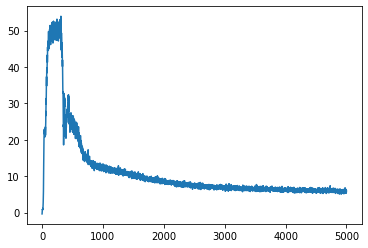

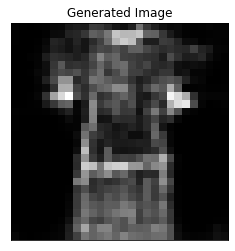

Iteration [5001/10000]......0.118(s) gen: 1.79029 - critic_fake: -1.09764 - critic_real: 4.92024 - neg_critic: 6.01788
Iteration [5002/10000]......0.114(s) gen: 1.80328 - critic_fake: -0.96609 - critic_real: 4.83355 - neg_critic: 5.79964
Iteration [5003/10000]......0.113(s) gen: 0.94368 - critic_fake: -1.13746 - critic_real: 4.89416 - neg_critic: 6.03162
Iteration [5004/10000]......0.114(s) gen: 0.84065 - critic_fake: -0.22258 - critic_real: 5.20116 - neg_critic: 5.42374
Iteration [5005/10000]......0.113(s) gen: 0.77048 - critic_fake: -0.76949 - critic_real: 5.66387 - neg_critic: 6.43336
Iteration [5006/10000]......0.113(s) gen: 1.05674 - critic_fake: -0.71670 - critic_real: 5.51487 - neg_critic: 6.23157
Iteration [5007/10000]......0.114(s) gen: 0.94070 - critic_fake: -1.32156 - critic_real: 4.81302 - neg_critic: 6.13459
Iteration [5008/10000]......0.115(s) gen: 0.31674 - critic_fake: -1.18323 - critic_real: 4.76053 - neg_critic: 5.94376
Iteration [5009/10000]......0.116(s) gen: 0.7881

Iteration [5070/10000]......0.117(s) gen: 0.62753 - critic_fake: -0.62711 - critic_real: 4.42930 - neg_critic: 5.05640
Iteration [5071/10000]......0.117(s) gen: 1.19008 - critic_fake: -1.12856 - critic_real: 4.66198 - neg_critic: 5.79053
Iteration [5072/10000]......0.117(s) gen: 0.83671 - critic_fake: -0.61215 - critic_real: 5.23909 - neg_critic: 5.85124
Iteration [5073/10000]......0.117(s) gen: 1.38227 - critic_fake: -0.42520 - critic_real: 5.13147 - neg_critic: 5.55667
Iteration [5074/10000]......0.116(s) gen: 0.56019 - critic_fake: -0.74082 - critic_real: 4.54034 - neg_critic: 5.28116
Iteration [5075/10000]......0.116(s) gen: 0.31584 - critic_fake: -0.80532 - critic_real: 4.96180 - neg_critic: 5.76712
Iteration [5076/10000]......0.114(s) gen: 1.39188 - critic_fake: -0.86148 - critic_real: 5.31254 - neg_critic: 6.17402
Iteration [5077/10000]......0.116(s) gen: 0.31076 - critic_fake: -0.90840 - critic_real: 4.46718 - neg_critic: 5.37558
Iteration [5078/10000]......0.117(s) gen: 0.5270

Iteration [5139/10000]......0.120(s) gen: 1.03881 - critic_fake: -1.12058 - critic_real: 4.37519 - neg_critic: 5.49577
Iteration [5140/10000]......0.120(s) gen: 1.83363 - critic_fake: -0.74521 - critic_real: 5.46718 - neg_critic: 6.21238
Iteration [5141/10000]......0.118(s) gen: 0.64441 - critic_fake: -1.18317 - critic_real: 4.74005 - neg_critic: 5.92322
Iteration [5142/10000]......0.119(s) gen: 1.55711 - critic_fake: -0.58373 - critic_real: 5.06189 - neg_critic: 5.64562
Iteration [5143/10000]......0.121(s) gen: 1.05959 - critic_fake: -1.54136 - critic_real: 4.16393 - neg_critic: 5.70530
Iteration [5144/10000]......0.119(s) gen: 1.23767 - critic_fake: -0.99528 - critic_real: 4.71437 - neg_critic: 5.70965
Iteration [5145/10000]......0.118(s) gen: 1.27494 - critic_fake: -1.21842 - critic_real: 4.75476 - neg_critic: 5.97318
Iteration [5146/10000]......0.119(s) gen: 1.19503 - critic_fake: -1.44614 - critic_real: 4.26081 - neg_critic: 5.70695
Iteration [5147/10000]......0.118(s) gen: 1.5785

Iteration [5208/10000]......0.116(s) gen: 2.18055 - critic_fake: -1.64905 - critic_real: 4.22430 - neg_critic: 5.87335
Iteration [5209/10000]......0.115(s) gen: 1.84294 - critic_fake: -2.19937 - critic_real: 3.51446 - neg_critic: 5.71383
Iteration [5210/10000]......0.116(s) gen: 3.22523 - critic_fake: -2.44759 - critic_real: 3.63618 - neg_critic: 6.08377
Iteration [5211/10000]......0.116(s) gen: 1.79359 - critic_fake: -1.84168 - critic_real: 3.64163 - neg_critic: 5.48331
Iteration [5212/10000]......0.117(s) gen: 2.07976 - critic_fake: -1.84497 - critic_real: 4.45245 - neg_critic: 6.29741
Iteration [5213/10000]......0.118(s) gen: 2.49809 - critic_fake: -1.86061 - critic_real: 4.25325 - neg_critic: 6.11387
Iteration [5214/10000]......0.117(s) gen: 1.40645 - critic_fake: -1.99621 - critic_real: 3.52478 - neg_critic: 5.52099
Iteration [5215/10000]......0.119(s) gen: 2.66751 - critic_fake: -2.20984 - critic_real: 3.46207 - neg_critic: 5.67191
Iteration [5216/10000]......0.119(s) gen: 2.2755

Iteration [5277/10000]......0.116(s) gen: 1.51172 - critic_fake: -1.35840 - critic_real: 4.47746 - neg_critic: 5.83586
Iteration [5278/10000]......0.116(s) gen: 1.75390 - critic_fake: -1.82465 - critic_real: 4.04199 - neg_critic: 5.86664
Iteration [5279/10000]......0.118(s) gen: 0.91017 - critic_fake: -1.17801 - critic_real: 4.14987 - neg_critic: 5.32788
Iteration [5280/10000]......0.118(s) gen: 1.25744 - critic_fake: -1.43432 - critic_real: 4.47263 - neg_critic: 5.90695
Iteration [5281/10000]......0.117(s) gen: 2.09364 - critic_fake: -1.46364 - critic_real: 4.04076 - neg_critic: 5.50440
Iteration [5282/10000]......0.116(s) gen: 1.77348 - critic_fake: -1.84714 - critic_real: 3.59695 - neg_critic: 5.44408
Iteration [5283/10000]......0.117(s) gen: 1.08441 - critic_fake: -1.21723 - critic_real: 4.89782 - neg_critic: 6.11504
Iteration [5284/10000]......0.116(s) gen: 1.51711 - critic_fake: -1.65054 - critic_real: 4.24142 - neg_critic: 5.89195
Iteration [5285/10000]......0.116(s) gen: 1.3569

Iteration [5346/10000]......0.117(s) gen: 2.52276 - critic_fake: -1.66398 - critic_real: 4.06787 - neg_critic: 5.73186
Iteration [5347/10000]......0.117(s) gen: 2.28319 - critic_fake: -2.08230 - critic_real: 3.81627 - neg_critic: 5.89857
Iteration [5348/10000]......0.118(s) gen: 1.47529 - critic_fake: -1.39694 - critic_real: 4.64242 - neg_critic: 6.03936
Iteration [5349/10000]......0.118(s) gen: 1.13601 - critic_fake: -1.70483 - critic_real: 4.43432 - neg_critic: 6.13915
Iteration [5350/10000]......0.118(s) gen: 2.09564 - critic_fake: -1.38919 - critic_real: 4.17642 - neg_critic: 5.56561
Iteration [5351/10000]......0.118(s) gen: 1.61167 - critic_fake: -1.56202 - critic_real: 4.15662 - neg_critic: 5.71863
Iteration [5352/10000]......0.118(s) gen: 2.18999 - critic_fake: -1.16249 - critic_real: 4.72708 - neg_critic: 5.88956
Iteration [5353/10000]......0.119(s) gen: 2.19822 - critic_fake: -1.85245 - critic_real: 4.55160 - neg_critic: 6.40404
Iteration [5354/10000]......0.116(s) gen: 1.8621

Iteration [5415/10000]......0.117(s) gen: 2.04905 - critic_fake: -1.66475 - critic_real: 4.57988 - neg_critic: 6.24463
Iteration [5416/10000]......0.116(s) gen: 1.35292 - critic_fake: -1.42914 - critic_real: 4.15880 - neg_critic: 5.58794
Iteration [5417/10000]......0.117(s) gen: 1.17546 - critic_fake: -1.14543 - critic_real: 3.78128 - neg_critic: 4.92671
Iteration [5418/10000]......0.116(s) gen: 2.23471 - critic_fake: -1.12808 - critic_real: 4.68395 - neg_critic: 5.81203
Iteration [5419/10000]......0.117(s) gen: 1.73274 - critic_fake: -1.41977 - critic_real: 4.40385 - neg_critic: 5.82362
Iteration [5420/10000]......0.118(s) gen: 2.62844 - critic_fake: -2.05473 - critic_real: 4.07803 - neg_critic: 6.13276
Iteration [5421/10000]......0.117(s) gen: 1.49138 - critic_fake: -1.95437 - critic_real: 3.96114 - neg_critic: 5.91551
Iteration [5422/10000]......0.120(s) gen: 2.03463 - critic_fake: -1.35022 - critic_real: 3.96863 - neg_critic: 5.31885
Iteration [5423/10000]......0.118(s) gen: 1.7448

Iteration [5484/10000]......0.119(s) gen: 1.66468 - critic_fake: -1.73031 - critic_real: 3.95745 - neg_critic: 5.68776
Iteration [5485/10000]......0.119(s) gen: 1.25371 - critic_fake: -1.75462 - critic_real: 3.80892 - neg_critic: 5.56354
Iteration [5486/10000]......0.120(s) gen: 1.95040 - critic_fake: -1.18644 - critic_real: 4.54498 - neg_critic: 5.73142
Iteration [5487/10000]......0.119(s) gen: 0.52242 - critic_fake: -1.14981 - critic_real: 4.39121 - neg_critic: 5.54102
Iteration [5488/10000]......0.119(s) gen: 1.38181 - critic_fake: -1.30544 - critic_real: 4.90729 - neg_critic: 6.21273
Iteration [5489/10000]......0.116(s) gen: 1.86984 - critic_fake: -1.60789 - critic_real: 4.56899 - neg_critic: 6.17688
Iteration [5490/10000]......0.116(s) gen: 2.45201 - critic_fake: -2.10160 - critic_real: 4.27604 - neg_critic: 6.37764
Iteration [5491/10000]......0.121(s) gen: 2.36587 - critic_fake: -1.91258 - critic_real: 3.60477 - neg_critic: 5.51735
Iteration [5492/10000]......0.120(s) gen: 2.5900

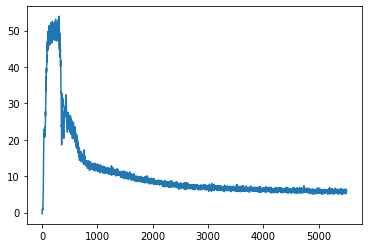

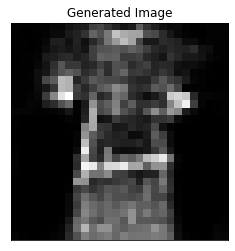

Iteration [5501/10000]......0.114(s) gen: 1.02736 - critic_fake: -1.28608 - critic_real: 4.18810 - neg_critic: 5.47418
Iteration [5502/10000]......0.112(s) gen: 2.25203 - critic_fake: -1.32459 - critic_real: 4.32766 - neg_critic: 5.65225
Iteration [5503/10000]......0.112(s) gen: 1.60017 - critic_fake: -1.78072 - critic_real: 4.20271 - neg_critic: 5.98343
Iteration [5504/10000]......0.112(s) gen: 1.66400 - critic_fake: -1.71693 - critic_real: 3.89362 - neg_critic: 5.61055
Iteration [5505/10000]......0.113(s) gen: 1.48160 - critic_fake: -1.29112 - critic_real: 4.74836 - neg_critic: 6.03948
Iteration [5506/10000]......0.116(s) gen: 1.75999 - critic_fake: -1.99170 - critic_real: 4.34258 - neg_critic: 6.33428
Iteration [5507/10000]......0.112(s) gen: 2.31296 - critic_fake: -1.72287 - critic_real: 3.43189 - neg_critic: 5.15476
Iteration [5508/10000]......0.113(s) gen: 1.91073 - critic_fake: -1.89564 - critic_real: 3.64875 - neg_critic: 5.54440
Iteration [5509/10000]......0.114(s) gen: 1.5332

Iteration [5570/10000]......0.118(s) gen: 2.20020 - critic_fake: -1.83934 - critic_real: 4.17618 - neg_critic: 6.01552
Iteration [5571/10000]......0.118(s) gen: 2.05032 - critic_fake: -1.96465 - critic_real: 3.81567 - neg_critic: 5.78032
Iteration [5572/10000]......0.119(s) gen: 1.56148 - critic_fake: -1.65464 - critic_real: 3.74686 - neg_critic: 5.40149
Iteration [5573/10000]......0.119(s) gen: 1.09041 - critic_fake: -1.52946 - critic_real: 4.26966 - neg_critic: 5.79912
Iteration [5574/10000]......0.119(s) gen: 2.64505 - critic_fake: -2.38007 - critic_real: 3.26459 - neg_critic: 5.64466
Iteration [5575/10000]......0.120(s) gen: 2.57938 - critic_fake: -2.49929 - critic_real: 3.44357 - neg_critic: 5.94286
Iteration [5576/10000]......0.120(s) gen: 1.62819 - critic_fake: -1.90587 - critic_real: 3.75433 - neg_critic: 5.66020
Iteration [5577/10000]......0.120(s) gen: 1.28810 - critic_fake: -1.11544 - critic_real: 4.40467 - neg_critic: 5.52011
Iteration [5578/10000]......0.116(s) gen: 0.8968

Iteration [5639/10000]......0.116(s) gen: 2.12092 - critic_fake: -1.56411 - critic_real: 4.14779 - neg_critic: 5.71190
Iteration [5640/10000]......0.117(s) gen: 1.16719 - critic_fake: -1.77356 - critic_real: 3.93247 - neg_critic: 5.70603
Iteration [5641/10000]......0.117(s) gen: 1.98803 - critic_fake: -1.33069 - critic_real: 3.97532 - neg_critic: 5.30601
Iteration [5642/10000]......0.117(s) gen: 1.52270 - critic_fake: -1.24336 - critic_real: 4.34341 - neg_critic: 5.58677
Iteration [5643/10000]......0.117(s) gen: 1.08202 - critic_fake: -1.08168 - critic_real: 4.84414 - neg_critic: 5.92582
Iteration [5644/10000]......0.115(s) gen: 1.17172 - critic_fake: -1.39496 - critic_real: 4.53943 - neg_critic: 5.93440
Iteration [5645/10000]......0.118(s) gen: 0.95014 - critic_fake: -1.11899 - critic_real: 4.35558 - neg_critic: 5.47458
Iteration [5646/10000]......0.117(s) gen: 0.73745 - critic_fake: -1.46224 - critic_real: 4.23551 - neg_critic: 5.69775
Iteration [5647/10000]......0.116(s) gen: 0.7722

Iteration [5708/10000]......0.116(s) gen: 1.66462 - critic_fake: -1.14854 - critic_real: 4.89708 - neg_critic: 6.04562
Iteration [5709/10000]......0.116(s) gen: 0.63375 - critic_fake: -1.35229 - critic_real: 4.31525 - neg_critic: 5.66754
Iteration [5710/10000]......0.116(s) gen: 1.87161 - critic_fake: -1.13050 - critic_real: 4.57510 - neg_critic: 5.70561
Iteration [5711/10000]......0.116(s) gen: 1.21516 - critic_fake: -1.53967 - critic_real: 4.23401 - neg_critic: 5.77368
Iteration [5712/10000]......0.118(s) gen: 1.40039 - critic_fake: -0.92905 - critic_real: 4.51926 - neg_critic: 5.44831
Iteration [5713/10000]......0.117(s) gen: 0.49097 - critic_fake: -1.28547 - critic_real: 4.27597 - neg_critic: 5.56144
Iteration [5714/10000]......0.115(s) gen: 1.63695 - critic_fake: -1.04582 - critic_real: 4.83220 - neg_critic: 5.87802
Iteration [5715/10000]......0.117(s) gen: 1.15927 - critic_fake: -1.44743 - critic_real: 4.15320 - neg_critic: 5.60063
Iteration [5716/10000]......0.118(s) gen: 1.3085

Iteration [5777/10000]......0.120(s) gen: 1.36634 - critic_fake: -1.06080 - critic_real: 4.77669 - neg_critic: 5.83749
Iteration [5778/10000]......0.120(s) gen: -0.09188 - critic_fake: -1.46471 - critic_real: 4.74073 - neg_critic: 6.20544
Iteration [5779/10000]......0.122(s) gen: 1.45150 - critic_fake: -0.57027 - critic_real: 5.32259 - neg_critic: 5.89286
Iteration [5780/10000]......0.121(s) gen: 1.14730 - critic_fake: -1.04362 - critic_real: 4.92078 - neg_critic: 5.96440
Iteration [5781/10000]......0.121(s) gen: 1.91091 - critic_fake: -1.54387 - critic_real: 4.26700 - neg_critic: 5.81087
Iteration [5782/10000]......0.119(s) gen: 1.62359 - critic_fake: -1.70814 - critic_real: 4.18863 - neg_critic: 5.89676
Iteration [5783/10000]......0.119(s) gen: 1.50817 - critic_fake: -1.30211 - critic_real: 4.87084 - neg_critic: 6.17295
Iteration [5784/10000]......0.119(s) gen: 1.12512 - critic_fake: -1.83763 - critic_real: 4.55649 - neg_critic: 6.39413
Iteration [5785/10000]......0.117(s) gen: 1.815

Iteration [5846/10000]......0.118(s) gen: 1.44969 - critic_fake: -1.48956 - critic_real: 3.93843 - neg_critic: 5.42798
Iteration [5847/10000]......0.120(s) gen: 1.51703 - critic_fake: -1.47444 - critic_real: 4.44920 - neg_critic: 5.92363
Iteration [5848/10000]......0.119(s) gen: 1.00796 - critic_fake: -1.18994 - critic_real: 4.46930 - neg_critic: 5.65924
Iteration [5849/10000]......0.120(s) gen: 1.69716 - critic_fake: -1.20019 - critic_real: 4.06492 - neg_critic: 5.26511
Iteration [5850/10000]......0.120(s) gen: 1.70743 - critic_fake: -1.51938 - critic_real: 4.11770 - neg_critic: 5.63708
Iteration [5851/10000]......0.118(s) gen: 1.71186 - critic_fake: -1.48995 - critic_real: 4.48213 - neg_critic: 5.97207
Iteration [5852/10000]......0.118(s) gen: 1.64310 - critic_fake: -1.37716 - critic_real: 4.61769 - neg_critic: 5.99484
Iteration [5853/10000]......0.117(s) gen: 1.09525 - critic_fake: -0.88059 - critic_real: 4.67323 - neg_critic: 5.55382
Iteration [5854/10000]......0.117(s) gen: 1.0176

Iteration [5915/10000]......0.121(s) gen: 0.31420 - critic_fake: -0.48882 - critic_real: 5.20979 - neg_critic: 5.69860
Iteration [5916/10000]......0.123(s) gen: 0.36961 - critic_fake: -0.43669 - critic_real: 5.64276 - neg_critic: 6.07945
Iteration [5917/10000]......0.122(s) gen: 0.26900 - critic_fake: -0.46917 - critic_real: 5.02012 - neg_critic: 5.48929
Iteration [5918/10000]......0.122(s) gen: 1.68207 - critic_fake: -0.91306 - critic_real: 5.29263 - neg_critic: 6.20569
Iteration [5919/10000]......0.122(s) gen: 0.46182 - critic_fake: -0.73052 - critic_real: 5.02529 - neg_critic: 5.75582
Iteration [5920/10000]......0.120(s) gen: 0.38738 - critic_fake: -0.26107 - critic_real: 5.27330 - neg_critic: 5.53437
Iteration [5921/10000]......0.121(s) gen: 0.12687 - critic_fake: -0.38322 - critic_real: 5.60353 - neg_critic: 5.98675
Iteration [5922/10000]......0.118(s) gen: 0.77999 - critic_fake: -0.93865 - critic_real: 5.26991 - neg_critic: 6.20856
Iteration [5923/10000]......0.118(s) gen: 0.7656

Iteration [5984/10000]......0.115(s) gen: 0.59451 - critic_fake: -1.15217 - critic_real: 4.69878 - neg_critic: 5.85095
Iteration [5985/10000]......0.116(s) gen: 1.03701 - critic_fake: -0.68181 - critic_real: 4.40301 - neg_critic: 5.08481
Iteration [5986/10000]......0.117(s) gen: 0.47326 - critic_fake: -1.02036 - critic_real: 4.66262 - neg_critic: 5.68298
Iteration [5987/10000]......0.117(s) gen: 0.79856 - critic_fake: -0.62377 - critic_real: 4.32824 - neg_critic: 4.95201
Iteration [5988/10000]......0.116(s) gen: 0.61161 - critic_fake: -1.14348 - critic_real: 4.75001 - neg_critic: 5.89348
Iteration [5989/10000]......0.118(s) gen: 0.75912 - critic_fake: -0.35485 - critic_real: 4.91412 - neg_critic: 5.26897
Iteration [5990/10000]......0.118(s) gen: 0.82645 - critic_fake: -1.06577 - critic_real: 4.88225 - neg_critic: 5.94802
Iteration [5991/10000]......0.119(s) gen: 1.89502 - critic_fake: -0.81899 - critic_real: 4.63471 - neg_critic: 5.45370
Iteration [5992/10000]......0.120(s) gen: 1.1000

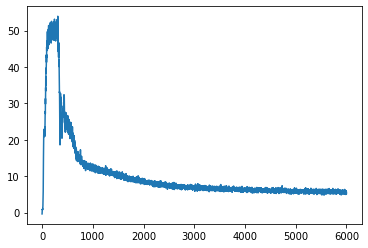

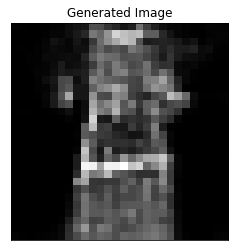

Iteration [6001/10000]......0.119(s) gen: 0.97307 - critic_fake: -1.00155 - critic_real: 4.46889 - neg_critic: 5.47044
Iteration [6002/10000]......0.116(s) gen: 1.43396 - critic_fake: -1.68556 - critic_real: 4.46185 - neg_critic: 6.14741
Iteration [6003/10000]......0.118(s) gen: 1.68459 - critic_fake: -1.40125 - critic_real: 3.75839 - neg_critic: 5.15963
Iteration [6004/10000]......0.115(s) gen: 1.64430 - critic_fake: -1.26072 - critic_real: 4.16949 - neg_critic: 5.43021
Iteration [6005/10000]......0.115(s) gen: 0.62927 - critic_fake: -1.15896 - critic_real: 4.54579 - neg_critic: 5.70475
Iteration [6006/10000]......0.114(s) gen: 1.30746 - critic_fake: -1.01507 - critic_real: 4.87284 - neg_critic: 5.88791
Iteration [6007/10000]......0.115(s) gen: 0.13154 - critic_fake: -0.40975 - critic_real: 4.92336 - neg_critic: 5.33311
Iteration [6008/10000]......0.118(s) gen: 0.59796 - critic_fake: -0.45234 - critic_real: 4.68271 - neg_critic: 5.13505
Iteration [6009/10000]......0.118(s) gen: 1.0711

Iteration [6070/10000]......0.119(s) gen: 1.72252 - critic_fake: -0.81091 - critic_real: 4.52760 - neg_critic: 5.33852
Iteration [6071/10000]......0.121(s) gen: 1.32883 - critic_fake: -1.05357 - critic_real: 4.38637 - neg_critic: 5.43995
Iteration [6072/10000]......0.119(s) gen: 0.91715 - critic_fake: -1.09957 - critic_real: 4.26037 - neg_critic: 5.35994
Iteration [6073/10000]......0.119(s) gen: 1.11749 - critic_fake: -0.80301 - critic_real: 4.41939 - neg_critic: 5.22240
Iteration [6074/10000]......0.119(s) gen: 0.84865 - critic_fake: -1.27550 - critic_real: 4.53829 - neg_critic: 5.81379
Iteration [6075/10000]......0.118(s) gen: 0.86069 - critic_fake: -1.21981 - critic_real: 4.39039 - neg_critic: 5.61020
Iteration [6076/10000]......0.117(s) gen: 1.24638 - critic_fake: -1.06680 - critic_real: 4.41165 - neg_critic: 5.47845
Iteration [6077/10000]......0.116(s) gen: 1.57970 - critic_fake: -1.54523 - critic_real: 4.24809 - neg_critic: 5.79331
Iteration [6078/10000]......0.116(s) gen: 1.4947

Iteration [6139/10000]......0.120(s) gen: 1.58762 - critic_fake: -1.26334 - critic_real: 4.23441 - neg_critic: 5.49775
Iteration [6140/10000]......0.121(s) gen: 1.13805 - critic_fake: -1.33410 - critic_real: 4.71259 - neg_critic: 6.04669
Iteration [6141/10000]......0.119(s) gen: 1.27906 - critic_fake: -1.14293 - critic_real: 4.43762 - neg_critic: 5.58055
Iteration [6142/10000]......0.120(s) gen: 0.15651 - critic_fake: -0.66888 - critic_real: 4.89457 - neg_critic: 5.56344
Iteration [6143/10000]......0.121(s) gen: 1.34659 - critic_fake: -0.81840 - critic_real: 4.88543 - neg_critic: 5.70383
Iteration [6144/10000]......0.121(s) gen: 1.11367 - critic_fake: -0.89447 - critic_real: 4.48413 - neg_critic: 5.37860
Iteration [6145/10000]......0.120(s) gen: 0.78665 - critic_fake: -1.16615 - critic_real: 4.74956 - neg_critic: 5.91571
Iteration [6146/10000]......0.120(s) gen: 1.78803 - critic_fake: -0.96153 - critic_real: 5.53021 - neg_critic: 6.49175
Iteration [6147/10000]......0.120(s) gen: 1.3471

Iteration [6208/10000]......0.117(s) gen: 0.90983 - critic_fake: -0.81094 - critic_real: 4.65070 - neg_critic: 5.46164
Iteration [6209/10000]......0.116(s) gen: -0.37796 - critic_fake: -0.45827 - critic_real: 4.93877 - neg_critic: 5.39705
Iteration [6210/10000]......0.118(s) gen: 0.16254 - critic_fake: -0.37881 - critic_real: 5.38331 - neg_critic: 5.76213
Iteration [6211/10000]......0.118(s) gen: 1.57187 - critic_fake: -0.83499 - critic_real: 4.91422 - neg_critic: 5.74921
Iteration [6212/10000]......0.116(s) gen: 0.83234 - critic_fake: -1.16692 - critic_real: 3.89388 - neg_critic: 5.06080
Iteration [6213/10000]......0.117(s) gen: 1.10179 - critic_fake: -1.03845 - critic_real: 4.73748 - neg_critic: 5.77593
Iteration [6214/10000]......0.117(s) gen: 1.50442 - critic_fake: -1.08100 - critic_real: 4.36901 - neg_critic: 5.45001
Iteration [6215/10000]......0.119(s) gen: 1.03296 - critic_fake: -0.91194 - critic_real: 4.29136 - neg_critic: 5.20330
Iteration [6216/10000]......0.118(s) gen: 1.656

Iteration [6277/10000]......0.119(s) gen: 1.49288 - critic_fake: -1.28665 - critic_real: 4.04009 - neg_critic: 5.32674
Iteration [6278/10000]......0.118(s) gen: 1.24485 - critic_fake: -1.34575 - critic_real: 4.44650 - neg_critic: 5.79225
Iteration [6279/10000]......0.118(s) gen: 1.06832 - critic_fake: -0.53829 - critic_real: 4.41962 - neg_critic: 4.95791
Iteration [6280/10000]......0.116(s) gen: 0.38449 - critic_fake: -0.77480 - critic_real: 4.30677 - neg_critic: 5.08157
Iteration [6281/10000]......0.115(s) gen: 1.20163 - critic_fake: -1.17652 - critic_real: 4.36577 - neg_critic: 5.54229
Iteration [6282/10000]......0.116(s) gen: 1.14923 - critic_fake: -1.52102 - critic_real: 4.68479 - neg_critic: 6.20580
Iteration [6283/10000]......0.117(s) gen: 0.74729 - critic_fake: -0.66313 - critic_real: 4.65196 - neg_critic: 5.31509
Iteration [6284/10000]......0.116(s) gen: 0.60236 - critic_fake: -0.92193 - critic_real: 4.32494 - neg_critic: 5.24688
Iteration [6285/10000]......0.117(s) gen: 0.5862

Iteration [6346/10000]......0.120(s) gen: 0.36963 - critic_fake: -0.51183 - critic_real: 4.65808 - neg_critic: 5.16991
Iteration [6347/10000]......0.118(s) gen: 1.11813 - critic_fake: -0.73296 - critic_real: 5.06265 - neg_critic: 5.79560
Iteration [6348/10000]......0.117(s) gen: 0.84896 - critic_fake: -0.47498 - critic_real: 4.69639 - neg_critic: 5.17137
Iteration [6349/10000]......0.114(s) gen: 0.26310 - critic_fake: -0.42831 - critic_real: 4.91194 - neg_critic: 5.34024
Iteration [6350/10000]......0.116(s) gen: 0.56003 - critic_fake: -0.61048 - critic_real: 4.97556 - neg_critic: 5.58604
Iteration [6351/10000]......0.117(s) gen: 0.35818 - critic_fake: -0.35759 - critic_real: 5.52237 - neg_critic: 5.87996
Iteration [6352/10000]......0.117(s) gen: 1.34528 - critic_fake: -0.14668 - critic_real: 4.72426 - neg_critic: 4.87094
Iteration [6353/10000]......0.117(s) gen: 1.42274 - critic_fake: -1.28851 - critic_real: 4.32555 - neg_critic: 5.61405
Iteration [6354/10000]......0.117(s) gen: 1.5970

Iteration [6415/10000]......0.118(s) gen: 0.74750 - critic_fake: -0.30137 - critic_real: 4.45493 - neg_critic: 4.75630
Iteration [6416/10000]......0.117(s) gen: 1.70537 - critic_fake: -0.82964 - critic_real: 4.77512 - neg_critic: 5.60475
Iteration [6417/10000]......0.117(s) gen: 1.72122 - critic_fake: -1.52588 - critic_real: 4.75190 - neg_critic: 6.27778
Iteration [6418/10000]......0.117(s) gen: 0.63304 - critic_fake: -0.69327 - critic_real: 4.91460 - neg_critic: 5.60787
Iteration [6419/10000]......0.117(s) gen: 1.07401 - critic_fake: -1.16365 - critic_real: 4.59200 - neg_critic: 5.75564
Iteration [6420/10000]......0.117(s) gen: 0.86148 - critic_fake: -1.06972 - critic_real: 4.54500 - neg_critic: 5.61472
Iteration [6421/10000]......0.117(s) gen: 0.76711 - critic_fake: -0.68796 - critic_real: 4.43466 - neg_critic: 5.12262
Iteration [6422/10000]......0.116(s) gen: 1.41981 - critic_fake: -1.16047 - critic_real: 4.30673 - neg_critic: 5.46720
Iteration [6423/10000]......0.117(s) gen: 0.9818

Iteration [6484/10000]......0.116(s) gen: 0.81060 - critic_fake: -1.23151 - critic_real: 4.45622 - neg_critic: 5.68773
Iteration [6485/10000]......0.117(s) gen: 1.37034 - critic_fake: -0.90743 - critic_real: 4.84344 - neg_critic: 5.75087
Iteration [6486/10000]......0.117(s) gen: 0.60963 - critic_fake: -1.06444 - critic_real: 4.33140 - neg_critic: 5.39584
Iteration [6487/10000]......0.118(s) gen: 1.91488 - critic_fake: -0.59284 - critic_real: 4.04388 - neg_critic: 4.63672
Iteration [6488/10000]......0.117(s) gen: 1.14442 - critic_fake: -1.16682 - critic_real: 4.52238 - neg_critic: 5.68920
Iteration [6489/10000]......0.118(s) gen: 0.73204 - critic_fake: -0.82690 - critic_real: 4.74832 - neg_critic: 5.57522
Iteration [6490/10000]......0.117(s) gen: 0.60547 - critic_fake: -0.68977 - critic_real: 4.56372 - neg_critic: 5.25349
Iteration [6491/10000]......0.118(s) gen: 1.17290 - critic_fake: -0.63410 - critic_real: 4.76681 - neg_critic: 5.40090
Iteration [6492/10000]......0.119(s) gen: 0.5051

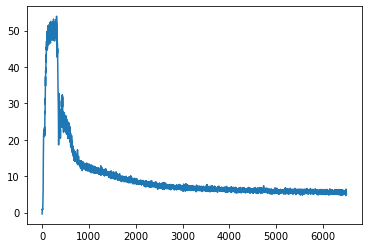

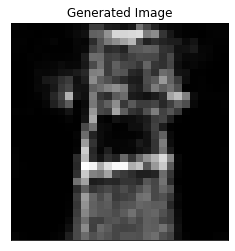

Iteration [6501/10000]......0.118(s) gen: 1.48408 - critic_fake: -1.12427 - critic_real: 4.07994 - neg_critic: 5.20421
Iteration [6502/10000]......0.114(s) gen: 1.01393 - critic_fake: -1.49965 - critic_real: 3.88895 - neg_critic: 5.38860
Iteration [6503/10000]......0.120(s) gen: 1.00290 - critic_fake: -1.03213 - critic_real: 4.41318 - neg_critic: 5.44531
Iteration [6504/10000]......0.116(s) gen: 0.65993 - critic_fake: -1.06395 - critic_real: 4.50336 - neg_critic: 5.56731
Iteration [6505/10000]......0.118(s) gen: 2.05317 - critic_fake: -1.32624 - critic_real: 4.70533 - neg_critic: 6.03157
Iteration [6506/10000]......0.115(s) gen: 1.09713 - critic_fake: -1.61137 - critic_real: 4.31463 - neg_critic: 5.92600
Iteration [6507/10000]......0.116(s) gen: 2.04911 - critic_fake: -1.65343 - critic_real: 3.92344 - neg_critic: 5.57687
Iteration [6508/10000]......0.117(s) gen: 1.02848 - critic_fake: -1.30606 - critic_real: 4.38843 - neg_critic: 5.69449
Iteration [6509/10000]......0.116(s) gen: 1.5313

Iteration [6570/10000]......0.117(s) gen: 1.11080 - critic_fake: -0.83961 - critic_real: 4.48610 - neg_critic: 5.32571
Iteration [6571/10000]......0.117(s) gen: 0.54289 - critic_fake: -0.93426 - critic_real: 4.37709 - neg_critic: 5.31135
Iteration [6572/10000]......0.119(s) gen: 1.40989 - critic_fake: -0.83420 - critic_real: 4.85226 - neg_critic: 5.68646
Iteration [6573/10000]......0.119(s) gen: 1.27131 - critic_fake: -1.35667 - critic_real: 4.44905 - neg_critic: 5.80572
Iteration [6574/10000]......0.118(s) gen: 1.53675 - critic_fake: -1.68946 - critic_real: 4.14378 - neg_critic: 5.83324
Iteration [6575/10000]......0.119(s) gen: 1.42230 - critic_fake: -1.40940 - critic_real: 4.17098 - neg_critic: 5.58039
Iteration [6576/10000]......0.119(s) gen: 2.08175 - critic_fake: -1.59908 - critic_real: 3.46624 - neg_critic: 5.06532
Iteration [6577/10000]......0.120(s) gen: 1.60971 - critic_fake: -2.14339 - critic_real: 3.54093 - neg_critic: 5.68433
Iteration [6578/10000]......0.120(s) gen: 1.7363

Iteration [6639/10000]......0.117(s) gen: 1.32719 - critic_fake: -1.20219 - critic_real: 4.05707 - neg_critic: 5.25926
Iteration [6640/10000]......0.117(s) gen: 1.80007 - critic_fake: -1.39158 - critic_real: 3.55817 - neg_critic: 4.94975
Iteration [6641/10000]......0.118(s) gen: 1.18608 - critic_fake: -1.73031 - critic_real: 3.86084 - neg_critic: 5.59115
Iteration [6642/10000]......0.120(s) gen: 1.15606 - critic_fake: -0.94725 - critic_real: 4.84841 - neg_critic: 5.79566
Iteration [6643/10000]......0.120(s) gen: 0.88153 - critic_fake: -0.62375 - critic_real: 4.25016 - neg_critic: 4.87391
Iteration [6644/10000]......0.119(s) gen: 0.82832 - critic_fake: -0.56370 - critic_real: 5.11055 - neg_critic: 5.67425
Iteration [6645/10000]......0.122(s) gen: 1.18192 - critic_fake: -1.15871 - critic_real: 4.55944 - neg_critic: 5.71815
Iteration [6646/10000]......0.119(s) gen: 1.67544 - critic_fake: -0.99666 - critic_real: 4.16852 - neg_critic: 5.16518
Iteration [6647/10000]......0.120(s) gen: 2.1535

Iteration [6708/10000]......0.120(s) gen: 1.08686 - critic_fake: -1.37655 - critic_real: 4.42525 - neg_critic: 5.80180
Iteration [6709/10000]......0.119(s) gen: 1.90749 - critic_fake: -1.58543 - critic_real: 3.89514 - neg_critic: 5.48056
Iteration [6710/10000]......0.119(s) gen: 2.18859 - critic_fake: -1.41963 - critic_real: 3.78382 - neg_critic: 5.20345
Iteration [6711/10000]......0.117(s) gen: 1.82552 - critic_fake: -1.52176 - critic_real: 4.00325 - neg_critic: 5.52500
Iteration [6712/10000]......0.117(s) gen: 1.14640 - critic_fake: -0.91165 - critic_real: 4.64469 - neg_critic: 5.55634
Iteration [6713/10000]......0.117(s) gen: 0.76449 - critic_fake: -0.92307 - critic_real: 4.49343 - neg_critic: 5.41649
Iteration [6714/10000]......0.117(s) gen: 0.71220 - critic_fake: -0.90362 - critic_real: 3.95205 - neg_critic: 4.85568
Iteration [6715/10000]......0.117(s) gen: 1.01544 - critic_fake: -0.94071 - critic_real: 4.51778 - neg_critic: 5.45849
Iteration [6716/10000]......0.115(s) gen: 0.6509

Iteration [6777/10000]......0.118(s) gen: 1.96299 - critic_fake: -1.46505 - critic_real: 3.69646 - neg_critic: 5.16152
Iteration [6778/10000]......0.118(s) gen: 1.79648 - critic_fake: -1.97012 - critic_real: 3.55456 - neg_critic: 5.52468
Iteration [6779/10000]......0.119(s) gen: 1.25665 - critic_fake: -1.30463 - critic_real: 4.04299 - neg_critic: 5.34762
Iteration [6780/10000]......0.120(s) gen: 2.21801 - critic_fake: -1.74692 - critic_real: 4.18979 - neg_critic: 5.93670
Iteration [6781/10000]......0.119(s) gen: 2.11248 - critic_fake: -1.82125 - critic_real: 3.87157 - neg_critic: 5.69282
Iteration [6782/10000]......0.118(s) gen: 1.68072 - critic_fake: -1.68840 - critic_real: 3.87853 - neg_critic: 5.56694
Iteration [6783/10000]......0.118(s) gen: 2.17577 - critic_fake: -1.99294 - critic_real: 3.43852 - neg_critic: 5.43146
Iteration [6784/10000]......0.115(s) gen: 2.06464 - critic_fake: -1.84433 - critic_real: 3.10133 - neg_critic: 4.94566
Iteration [6785/10000]......0.116(s) gen: 0.2328

Iteration [6846/10000]......0.114(s) gen: 1.49781 - critic_fake: -0.85077 - critic_real: 4.77707 - neg_critic: 5.62784
Iteration [6847/10000]......0.115(s) gen: 0.24326 - critic_fake: -0.80344 - critic_real: 4.10796 - neg_critic: 4.91140
Iteration [6848/10000]......0.115(s) gen: 1.35796 - critic_fake: -0.69275 - critic_real: 4.58004 - neg_critic: 5.27279
Iteration [6849/10000]......0.116(s) gen: 1.09485 - critic_fake: -1.65231 - critic_real: 3.96259 - neg_critic: 5.61491
Iteration [6850/10000]......0.116(s) gen: 1.51017 - critic_fake: -1.25775 - critic_real: 3.87221 - neg_critic: 5.12996
Iteration [6851/10000]......0.117(s) gen: 1.38273 - critic_fake: -1.77137 - critic_real: 4.08919 - neg_critic: 5.86056
Iteration [6852/10000]......0.115(s) gen: 1.67025 - critic_fake: -1.37373 - critic_real: 3.71205 - neg_critic: 5.08578
Iteration [6853/10000]......0.115(s) gen: 1.61380 - critic_fake: -1.16948 - critic_real: 5.09558 - neg_critic: 6.26506
Iteration [6854/10000]......0.117(s) gen: 0.9864

Iteration [6915/10000]......0.119(s) gen: 0.25616 - critic_fake: -0.54384 - critic_real: 4.78432 - neg_critic: 5.32816
Iteration [6916/10000]......0.118(s) gen: 0.98300 - critic_fake: -0.75904 - critic_real: 4.79751 - neg_critic: 5.55655
Iteration [6917/10000]......0.117(s) gen: 1.15418 - critic_fake: -1.09991 - critic_real: 4.03464 - neg_critic: 5.13455
Iteration [6918/10000]......0.117(s) gen: 1.14434 - critic_fake: -0.75875 - critic_real: 4.37377 - neg_critic: 5.13252
Iteration [6919/10000]......0.118(s) gen: 1.13426 - critic_fake: -1.17232 - critic_real: 4.37312 - neg_critic: 5.54544
Iteration [6920/10000]......0.118(s) gen: 0.98862 - critic_fake: -1.12206 - critic_real: 4.09806 - neg_critic: 5.22012
Iteration [6921/10000]......0.118(s) gen: 1.06251 - critic_fake: -0.54466 - critic_real: 4.75675 - neg_critic: 5.30141
Iteration [6922/10000]......0.119(s) gen: 0.90133 - critic_fake: -0.81874 - critic_real: 4.81619 - neg_critic: 5.63494
Iteration [6923/10000]......0.118(s) gen: 1.0650

Iteration [6984/10000]......0.117(s) gen: 1.41719 - critic_fake: -0.67011 - critic_real: 4.74498 - neg_critic: 5.41510
Iteration [6985/10000]......0.117(s) gen: 1.16798 - critic_fake: -1.56509 - critic_real: 4.14013 - neg_critic: 5.70522
Iteration [6986/10000]......0.118(s) gen: 1.28546 - critic_fake: -1.67454 - critic_real: 3.75945 - neg_critic: 5.43399
Iteration [6987/10000]......0.118(s) gen: 1.56434 - critic_fake: -1.35696 - critic_real: 4.28751 - neg_critic: 5.64447
Iteration [6988/10000]......0.118(s) gen: 1.05238 - critic_fake: -1.29263 - critic_real: 4.24158 - neg_critic: 5.53421
Iteration [6989/10000]......0.116(s) gen: 1.45179 - critic_fake: -1.80472 - critic_real: 4.11785 - neg_critic: 5.92257
Iteration [6990/10000]......0.117(s) gen: 1.20166 - critic_fake: -1.46213 - critic_real: 3.90821 - neg_critic: 5.37034
Iteration [6991/10000]......0.117(s) gen: 0.38724 - critic_fake: -1.34678 - critic_real: 4.66464 - neg_critic: 6.01141
Iteration [6992/10000]......0.118(s) gen: 1.3400

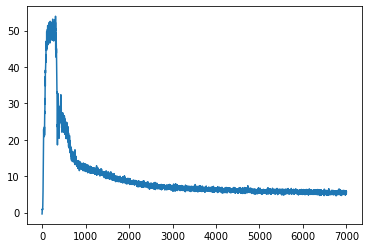

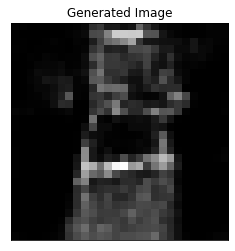

Iteration [7001/10000]......0.112(s) gen: 0.41012 - critic_fake: -0.71866 - critic_real: 4.55262 - neg_critic: 5.27128
Iteration [7002/10000]......0.114(s) gen: -0.08084 - critic_fake: -0.56041 - critic_real: 5.04954 - neg_critic: 5.60995
Iteration [7003/10000]......0.116(s) gen: 0.86205 - critic_fake: -0.60127 - critic_real: 4.99519 - neg_critic: 5.59646
Iteration [7004/10000]......0.115(s) gen: 1.14271 - critic_fake: -0.90663 - critic_real: 4.24878 - neg_critic: 5.15542
Iteration [7005/10000]......0.113(s) gen: 1.30082 - critic_fake: -1.04284 - critic_real: 4.69230 - neg_critic: 5.73514
Iteration [7006/10000]......0.115(s) gen: 1.52677 - critic_fake: -1.15565 - critic_real: 3.60282 - neg_critic: 4.75847
Iteration [7007/10000]......0.114(s) gen: 1.22961 - critic_fake: -1.00336 - critic_real: 4.22560 - neg_critic: 5.22896
Iteration [7008/10000]......0.115(s) gen: 0.94911 - critic_fake: -0.93187 - critic_real: 4.39699 - neg_critic: 5.32886
Iteration [7009/10000]......0.117(s) gen: 1.338

Iteration [7070/10000]......0.114(s) gen: 1.23432 - critic_fake: -1.40637 - critic_real: 3.92892 - neg_critic: 5.33529
Iteration [7071/10000]......0.113(s) gen: 1.64512 - critic_fake: -1.12187 - critic_real: 4.56279 - neg_critic: 5.68466
Iteration [7072/10000]......0.114(s) gen: 2.14861 - critic_fake: -1.62065 - critic_real: 3.86446 - neg_critic: 5.48511
Iteration [7073/10000]......0.112(s) gen: 1.34217 - critic_fake: -1.00374 - critic_real: 4.07000 - neg_critic: 5.07374
Iteration [7074/10000]......0.114(s) gen: 1.57900 - critic_fake: -1.04993 - critic_real: 4.77490 - neg_critic: 5.82483
Iteration [7075/10000]......0.114(s) gen: 0.27558 - critic_fake: -0.97811 - critic_real: 4.19570 - neg_critic: 5.17381
Iteration [7076/10000]......0.117(s) gen: 1.51791 - critic_fake: -0.98909 - critic_real: 4.61838 - neg_critic: 5.60747
Iteration [7077/10000]......0.115(s) gen: 1.21335 - critic_fake: -1.56286 - critic_real: 4.61380 - neg_critic: 6.17666
Iteration [7078/10000]......0.117(s) gen: 0.4996

Iteration [7140/10000]......0.121(s) gen: 0.20950 - critic_fake: -0.72515 - critic_real: 4.77592 - neg_critic: 5.50107
Iteration [7141/10000]......0.120(s) gen: 0.73877 - critic_fake: -0.27590 - critic_real: 4.39238 - neg_critic: 4.66828
Iteration [7142/10000]......0.118(s) gen: 1.02249 - critic_fake: -0.96045 - critic_real: 4.35819 - neg_critic: 5.31864
Iteration [7143/10000]......0.119(s) gen: 1.84966 - critic_fake: -1.34059 - critic_real: 3.99087 - neg_critic: 5.33146
Iteration [7144/10000]......0.119(s) gen: 1.66857 - critic_fake: -1.44688 - critic_real: 3.90278 - neg_critic: 5.34966
Iteration [7145/10000]......0.117(s) gen: 1.25319 - critic_fake: -1.24117 - critic_real: 4.01882 - neg_critic: 5.25999
Iteration [7146/10000]......0.118(s) gen: 2.11728 - critic_fake: -0.94337 - critic_real: 4.34615 - neg_critic: 5.28951
Iteration [7147/10000]......0.117(s) gen: 1.24209 - critic_fake: -1.64919 - critic_real: 3.87103 - neg_critic: 5.52022
Iteration [7148/10000]......0.119(s) gen: 1.6653

Iteration [7210/10000]......0.116(s) gen: 1.37421 - critic_fake: -1.49996 - critic_real: 4.23583 - neg_critic: 5.73579
Iteration [7211/10000]......0.114(s) gen: 0.98244 - critic_fake: -1.22063 - critic_real: 4.10614 - neg_critic: 5.32677
Iteration [7212/10000]......0.116(s) gen: 1.11589 - critic_fake: -1.03708 - critic_real: 4.45217 - neg_critic: 5.48925
Iteration [7213/10000]......0.117(s) gen: 2.08501 - critic_fake: -1.36457 - critic_real: 3.63038 - neg_critic: 4.99495
Iteration [7214/10000]......0.116(s) gen: 0.66547 - critic_fake: -1.44410 - critic_real: 4.19011 - neg_critic: 5.63421
Iteration [7215/10000]......0.117(s) gen: 1.40408 - critic_fake: -1.01574 - critic_real: 4.28334 - neg_critic: 5.29908
Iteration [7216/10000]......0.117(s) gen: 0.89154 - critic_fake: -1.29204 - critic_real: 4.25150 - neg_critic: 5.54354
Iteration [7217/10000]......0.116(s) gen: 1.35007 - critic_fake: -1.13235 - critic_real: 4.28476 - neg_critic: 5.41711
Iteration [7218/10000]......0.117(s) gen: 1.2531

Iteration [7280/10000]......0.116(s) gen: 1.42889 - critic_fake: -1.02577 - critic_real: 4.49107 - neg_critic: 5.51684
Iteration [7281/10000]......0.115(s) gen: 1.67339 - critic_fake: -1.19397 - critic_real: 3.94903 - neg_critic: 5.14300
Iteration [7282/10000]......0.117(s) gen: 0.82621 - critic_fake: -1.76474 - critic_real: 3.72391 - neg_critic: 5.48866
Iteration [7283/10000]......0.118(s) gen: 0.81245 - critic_fake: -0.90672 - critic_real: 4.27776 - neg_critic: 5.18448
Iteration [7284/10000]......0.118(s) gen: 0.77835 - critic_fake: -0.46472 - critic_real: 4.83139 - neg_critic: 5.29611
Iteration [7285/10000]......0.118(s) gen: 0.42214 - critic_fake: -0.59024 - critic_real: 4.66541 - neg_critic: 5.25565
Iteration [7286/10000]......0.119(s) gen: 0.88656 - critic_fake: -0.43521 - critic_real: 5.34462 - neg_critic: 5.77983
Iteration [7287/10000]......0.120(s) gen: 1.16381 - critic_fake: -0.90912 - critic_real: 3.86679 - neg_critic: 4.77592
Iteration [7288/10000]......0.120(s) gen: 1.8719

Iteration [7350/10000]......0.122(s) gen: 1.10100 - critic_fake: -1.07838 - critic_real: 4.32666 - neg_critic: 5.40505
Iteration [7351/10000]......0.120(s) gen: 0.89864 - critic_fake: -1.02098 - critic_real: 3.81928 - neg_critic: 4.84026
Iteration [7352/10000]......0.120(s) gen: 1.49841 - critic_fake: -1.03762 - critic_real: 4.06204 - neg_critic: 5.09966
Iteration [7353/10000]......0.119(s) gen: 0.44230 - critic_fake: -0.93754 - critic_real: 4.85583 - neg_critic: 5.79337
Iteration [7354/10000]......0.118(s) gen: 1.16856 - critic_fake: -0.57437 - critic_real: 4.78723 - neg_critic: 5.36160
Iteration [7355/10000]......0.117(s) gen: 1.09972 - critic_fake: -0.99468 - critic_real: 4.27200 - neg_critic: 5.26668
Iteration [7356/10000]......0.117(s) gen: 0.79194 - critic_fake: -1.16288 - critic_real: 3.98407 - neg_critic: 5.14696
Iteration [7357/10000]......0.117(s) gen: 1.41215 - critic_fake: -0.85456 - critic_real: 4.59478 - neg_critic: 5.44933
Iteration [7358/10000]......0.120(s) gen: 1.3154

Iteration [7420/10000]......0.121(s) gen: 0.73555 - critic_fake: -0.84679 - critic_real: 4.19601 - neg_critic: 5.04280
Iteration [7421/10000]......0.120(s) gen: 1.46589 - critic_fake: -0.61656 - critic_real: 4.58931 - neg_critic: 5.20588
Iteration [7422/10000]......0.120(s) gen: 1.79705 - critic_fake: -1.09124 - critic_real: 4.31912 - neg_critic: 5.41036
Iteration [7423/10000]......0.119(s) gen: 1.41488 - critic_fake: -1.24842 - critic_real: 4.15569 - neg_critic: 5.40411
Iteration [7424/10000]......0.118(s) gen: 1.48123 - critic_fake: -1.36566 - critic_real: 3.71172 - neg_critic: 5.07738
Iteration [7425/10000]......0.118(s) gen: 1.40152 - critic_fake: -1.02494 - critic_real: 4.33419 - neg_critic: 5.35913
Iteration [7426/10000]......0.119(s) gen: 1.54549 - critic_fake: -1.22974 - critic_real: 3.84887 - neg_critic: 5.07860
Iteration [7427/10000]......0.117(s) gen: 1.08631 - critic_fake: -1.38117 - critic_real: 3.66623 - neg_critic: 5.04740
Iteration [7428/10000]......0.119(s) gen: 1.6128

Iteration [7490/10000]......0.117(s) gen: 1.64443 - critic_fake: -0.88941 - critic_real: 4.52337 - neg_critic: 5.41278
Iteration [7491/10000]......0.118(s) gen: 0.14544 - critic_fake: -0.78933 - critic_real: 4.60450 - neg_critic: 5.39384
Iteration [7492/10000]......0.119(s) gen: 1.31452 - critic_fake: -0.76742 - critic_real: 4.52898 - neg_critic: 5.29641
Iteration [7493/10000]......0.118(s) gen: 1.56609 - critic_fake: -1.07165 - critic_real: 4.62984 - neg_critic: 5.70149
Iteration [7494/10000]......0.119(s) gen: 0.89110 - critic_fake: -1.16391 - critic_real: 4.04465 - neg_critic: 5.20855
Iteration [7495/10000]......0.119(s) gen: 1.10578 - critic_fake: -1.06923 - critic_real: 4.49853 - neg_critic: 5.56776
Iteration [7496/10000]......0.118(s) gen: 1.02819 - critic_fake: -0.95889 - critic_real: 4.38322 - neg_critic: 5.34210
Iteration [7497/10000]......0.118(s) gen: 0.37389 - critic_fake: -0.65720 - critic_real: 4.75351 - neg_critic: 5.41072
Iteration [7498/10000]......0.117(s) gen: 1.0354

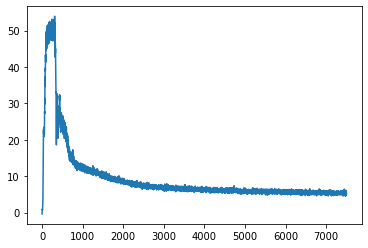

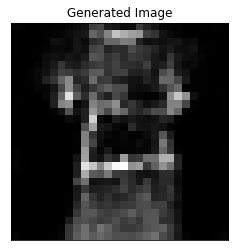

Iteration [7501/10000]......0.117(s) gen: 1.11767 - critic_fake: -0.96263 - critic_real: 4.12049 - neg_critic: 5.08312
Iteration [7502/10000]......0.112(s) gen: 1.21059 - critic_fake: -1.46829 - critic_real: 3.47051 - neg_critic: 4.93880
Iteration [7503/10000]......0.114(s) gen: 1.78651 - critic_fake: -1.59020 - critic_real: 4.53156 - neg_critic: 6.12176
Iteration [7504/10000]......0.113(s) gen: 0.63696 - critic_fake: -0.64545 - critic_real: 3.85155 - neg_critic: 4.49701
Iteration [7505/10000]......0.113(s) gen: 1.12381 - critic_fake: -0.70920 - critic_real: 4.73763 - neg_critic: 5.44684
Iteration [7506/10000]......0.114(s) gen: 0.50578 - critic_fake: -1.02926 - critic_real: 4.41572 - neg_critic: 5.44498
Iteration [7507/10000]......0.114(s) gen: 1.10336 - critic_fake: -0.84728 - critic_real: 4.20417 - neg_critic: 5.05145
Iteration [7508/10000]......0.114(s) gen: 1.11780 - critic_fake: -1.23031 - critic_real: 4.26401 - neg_critic: 5.49432
Iteration [7509/10000]......0.115(s) gen: 0.7234

Iteration [7570/10000]......0.117(s) gen: 0.50227 - critic_fake: -0.31413 - critic_real: 4.45905 - neg_critic: 4.77317
Iteration [7571/10000]......0.117(s) gen: 0.47014 - critic_fake: -0.41369 - critic_real: 4.67491 - neg_critic: 5.08860
Iteration [7572/10000]......0.116(s) gen: 0.46826 - critic_fake: -0.51165 - critic_real: 4.97492 - neg_critic: 5.48657
Iteration [7573/10000]......0.115(s) gen: 0.66104 - critic_fake: -0.59078 - critic_real: 4.58968 - neg_critic: 5.18045
Iteration [7574/10000]......0.115(s) gen: 0.61831 - critic_fake: -0.80072 - critic_real: 4.53415 - neg_critic: 5.33486
Iteration [7575/10000]......0.116(s) gen: 0.34002 - critic_fake: -0.83786 - critic_real: 4.61178 - neg_critic: 5.44964
Iteration [7576/10000]......0.118(s) gen: 0.94557 - critic_fake: -0.51693 - critic_real: 5.19499 - neg_critic: 5.71192
Iteration [7577/10000]......0.118(s) gen: 0.95121 - critic_fake: -0.64428 - critic_real: 4.78382 - neg_critic: 5.42810
Iteration [7578/10000]......0.118(s) gen: 0.6673

Iteration [7639/10000]......0.120(s) gen: 0.37596 - critic_fake: -0.79257 - critic_real: 4.45037 - neg_critic: 5.24293
Iteration [7640/10000]......0.120(s) gen: 1.47808 - critic_fake: -1.28381 - critic_real: 4.41850 - neg_critic: 5.70231
Iteration [7641/10000]......0.119(s) gen: 1.82216 - critic_fake: -1.47713 - critic_real: 3.55026 - neg_critic: 5.02739
Iteration [7642/10000]......0.120(s) gen: 1.18844 - critic_fake: -1.04846 - critic_real: 4.11032 - neg_critic: 5.15878
Iteration [7643/10000]......0.121(s) gen: 0.86574 - critic_fake: -1.26858 - critic_real: 4.61515 - neg_critic: 5.88374
Iteration [7644/10000]......0.120(s) gen: 0.48812 - critic_fake: -0.72289 - critic_real: 4.33040 - neg_critic: 5.05329
Iteration [7645/10000]......0.120(s) gen: 1.27359 - critic_fake: -1.25494 - critic_real: 4.02157 - neg_critic: 5.27651
Iteration [7646/10000]......0.120(s) gen: 2.25674 - critic_fake: -1.41010 - critic_real: 4.22633 - neg_critic: 5.63643
Iteration [7647/10000]......0.119(s) gen: 0.6074

Iteration [7708/10000]......0.117(s) gen: 1.51798 - critic_fake: -1.07840 - critic_real: 4.52414 - neg_critic: 5.60254
Iteration [7709/10000]......0.118(s) gen: 0.78615 - critic_fake: -1.32508 - critic_real: 3.84141 - neg_critic: 5.16649
Iteration [7710/10000]......0.118(s) gen: 1.17558 - critic_fake: -0.78207 - critic_real: 3.89981 - neg_critic: 4.68189
Iteration [7711/10000]......0.118(s) gen: 0.08831 - critic_fake: -0.72931 - critic_real: 4.67413 - neg_critic: 5.40345
Iteration [7712/10000]......0.119(s) gen: 0.91264 - critic_fake: -0.15325 - critic_real: 4.75834 - neg_critic: 4.91159
Iteration [7713/10000]......0.118(s) gen: 1.45104 - critic_fake: -0.61047 - critic_real: 4.69887 - neg_critic: 5.30934
Iteration [7714/10000]......0.119(s) gen: 0.67534 - critic_fake: -0.83839 - critic_real: 4.65945 - neg_critic: 5.49784
Iteration [7715/10000]......0.121(s) gen: 1.29058 - critic_fake: -0.94217 - critic_real: 4.65930 - neg_critic: 5.60146
Iteration [7716/10000]......0.121(s) gen: 1.1122

Iteration [7777/10000]......0.116(s) gen: 1.08828 - critic_fake: -0.48806 - critic_real: 4.62208 - neg_critic: 5.11014
Iteration [7778/10000]......0.118(s) gen: 1.17346 - critic_fake: -0.74691 - critic_real: 4.79884 - neg_critic: 5.54574
Iteration [7779/10000]......0.118(s) gen: 0.58692 - critic_fake: -0.58970 - critic_real: 4.77602 - neg_critic: 5.36572
Iteration [7780/10000]......0.120(s) gen: 0.51155 - critic_fake: -0.59523 - critic_real: 4.75594 - neg_critic: 5.35117
Iteration [7781/10000]......0.119(s) gen: 0.97383 - critic_fake: -0.65210 - critic_real: 4.68913 - neg_critic: 5.34123
Iteration [7782/10000]......0.120(s) gen: 1.02424 - critic_fake: -0.90434 - critic_real: 4.39165 - neg_critic: 5.29599
Iteration [7783/10000]......0.121(s) gen: 1.52875 - critic_fake: -1.02729 - critic_real: 4.30514 - neg_critic: 5.33242
Iteration [7784/10000]......0.121(s) gen: 1.22118 - critic_fake: -1.45906 - critic_real: 4.41436 - neg_critic: 5.87342
Iteration [7785/10000]......0.120(s) gen: 0.8284

Iteration [7846/10000]......0.120(s) gen: 0.30235 - critic_fake: -0.18893 - critic_real: 5.00006 - neg_critic: 5.18899
Iteration [7847/10000]......0.118(s) gen: 0.87364 - critic_fake: -0.41490 - critic_real: 4.80687 - neg_critic: 5.22177
Iteration [7848/10000]......0.119(s) gen: 1.21474 - critic_fake: -0.74412 - critic_real: 4.44206 - neg_critic: 5.18618
Iteration [7849/10000]......0.119(s) gen: 1.01636 - critic_fake: -0.95514 - critic_real: 4.22351 - neg_critic: 5.17864
Iteration [7850/10000]......0.119(s) gen: 0.84110 - critic_fake: -0.83113 - critic_real: 4.69535 - neg_critic: 5.52648
Iteration [7851/10000]......0.118(s) gen: 0.54008 - critic_fake: -0.88373 - critic_real: 4.67406 - neg_critic: 5.55779
Iteration [7852/10000]......0.120(s) gen: 0.28333 - critic_fake: -0.22125 - critic_real: 4.99512 - neg_critic: 5.21637
Iteration [7853/10000]......0.119(s) gen: 0.57540 - critic_fake: -0.03349 - critic_real: 5.37268 - neg_critic: 5.40617
Iteration [7854/10000]......0.119(s) gen: 0.2087

Iteration [7915/10000]......0.116(s) gen: 0.97252 - critic_fake: -0.94329 - critic_real: 4.18450 - neg_critic: 5.12779
Iteration [7916/10000]......0.118(s) gen: 0.82469 - critic_fake: -0.53642 - critic_real: 4.76300 - neg_critic: 5.29942
Iteration [7917/10000]......0.117(s) gen: 1.14806 - critic_fake: -0.72197 - critic_real: 4.02788 - neg_critic: 4.74985
Iteration [7918/10000]......0.119(s) gen: 1.74851 - critic_fake: -0.78843 - critic_real: 4.58418 - neg_critic: 5.37261
Iteration [7919/10000]......0.119(s) gen: 1.26223 - critic_fake: -1.15469 - critic_real: 4.00406 - neg_critic: 5.15876
Iteration [7920/10000]......0.119(s) gen: 1.16420 - critic_fake: -1.13852 - critic_real: 4.28252 - neg_critic: 5.42104
Iteration [7921/10000]......0.119(s) gen: 1.21052 - critic_fake: -1.11547 - critic_real: 3.94084 - neg_critic: 5.05630
Iteration [7922/10000]......0.120(s) gen: 0.64401 - critic_fake: -1.12203 - critic_real: 4.23631 - neg_critic: 5.35834
Iteration [7923/10000]......0.119(s) gen: 0.8443

Iteration [7984/10000]......0.117(s) gen: 1.48676 - critic_fake: -1.27406 - critic_real: 3.85968 - neg_critic: 5.13374
Iteration [7985/10000]......0.118(s) gen: 0.44197 - critic_fake: -0.87762 - critic_real: 4.44536 - neg_critic: 5.32298
Iteration [7986/10000]......0.117(s) gen: 0.63956 - critic_fake: -0.55711 - critic_real: 4.51890 - neg_critic: 5.07601
Iteration [7987/10000]......0.117(s) gen: 0.64030 - critic_fake: -0.52927 - critic_real: 4.84372 - neg_critic: 5.37299
Iteration [7988/10000]......0.118(s) gen: 1.17292 - critic_fake: -0.54383 - critic_real: 4.62807 - neg_critic: 5.17190
Iteration [7989/10000]......0.118(s) gen: 1.61969 - critic_fake: -1.13501 - critic_real: 4.32573 - neg_critic: 5.46074
Iteration [7990/10000]......0.118(s) gen: 1.33243 - critic_fake: -1.09144 - critic_real: 3.61974 - neg_critic: 4.71118
Iteration [7991/10000]......0.120(s) gen: 1.19303 - critic_fake: -1.10658 - critic_real: 3.68605 - neg_critic: 4.79263
Iteration [7992/10000]......0.119(s) gen: 1.1085

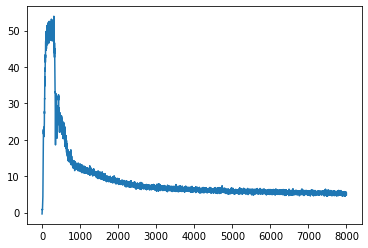

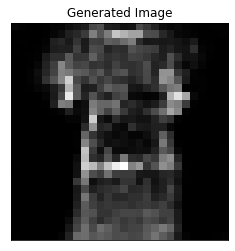

Iteration [8001/10000]......0.120(s) gen: 1.45543 - critic_fake: -0.89960 - critic_real: 4.53917 - neg_critic: 5.43878
Iteration [8002/10000]......0.112(s) gen: 1.46673 - critic_fake: -0.97829 - critic_real: 4.23595 - neg_critic: 5.21424
Iteration [8003/10000]......0.114(s) gen: 1.23405 - critic_fake: -1.19515 - critic_real: 3.86480 - neg_critic: 5.05995
Iteration [8004/10000]......0.114(s) gen: 1.07925 - critic_fake: -1.19936 - critic_real: 3.84665 - neg_critic: 5.04601
Iteration [8005/10000]......0.114(s) gen: 1.36653 - critic_fake: -0.85479 - critic_real: 4.16770 - neg_critic: 5.02250
Iteration [8006/10000]......0.112(s) gen: 1.58320 - critic_fake: -1.42417 - critic_real: 3.80409 - neg_critic: 5.22826
Iteration [8007/10000]......0.113(s) gen: 1.63058 - critic_fake: -1.36983 - critic_real: 3.75084 - neg_critic: 5.12066
Iteration [8008/10000]......0.113(s) gen: 0.95920 - critic_fake: -1.17730 - critic_real: 3.79709 - neg_critic: 4.97439
Iteration [8009/10000]......0.115(s) gen: 1.9567

Iteration [8070/10000]......0.119(s) gen: 0.35286 - critic_fake: -0.11404 - critic_real: 5.59597 - neg_critic: 5.71000
Iteration [8071/10000]......0.119(s) gen: 1.05296 - critic_fake: -0.37691 - critic_real: 4.99846 - neg_critic: 5.37537
Iteration [8072/10000]......0.119(s) gen: 0.93253 - critic_fake: -0.66868 - critic_real: 4.22452 - neg_critic: 4.89320
Iteration [8073/10000]......0.117(s) gen: 0.86612 - critic_fake: -0.81270 - critic_real: 4.29938 - neg_critic: 5.11208
Iteration [8074/10000]......0.117(s) gen: -0.12123 - critic_fake: -0.45246 - critic_real: 4.90390 - neg_critic: 5.35636
Iteration [8075/10000]......0.117(s) gen: 0.45136 - critic_fake: -0.46922 - critic_real: 4.49007 - neg_critic: 4.95929
Iteration [8076/10000]......0.118(s) gen: 0.60079 - critic_fake: -0.31678 - critic_real: 4.61620 - neg_critic: 4.93298
Iteration [8077/10000]......0.119(s) gen: -0.23056 - critic_fake: -0.09220 - critic_real: 5.52600 - neg_critic: 5.61820
Iteration [8078/10000]......0.120(s) gen: 0.98

Iteration [8139/10000]......0.117(s) gen: 0.66914 - critic_fake: -0.86261 - critic_real: 3.97727 - neg_critic: 4.83988
Iteration [8140/10000]......0.118(s) gen: 0.07872 - critic_fake: -0.80324 - critic_real: 4.42909 - neg_critic: 5.23233
Iteration [8141/10000]......0.120(s) gen: 0.18788 - critic_fake: -0.87309 - critic_real: 4.74908 - neg_critic: 5.62217
Iteration [8142/10000]......0.120(s) gen: 0.48515 - critic_fake: -0.45871 - critic_real: 4.74109 - neg_critic: 5.19981
Iteration [8143/10000]......0.120(s) gen: 1.62489 - critic_fake: -0.71198 - critic_real: 4.90826 - neg_critic: 5.62024
Iteration [8144/10000]......0.120(s) gen: 0.36219 - critic_fake: -1.43686 - critic_real: 4.39857 - neg_critic: 5.83543
Iteration [8145/10000]......0.120(s) gen: 1.28757 - critic_fake: -1.22932 - critic_real: 4.40194 - neg_critic: 5.63125
Iteration [8146/10000]......0.120(s) gen: 1.15576 - critic_fake: -1.15363 - critic_real: 4.31428 - neg_critic: 5.46791
Iteration [8147/10000]......0.121(s) gen: 0.8658

Iteration [8208/10000]......0.118(s) gen: 1.05687 - critic_fake: -1.58126 - critic_real: 4.15487 - neg_critic: 5.73614
Iteration [8209/10000]......0.117(s) gen: 0.82228 - critic_fake: -1.03222 - critic_real: 4.21892 - neg_critic: 5.25114
Iteration [8210/10000]......0.118(s) gen: 0.75589 - critic_fake: -0.60752 - critic_real: 4.36963 - neg_critic: 4.97715
Iteration [8211/10000]......0.118(s) gen: 0.31146 - critic_fake: -0.95766 - critic_real: 4.32801 - neg_critic: 5.28567
Iteration [8212/10000]......0.120(s) gen: 0.82090 - critic_fake: -0.24988 - critic_real: 4.76450 - neg_critic: 5.01439
Iteration [8213/10000]......0.120(s) gen: 1.15602 - critic_fake: -1.04036 - critic_real: 3.96952 - neg_critic: 5.00988
Iteration [8214/10000]......0.119(s) gen: 0.71144 - critic_fake: -0.82563 - critic_real: 3.98366 - neg_critic: 4.80929
Iteration [8215/10000]......0.117(s) gen: 0.72465 - critic_fake: -0.62281 - critic_real: 4.26746 - neg_critic: 4.89027
Iteration [8216/10000]......0.116(s) gen: 0.2077

Iteration [8277/10000]......0.116(s) gen: 0.90707 - critic_fake: -0.85684 - critic_real: 4.40166 - neg_critic: 5.25850
Iteration [8278/10000]......0.118(s) gen: 0.51881 - critic_fake: -0.46951 - critic_real: 4.60599 - neg_critic: 5.07550
Iteration [8279/10000]......0.118(s) gen: 0.72945 - critic_fake: -0.29860 - critic_real: 4.88409 - neg_critic: 5.18268
Iteration [8280/10000]......0.117(s) gen: 0.60319 - critic_fake: -0.66639 - critic_real: 4.65014 - neg_critic: 5.31653
Iteration [8281/10000]......0.116(s) gen: 1.30616 - critic_fake: -0.61076 - critic_real: 4.29804 - neg_critic: 4.90880
Iteration [8282/10000]......0.117(s) gen: 1.26800 - critic_fake: -1.08126 - critic_real: 4.19536 - neg_critic: 5.27662
Iteration [8283/10000]......0.118(s) gen: 1.51498 - critic_fake: -1.43912 - critic_real: 4.17133 - neg_critic: 5.61045
Iteration [8284/10000]......0.118(s) gen: 0.80528 - critic_fake: -0.88780 - critic_real: 4.48947 - neg_critic: 5.37728
Iteration [8285/10000]......0.117(s) gen: 0.9884

Iteration [8346/10000]......0.117(s) gen: 0.34606 - critic_fake: -0.81828 - critic_real: 4.33490 - neg_critic: 5.15318
Iteration [8347/10000]......0.117(s) gen: 0.52028 - critic_fake: -0.51211 - critic_real: 4.21126 - neg_critic: 4.72337
Iteration [8348/10000]......0.116(s) gen: -0.49427 - critic_fake: -0.28261 - critic_real: 4.61969 - neg_critic: 4.90229
Iteration [8349/10000]......0.117(s) gen: 0.01542 - critic_fake: -0.20709 - critic_real: 5.15558 - neg_critic: 5.36267
Iteration [8350/10000]......0.118(s) gen: 1.03780 - critic_fake: 0.00845 - critic_real: 5.14982 - neg_critic: 5.14137
Iteration [8351/10000]......0.117(s) gen: 0.76697 - critic_fake: -0.53910 - critic_real: 4.37222 - neg_critic: 4.91132
Iteration [8352/10000]......0.118(s) gen: 0.85811 - critic_fake: -0.47877 - critic_real: 4.11082 - neg_critic: 4.58958
Iteration [8353/10000]......0.118(s) gen: 0.30628 - critic_fake: -0.75892 - critic_real: 4.48902 - neg_critic: 5.24795
Iteration [8354/10000]......0.117(s) gen: 0.2393

Iteration [8415/10000]......0.117(s) gen: 0.50350 - critic_fake: -0.47208 - critic_real: 4.51038 - neg_critic: 4.98246
Iteration [8416/10000]......0.117(s) gen: 0.13894 - critic_fake: -0.50817 - critic_real: 4.01070 - neg_critic: 4.51887
Iteration [8417/10000]......0.117(s) gen: 1.27166 - critic_fake: -0.53313 - critic_real: 4.12211 - neg_critic: 4.65525
Iteration [8418/10000]......0.118(s) gen: 1.62744 - critic_fake: -1.07250 - critic_real: 4.55343 - neg_critic: 5.62594
Iteration [8419/10000]......0.119(s) gen: 1.31748 - critic_fake: -1.26944 - critic_real: 3.68259 - neg_critic: 4.95203
Iteration [8420/10000]......0.120(s) gen: 0.66670 - critic_fake: -0.97508 - critic_real: 4.34728 - neg_critic: 5.32236
Iteration [8421/10000]......0.120(s) gen: 1.18734 - critic_fake: -0.85006 - critic_real: 4.57444 - neg_critic: 5.42450
Iteration [8422/10000]......0.120(s) gen: 1.10044 - critic_fake: -1.21787 - critic_real: 3.97556 - neg_critic: 5.19343
Iteration [8423/10000]......0.121(s) gen: 1.3612

Iteration [8484/10000]......0.118(s) gen: 0.60015 - critic_fake: 0.02276 - critic_real: 4.85099 - neg_critic: 4.82823
Iteration [8485/10000]......0.118(s) gen: 0.85109 - critic_fake: -0.85015 - critic_real: 4.14320 - neg_critic: 4.99335
Iteration [8486/10000]......0.118(s) gen: 0.87130 - critic_fake: -0.36976 - critic_real: 4.66685 - neg_critic: 5.03661
Iteration [8487/10000]......0.119(s) gen: 1.13159 - critic_fake: -1.04092 - critic_real: 4.59347 - neg_critic: 5.63438
Iteration [8488/10000]......0.119(s) gen: 0.56557 - critic_fake: -0.66953 - critic_real: 4.23137 - neg_critic: 4.90090
Iteration [8489/10000]......0.121(s) gen: 0.73190 - critic_fake: -0.97024 - critic_real: 4.56261 - neg_critic: 5.53285
Iteration [8490/10000]......0.119(s) gen: 0.53139 - critic_fake: -0.40360 - critic_real: 4.82099 - neg_critic: 5.22460
Iteration [8491/10000]......0.120(s) gen: 0.99498 - critic_fake: -0.62981 - critic_real: 4.51563 - neg_critic: 5.14544
Iteration [8492/10000]......0.119(s) gen: 0.66884

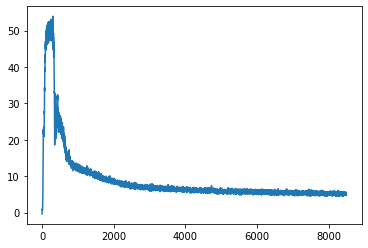

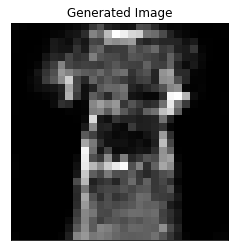

Iteration [8501/10000]......0.119(s) gen: 0.81686 - critic_fake: -0.45693 - critic_real: 4.78329 - neg_critic: 5.24022
Iteration [8502/10000]......0.115(s) gen: 0.09822 - critic_fake: -0.08061 - critic_real: 5.31872 - neg_critic: 5.39933
Iteration [8503/10000]......0.113(s) gen: 0.54619 - critic_fake: -0.46926 - critic_real: 4.16579 - neg_critic: 4.63505
Iteration [8504/10000]......0.114(s) gen: 0.66531 - critic_fake: -0.53313 - critic_real: 5.19041 - neg_critic: 5.72354
Iteration [8505/10000]......0.113(s) gen: 0.58612 - critic_fake: -0.69737 - critic_real: 4.38706 - neg_critic: 5.08442
Iteration [8506/10000]......0.114(s) gen: 0.52397 - critic_fake: -0.96786 - critic_real: 5.29218 - neg_critic: 6.26004
Iteration [8507/10000]......0.115(s) gen: 0.23861 - critic_fake: -0.40052 - critic_real: 4.92901 - neg_critic: 5.32952
Iteration [8508/10000]......0.116(s) gen: 0.46443 - critic_fake: -0.09634 - critic_real: 4.71689 - neg_critic: 4.81323
Iteration [8509/10000]......0.117(s) gen: 0.0199

Iteration [8570/10000]......0.122(s) gen: 0.16973 - critic_fake: -0.39220 - critic_real: 5.31541 - neg_critic: 5.70761
Iteration [8571/10000]......0.121(s) gen: 0.45655 - critic_fake: -0.60717 - critic_real: 4.96571 - neg_critic: 5.57288
Iteration [8572/10000]......0.121(s) gen: 0.98811 - critic_fake: -0.76260 - critic_real: 4.97264 - neg_critic: 5.73524
Iteration [8573/10000]......0.120(s) gen: 0.87698 - critic_fake: -0.71078 - critic_real: 4.62510 - neg_critic: 5.33588
Iteration [8574/10000]......0.120(s) gen: 0.66805 - critic_fake: -0.83958 - critic_real: 4.31535 - neg_critic: 5.15492
Iteration [8575/10000]......0.119(s) gen: 0.24970 - critic_fake: -0.61749 - critic_real: 4.44757 - neg_critic: 5.06507
Iteration [8576/10000]......0.120(s) gen: 0.40400 - critic_fake: -0.17971 - critic_real: 4.59669 - neg_critic: 4.77640
Iteration [8577/10000]......0.118(s) gen: 0.75562 - critic_fake: -0.51871 - critic_real: 4.53383 - neg_critic: 5.05254
Iteration [8578/10000]......0.117(s) gen: 0.3525

Iteration [8639/10000]......0.119(s) gen: 0.29690 - critic_fake: -0.63022 - critic_real: 4.46051 - neg_critic: 5.09073
Iteration [8640/10000]......0.119(s) gen: 0.82312 - critic_fake: -0.11105 - critic_real: 4.79978 - neg_critic: 4.91082
Iteration [8641/10000]......0.118(s) gen: 0.57438 - critic_fake: -0.22451 - critic_real: 5.10262 - neg_critic: 5.32713
Iteration [8642/10000]......0.117(s) gen: -0.03237 - critic_fake: -0.27473 - critic_real: 4.74679 - neg_critic: 5.02151
Iteration [8643/10000]......0.118(s) gen: 1.03830 - critic_fake: -0.15143 - critic_real: 4.90419 - neg_critic: 5.05562
Iteration [8644/10000]......0.118(s) gen: 1.26820 - critic_fake: -0.67285 - critic_real: 4.31927 - neg_critic: 4.99213
Iteration [8645/10000]......0.117(s) gen: 0.12683 - critic_fake: -0.64532 - critic_real: 4.74292 - neg_critic: 5.38824
Iteration [8646/10000]......0.117(s) gen: 0.49852 - critic_fake: -0.04747 - critic_real: 4.67626 - neg_critic: 4.72374
Iteration [8647/10000]......0.117(s) gen: -0.08

Iteration [8708/10000]......0.118(s) gen: 0.00823 - critic_fake: -0.01736 - critic_real: 5.04652 - neg_critic: 5.06388
Iteration [8709/10000]......0.118(s) gen: 0.46856 - critic_fake: -0.16924 - critic_real: 5.10538 - neg_critic: 5.27462
Iteration [8710/10000]......0.120(s) gen: 0.91523 - critic_fake: -0.65522 - critic_real: 4.52114 - neg_critic: 5.17636
Iteration [8711/10000]......0.119(s) gen: 0.75187 - critic_fake: -0.25256 - critic_real: 4.35387 - neg_critic: 4.60643
Iteration [8712/10000]......0.120(s) gen: 0.15047 - critic_fake: -0.43687 - critic_real: 5.02861 - neg_critic: 5.46548
Iteration [8713/10000]......0.118(s) gen: 0.60506 - critic_fake: -0.07126 - critic_real: 5.11387 - neg_critic: 5.18513
Iteration [8714/10000]......0.118(s) gen: 0.76951 - critic_fake: -0.15215 - critic_real: 4.79946 - neg_critic: 4.95162
Iteration [8715/10000]......0.118(s) gen: 0.81098 - critic_fake: -0.36486 - critic_real: 4.55184 - neg_critic: 4.91670
Iteration [8716/10000]......0.118(s) gen: 0.7786

Iteration [8777/10000]......0.119(s) gen: -0.05778 - critic_fake: -0.23219 - critic_real: 4.37290 - neg_critic: 4.60508
Iteration [8778/10000]......0.120(s) gen: 0.21218 - critic_fake: -0.39593 - critic_real: 4.89528 - neg_critic: 5.29121
Iteration [8779/10000]......0.120(s) gen: 0.25969 - critic_fake: 0.02295 - critic_real: 5.13611 - neg_critic: 5.11316
Iteration [8780/10000]......0.120(s) gen: -0.44435 - critic_fake: -0.24234 - critic_real: 4.83517 - neg_critic: 5.07751
Iteration [8781/10000]......0.117(s) gen: -0.26945 - critic_fake: -0.16542 - critic_real: 4.81996 - neg_critic: 4.98538
Iteration [8782/10000]......0.116(s) gen: -0.51440 - critic_fake: 0.02609 - critic_real: 5.24308 - neg_critic: 5.21699
Iteration [8783/10000]......0.119(s) gen: 0.52126 - critic_fake: 0.21012 - critic_real: 5.05945 - neg_critic: 4.84933
Iteration [8784/10000]......0.116(s) gen: 0.25770 - critic_fake: -0.52341 - critic_real: 4.82156 - neg_critic: 5.34497
Iteration [8785/10000]......0.117(s) gen: 0.249

Iteration [8846/10000]......0.116(s) gen: 1.00833 - critic_fake: -0.62809 - critic_real: 4.74490 - neg_critic: 5.37300
Iteration [8847/10000]......0.117(s) gen: 0.24698 - critic_fake: -0.29064 - critic_real: 4.63576 - neg_critic: 4.92640
Iteration [8848/10000]......0.116(s) gen: 0.40494 - critic_fake: -0.53853 - critic_real: 4.67318 - neg_critic: 5.21171
Iteration [8849/10000]......0.118(s) gen: 0.68311 - critic_fake: -0.59929 - critic_real: 4.30796 - neg_critic: 4.90725
Iteration [8850/10000]......0.116(s) gen: 0.56300 - critic_fake: -0.30652 - critic_real: 4.29986 - neg_critic: 4.60639
Iteration [8851/10000]......0.117(s) gen: 0.31730 - critic_fake: -0.74231 - critic_real: 4.50775 - neg_critic: 5.25006
Iteration [8852/10000]......0.118(s) gen: 1.05350 - critic_fake: -0.33295 - critic_real: 4.25734 - neg_critic: 4.59029
Iteration [8853/10000]......0.118(s) gen: 0.24040 - critic_fake: -0.87318 - critic_real: 4.49506 - neg_critic: 5.36824
Iteration [8854/10000]......0.117(s) gen: 0.6540

Iteration [8915/10000]......0.118(s) gen: -0.28533 - critic_fake: 0.73876 - critic_real: 5.57003 - neg_critic: 4.83127
Iteration [8916/10000]......0.116(s) gen: -0.03758 - critic_fake: 0.34993 - critic_real: 5.13817 - neg_critic: 4.78824
Iteration [8917/10000]......0.117(s) gen: 0.29185 - critic_fake: 0.10631 - critic_real: 4.99604 - neg_critic: 4.88973
Iteration [8918/10000]......0.117(s) gen: -0.25633 - critic_fake: 0.17856 - critic_real: 4.75958 - neg_critic: 4.58102
Iteration [8919/10000]......0.116(s) gen: 0.12951 - critic_fake: 0.52492 - critic_real: 5.74677 - neg_critic: 5.22184
Iteration [8920/10000]......0.117(s) gen: 0.09846 - critic_fake: 0.17666 - critic_real: 5.21306 - neg_critic: 5.03641
Iteration [8921/10000]......0.118(s) gen: 0.33501 - critic_fake: 0.11925 - critic_real: 5.15078 - neg_critic: 5.03154
Iteration [8922/10000]......0.118(s) gen: -0.07122 - critic_fake: 0.25939 - critic_real: 5.03152 - neg_critic: 4.77213
Iteration [8923/10000]......0.118(s) gen: 0.88321 - 

Iteration [8984/10000]......0.118(s) gen: 0.20733 - critic_fake: -0.44457 - critic_real: 4.17560 - neg_critic: 4.62017
Iteration [8985/10000]......0.120(s) gen: 0.53155 - critic_fake: -0.20819 - critic_real: 4.91736 - neg_critic: 5.12555
Iteration [8986/10000]......0.117(s) gen: 0.66403 - critic_fake: -0.54581 - critic_real: 4.59644 - neg_critic: 5.14225
Iteration [8987/10000]......0.118(s) gen: 0.57940 - critic_fake: -0.50383 - critic_real: 4.56682 - neg_critic: 5.07064
Iteration [8988/10000]......0.119(s) gen: 0.20399 - critic_fake: -0.24644 - critic_real: 4.73351 - neg_critic: 4.97995
Iteration [8989/10000]......0.121(s) gen: 0.88290 - critic_fake: -0.20675 - critic_real: 4.98092 - neg_critic: 5.18767
Iteration [8990/10000]......0.119(s) gen: 0.17927 - critic_fake: -0.32490 - critic_real: 5.07254 - neg_critic: 5.39744
Iteration [8991/10000]......0.119(s) gen: 0.04002 - critic_fake: -0.46548 - critic_real: 4.87572 - neg_critic: 5.34120
Iteration [8992/10000]......0.119(s) gen: 0.2522

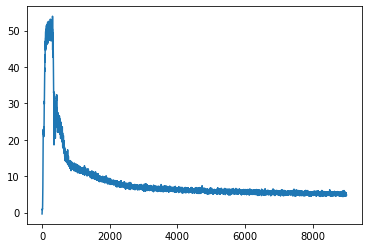

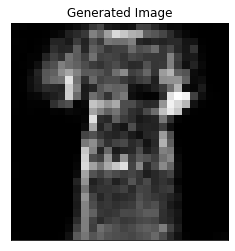

Iteration [9001/10000]......0.115(s) gen: -0.32640 - critic_fake: 0.01053 - critic_real: 4.87559 - neg_critic: 4.86506
Iteration [9002/10000]......0.111(s) gen: 0.20630 - critic_fake: 0.18987 - critic_real: 4.52206 - neg_critic: 4.33218
Iteration [9003/10000]......0.113(s) gen: -0.59832 - critic_fake: 0.09016 - critic_real: 4.66808 - neg_critic: 4.57791
Iteration [9004/10000]......0.112(s) gen: -0.26224 - critic_fake: -0.30681 - critic_real: 5.43845 - neg_critic: 5.74526
Iteration [9005/10000]......0.113(s) gen: -1.03422 - critic_fake: 0.41402 - critic_real: 5.61674 - neg_critic: 5.20272
Iteration [9006/10000]......0.113(s) gen: -0.05552 - critic_fake: 0.38857 - critic_real: 5.74042 - neg_critic: 5.35185
Iteration [9007/10000]......0.112(s) gen: -0.46143 - critic_fake: 0.38421 - critic_real: 5.12333 - neg_critic: 4.73912
Iteration [9008/10000]......0.113(s) gen: -0.36930 - critic_fake: 0.77227 - critic_real: 5.75884 - neg_critic: 4.98657
Iteration [9009/10000]......0.114(s) gen: -0.711

Iteration [9070/10000]......0.117(s) gen: 0.80870 - critic_fake: -0.06708 - critic_real: 4.89773 - neg_critic: 4.96482
Iteration [9071/10000]......0.116(s) gen: 0.36424 - critic_fake: -0.00572 - critic_real: 5.17347 - neg_critic: 5.17919
Iteration [9072/10000]......0.115(s) gen: 0.77824 - critic_fake: -0.23615 - critic_real: 4.67853 - neg_critic: 4.91468
Iteration [9073/10000]......0.114(s) gen: 0.17048 - critic_fake: -0.11960 - critic_real: 4.97915 - neg_critic: 5.09874
Iteration [9074/10000]......0.117(s) gen: -0.26007 - critic_fake: 0.02679 - critic_real: 4.81791 - neg_critic: 4.79113
Iteration [9075/10000]......0.117(s) gen: 0.37368 - critic_fake: 0.14269 - critic_real: 5.06310 - neg_critic: 4.92041
Iteration [9076/10000]......0.118(s) gen: -0.16194 - critic_fake: -0.05626 - critic_real: 5.22461 - neg_critic: 5.28087
Iteration [9077/10000]......0.117(s) gen: -0.28474 - critic_fake: 0.12825 - critic_real: 5.23704 - neg_critic: 5.10879
Iteration [9078/10000]......0.119(s) gen: -1.020

Iteration [9139/10000]......0.119(s) gen: 0.22633 - critic_fake: 0.36607 - critic_real: 4.96962 - neg_critic: 4.60355
Iteration [9140/10000]......0.120(s) gen: 0.59554 - critic_fake: -0.30641 - critic_real: 4.53934 - neg_critic: 4.84575
Iteration [9141/10000]......0.119(s) gen: 0.15712 - critic_fake: -0.59032 - critic_real: 4.89807 - neg_critic: 5.48839
Iteration [9142/10000]......0.117(s) gen: 0.09770 - critic_fake: -0.17702 - critic_real: 4.88616 - neg_critic: 5.06318
Iteration [9143/10000]......0.117(s) gen: -0.05588 - critic_fake: 0.42663 - critic_real: 5.15067 - neg_critic: 4.72404
Iteration [9144/10000]......0.116(s) gen: 0.52406 - critic_fake: -0.13387 - critic_real: 4.97539 - neg_critic: 5.10926
Iteration [9145/10000]......0.116(s) gen: -0.11057 - critic_fake: 0.00231 - critic_real: 5.21208 - neg_critic: 5.20978
Iteration [9146/10000]......0.116(s) gen: -0.82178 - critic_fake: 0.18946 - critic_real: 5.27452 - neg_critic: 5.08505
Iteration [9147/10000]......0.116(s) gen: -0.9239

Iteration [9208/10000]......0.116(s) gen: 0.35817 - critic_fake: -0.24708 - critic_real: 4.93691 - neg_critic: 5.18399
Iteration [9209/10000]......0.117(s) gen: -0.02602 - critic_fake: -0.04131 - critic_real: 5.04140 - neg_critic: 5.08271
Iteration [9210/10000]......0.117(s) gen: -0.08564 - critic_fake: 0.00145 - critic_real: 5.02777 - neg_critic: 5.02632
Iteration [9211/10000]......0.116(s) gen: 0.17544 - critic_fake: 0.22454 - critic_real: 5.09011 - neg_critic: 4.86557
Iteration [9212/10000]......0.116(s) gen: -0.58221 - critic_fake: 0.22016 - critic_real: 5.34909 - neg_critic: 5.12892
Iteration [9213/10000]......0.116(s) gen: -0.38122 - critic_fake: 0.64009 - critic_real: 5.63976 - neg_critic: 4.99967
Iteration [9214/10000]......0.117(s) gen: -0.54213 - critic_fake: 0.81898 - critic_real: 5.24733 - neg_critic: 4.42834
Iteration [9215/10000]......0.117(s) gen: -0.13323 - critic_fake: 0.45149 - critic_real: 5.47609 - neg_critic: 5.02460
Iteration [9216/10000]......0.118(s) gen: 0.2565

Iteration [9277/10000]......0.118(s) gen: 0.53617 - critic_fake: -0.10429 - critic_real: 4.79538 - neg_critic: 4.89967
Iteration [9278/10000]......0.118(s) gen: 0.24540 - critic_fake: 0.18848 - critic_real: 5.03894 - neg_critic: 4.85045
Iteration [9279/10000]......0.119(s) gen: 0.28843 - critic_fake: -0.24846 - critic_real: 5.08231 - neg_critic: 5.33077
Iteration [9280/10000]......0.119(s) gen: 0.17466 - critic_fake: 0.01706 - critic_real: 4.82490 - neg_critic: 4.80784
Iteration [9281/10000]......0.120(s) gen: 0.38975 - critic_fake: 0.06473 - critic_real: 5.10505 - neg_critic: 5.04032
Iteration [9282/10000]......0.121(s) gen: -0.12623 - critic_fake: 0.13842 - critic_real: 4.97083 - neg_critic: 4.83241
Iteration [9283/10000]......0.123(s) gen: 0.61044 - critic_fake: -0.25722 - critic_real: 5.06358 - neg_critic: 5.32080
Iteration [9284/10000]......0.121(s) gen: -0.02642 - critic_fake: 0.16060 - critic_real: 5.46818 - neg_critic: 5.30759
Iteration [9285/10000]......0.119(s) gen: -0.30026 

Iteration [9346/10000]......0.120(s) gen: -0.44511 - critic_fake: 0.44905 - critic_real: 5.17223 - neg_critic: 4.72317
Iteration [9347/10000]......0.120(s) gen: -0.51490 - critic_fake: 0.41328 - critic_real: 5.58601 - neg_critic: 5.17273
Iteration [9348/10000]......0.119(s) gen: 0.70536 - critic_fake: 0.04196 - critic_real: 5.12276 - neg_critic: 5.08080
Iteration [9349/10000]......0.119(s) gen: 0.50519 - critic_fake: -0.13456 - critic_real: 5.20344 - neg_critic: 5.33800
Iteration [9350/10000]......0.118(s) gen: -0.24354 - critic_fake: 0.23247 - critic_real: 4.70739 - neg_critic: 4.47492
Iteration [9351/10000]......0.117(s) gen: -0.14403 - critic_fake: 0.43138 - critic_real: 5.22674 - neg_critic: 4.79537
Iteration [9352/10000]......0.116(s) gen: 0.35599 - critic_fake: -0.32938 - critic_real: 5.15039 - neg_critic: 5.47978
Iteration [9353/10000]......0.117(s) gen: -0.05005 - critic_fake: 0.29638 - critic_real: 5.00248 - neg_critic: 4.70610
Iteration [9354/10000]......0.117(s) gen: -0.2870

Iteration [9415/10000]......0.116(s) gen: 0.27030 - critic_fake: 0.45261 - critic_real: 5.37304 - neg_critic: 4.92043
Iteration [9416/10000]......0.118(s) gen: -0.15891 - critic_fake: 0.19937 - critic_real: 4.97634 - neg_critic: 4.77698
Iteration [9417/10000]......0.118(s) gen: 0.70412 - critic_fake: -0.25755 - critic_real: 5.27527 - neg_critic: 5.53282
Iteration [9418/10000]......0.119(s) gen: 0.23118 - critic_fake: -0.23276 - critic_real: 5.16757 - neg_critic: 5.40033
Iteration [9419/10000]......0.119(s) gen: -0.77631 - critic_fake: 0.21103 - critic_real: 5.48863 - neg_critic: 5.27761
Iteration [9420/10000]......0.120(s) gen: -0.42716 - critic_fake: 0.42044 - critic_real: 5.59406 - neg_critic: 5.17362
Iteration [9421/10000]......0.120(s) gen: -0.68961 - critic_fake: 1.33091 - critic_real: 5.75778 - neg_critic: 4.42688
Iteration [9422/10000]......0.116(s) gen: 0.48934 - critic_fake: 0.48166 - critic_real: 5.39333 - neg_critic: 4.91167
Iteration [9423/10000]......0.117(s) gen: -0.35302

Iteration [9484/10000]......0.119(s) gen: -0.33842 - critic_fake: 0.50880 - critic_real: 5.05648 - neg_critic: 4.54769
Iteration [9485/10000]......0.118(s) gen: -0.23004 - critic_fake: 0.07298 - critic_real: 5.23928 - neg_critic: 5.16630
Iteration [9486/10000]......0.118(s) gen: -0.71224 - critic_fake: 0.05068 - critic_real: 5.32629 - neg_critic: 5.27562
Iteration [9487/10000]......0.118(s) gen: 0.02426 - critic_fake: 0.45242 - critic_real: 5.53885 - neg_critic: 5.08643
Iteration [9488/10000]......0.116(s) gen: -0.00668 - critic_fake: -0.12284 - critic_real: 4.87681 - neg_critic: 4.99966
Iteration [9489/10000]......0.116(s) gen: 0.07715 - critic_fake: 0.20499 - critic_real: 5.31139 - neg_critic: 5.10640
Iteration [9490/10000]......0.115(s) gen: -0.04588 - critic_fake: -0.30613 - critic_real: 5.05593 - neg_critic: 5.36207
Iteration [9491/10000]......0.117(s) gen: 0.64373 - critic_fake: -0.04183 - critic_real: 5.07854 - neg_critic: 5.12037
Iteration [9492/10000]......0.118(s) gen: -0.207

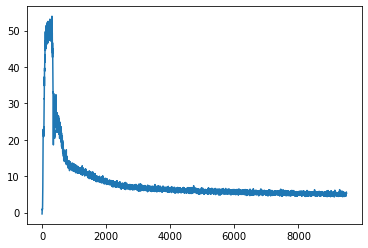

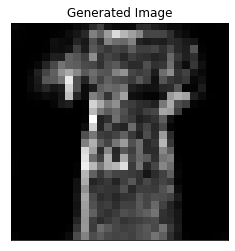

Iteration [9501/10000]......0.116(s) gen: -0.38094 - critic_fake: 0.25116 - critic_real: 5.25830 - neg_critic: 5.00713
Iteration [9502/10000]......0.114(s) gen: 0.01844 - critic_fake: 0.16743 - critic_real: 5.43095 - neg_critic: 5.26352
Iteration [9503/10000]......0.115(s) gen: 0.15842 - critic_fake: 0.15463 - critic_real: 5.23794 - neg_critic: 5.08331
Iteration [9504/10000]......0.117(s) gen: 0.25745 - critic_fake: -0.07620 - critic_real: 5.11718 - neg_critic: 5.19338
Iteration [9505/10000]......0.118(s) gen: 0.13694 - critic_fake: 0.28670 - critic_real: 5.03290 - neg_critic: 4.74620
Iteration [9506/10000]......0.119(s) gen: 0.14512 - critic_fake: 0.14337 - critic_real: 4.74745 - neg_critic: 4.60409
Iteration [9507/10000]......0.118(s) gen: 0.49447 - critic_fake: 0.15557 - critic_real: 4.76768 - neg_critic: 4.61211
Iteration [9508/10000]......0.117(s) gen: -0.12936 - critic_fake: -0.06268 - critic_real: 4.92003 - neg_critic: 4.98271
Iteration [9509/10000]......0.119(s) gen: 0.01217 - 

Iteration [9570/10000]......0.118(s) gen: -0.28756 - critic_fake: 0.66999 - critic_real: 4.82964 - neg_critic: 4.15965
Iteration [9571/10000]......0.117(s) gen: -0.92096 - critic_fake: 0.09086 - critic_real: 5.45333 - neg_critic: 5.36247
Iteration [9572/10000]......0.116(s) gen: -0.00728 - critic_fake: 0.13388 - critic_real: 5.23831 - neg_critic: 5.10443
Iteration [9573/10000]......0.117(s) gen: 0.72460 - critic_fake: -0.04996 - critic_real: 4.82750 - neg_critic: 4.87746
Iteration [9574/10000]......0.116(s) gen: 0.37631 - critic_fake: -0.43476 - critic_real: 4.54653 - neg_critic: 4.98129
Iteration [9575/10000]......0.118(s) gen: 0.71824 - critic_fake: -0.15603 - critic_real: 5.24672 - neg_critic: 5.40276
Iteration [9576/10000]......0.117(s) gen: -0.01842 - critic_fake: -0.01160 - critic_real: 5.00596 - neg_critic: 5.01757
Iteration [9577/10000]......0.119(s) gen: -0.21403 - critic_fake: -0.21209 - critic_real: 5.04009 - neg_critic: 5.25217
Iteration [9578/10000]......0.120(s) gen: 0.64

Iteration [9639/10000]......0.120(s) gen: -0.10740 - critic_fake: 0.19112 - critic_real: 5.19141 - neg_critic: 5.00029
Iteration [9640/10000]......0.120(s) gen: 0.33298 - critic_fake: 0.02085 - critic_real: 4.85768 - neg_critic: 4.83683
Iteration [9641/10000]......0.122(s) gen: 0.52608 - critic_fake: -0.37555 - critic_real: 4.40927 - neg_critic: 4.78482
Iteration [9642/10000]......0.121(s) gen: 0.23585 - critic_fake: -0.34712 - critic_real: 4.64763 - neg_critic: 4.99475
Iteration [9643/10000]......0.119(s) gen: 0.00591 - critic_fake: -0.12676 - critic_real: 4.79800 - neg_critic: 4.92477
Iteration [9644/10000]......0.118(s) gen: 0.33676 - critic_fake: 0.44602 - critic_real: 4.82598 - neg_critic: 4.37996
Iteration [9645/10000]......0.119(s) gen: -0.05307 - critic_fake: 0.09415 - critic_real: 5.23006 - neg_critic: 5.13592
Iteration [9646/10000]......0.119(s) gen: 0.33257 - critic_fake: 0.10002 - critic_real: 4.82480 - neg_critic: 4.72478
Iteration [9647/10000]......0.119(s) gen: -0.67582 

Iteration [9708/10000]......0.120(s) gen: -0.00992 - critic_fake: -0.18470 - critic_real: 4.36001 - neg_critic: 4.54471
Iteration [9709/10000]......0.120(s) gen: 0.12531 - critic_fake: -0.11685 - critic_real: 4.92209 - neg_critic: 5.03894
Iteration [9710/10000]......0.120(s) gen: 0.72213 - critic_fake: -0.26150 - critic_real: 5.22751 - neg_critic: 5.48901
Iteration [9711/10000]......0.118(s) gen: -0.43336 - critic_fake: -0.01979 - critic_real: 4.90389 - neg_critic: 4.92368
Iteration [9712/10000]......0.118(s) gen: -0.18074 - critic_fake: -0.13389 - critic_real: 5.05506 - neg_critic: 5.18895
Iteration [9713/10000]......0.117(s) gen: -0.14602 - critic_fake: 0.34245 - critic_real: 5.34281 - neg_critic: 5.00036
Iteration [9714/10000]......0.117(s) gen: -0.12985 - critic_fake: -0.01680 - critic_real: 5.17958 - neg_critic: 5.19638
Iteration [9715/10000]......0.117(s) gen: -0.22406 - critic_fake: 0.18188 - critic_real: 5.41936 - neg_critic: 5.23748
Iteration [9716/10000]......0.118(s) gen: 0.

Iteration [9777/10000]......0.118(s) gen: -0.05138 - critic_fake: 0.41223 - critic_real: 5.00238 - neg_critic: 4.59015
Iteration [9778/10000]......0.120(s) gen: 0.38079 - critic_fake: -0.30359 - critic_real: 5.15911 - neg_critic: 5.46271
Iteration [9779/10000]......0.119(s) gen: 0.36110 - critic_fake: -0.25133 - critic_real: 4.88451 - neg_critic: 5.13584
Iteration [9780/10000]......0.121(s) gen: -0.47503 - critic_fake: -0.25993 - critic_real: 4.85603 - neg_critic: 5.11596
Iteration [9781/10000]......0.121(s) gen: -0.29129 - critic_fake: 0.11758 - critic_real: 5.26445 - neg_critic: 5.14686
Iteration [9782/10000]......0.120(s) gen: -0.04849 - critic_fake: 0.04280 - critic_real: 5.02906 - neg_critic: 4.98626
Iteration [9783/10000]......0.122(s) gen: 0.19072 - critic_fake: -0.12407 - critic_real: 4.93419 - neg_critic: 5.05825
Iteration [9784/10000]......0.119(s) gen: 0.06924 - critic_fake: -0.25859 - critic_real: 4.71879 - neg_critic: 4.97738
Iteration [9785/10000]......0.120(s) gen: -0.06

Iteration [9846/10000]......0.118(s) gen: 0.01955 - critic_fake: 0.24224 - critic_real: 4.81439 - neg_critic: 4.57215
Iteration [9847/10000]......0.119(s) gen: -0.14763 - critic_fake: 0.02484 - critic_real: 4.86633 - neg_critic: 4.84149
Iteration [9848/10000]......0.119(s) gen: -0.24676 - critic_fake: -0.04641 - critic_real: 4.85106 - neg_critic: 4.89747
Iteration [9849/10000]......0.121(s) gen: -0.16755 - critic_fake: -0.17707 - critic_real: 4.76028 - neg_critic: 4.93736
Iteration [9850/10000]......0.121(s) gen: -0.06817 - critic_fake: -0.07926 - critic_real: 4.98310 - neg_critic: 5.06236
Iteration [9851/10000]......0.120(s) gen: 0.13666 - critic_fake: 0.07157 - critic_real: 5.03013 - neg_critic: 4.95856
Iteration [9852/10000]......0.120(s) gen: 0.23128 - critic_fake: 0.18673 - critic_real: 4.73158 - neg_critic: 4.54484
Iteration [9853/10000]......0.122(s) gen: 0.28242 - critic_fake: 0.02891 - critic_real: 4.81903 - neg_critic: 4.79012
Iteration [9854/10000]......0.121(s) gen: 0.20453

Iteration [9915/10000]......0.115(s) gen: 0.02412 - critic_fake: -0.15556 - critic_real: 4.85838 - neg_critic: 5.01394
Iteration [9916/10000]......0.116(s) gen: 0.28712 - critic_fake: -0.14658 - critic_real: 5.17760 - neg_critic: 5.32418
Iteration [9917/10000]......0.116(s) gen: 0.28275 - critic_fake: 0.19375 - critic_real: 4.68237 - neg_critic: 4.48863
Iteration [9918/10000]......0.117(s) gen: 0.85667 - critic_fake: -0.23557 - critic_real: 4.56721 - neg_critic: 4.80278
Iteration [9919/10000]......0.118(s) gen: 0.00835 - critic_fake: -0.08970 - critic_real: 5.07637 - neg_critic: 5.16608
Iteration [9920/10000]......0.118(s) gen: -0.10507 - critic_fake: -0.02180 - critic_real: 4.72069 - neg_critic: 4.74249
Iteration [9921/10000]......0.119(s) gen: -0.25267 - critic_fake: 0.08809 - critic_real: 4.61976 - neg_critic: 4.53167
Iteration [9922/10000]......0.119(s) gen: -0.33141 - critic_fake: 0.30174 - critic_real: 5.01930 - neg_critic: 4.71757
Iteration [9923/10000]......0.118(s) gen: 0.0687

Iteration [9984/10000]......0.117(s) gen: 1.04043 - critic_fake: -0.91663 - critic_real: 4.06863 - neg_critic: 4.98526
Iteration [9985/10000]......0.119(s) gen: 0.20847 - critic_fake: -0.59511 - critic_real: 4.31225 - neg_critic: 4.90736
Iteration [9986/10000]......0.120(s) gen: -0.83176 - critic_fake: 0.10544 - critic_real: 5.25574 - neg_critic: 5.15029
Iteration [9987/10000]......0.119(s) gen: -0.13712 - critic_fake: 0.18894 - critic_real: 5.66821 - neg_critic: 5.47928
Iteration [9988/10000]......0.119(s) gen: -0.05968 - critic_fake: 0.64278 - critic_real: 5.28483 - neg_critic: 4.64205
Iteration [9989/10000]......0.119(s) gen: 0.55172 - critic_fake: 0.09440 - critic_real: 4.80091 - neg_critic: 4.70651
Iteration [9990/10000]......0.120(s) gen: -0.10679 - critic_fake: 0.11670 - critic_real: 4.95372 - neg_critic: 4.83702
Iteration [9991/10000]......0.120(s) gen: 0.47011 - critic_fake: -0.12775 - critic_real: 5.45191 - neg_critic: 5.57967
Iteration [9992/10000]......0.117(s) gen: 1.11450

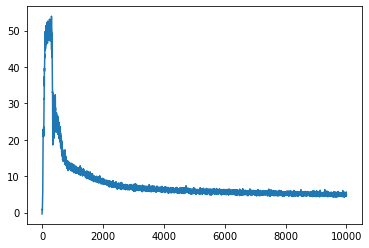

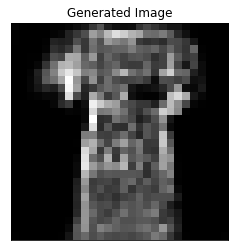

checkpointing at epoch: 10000


In [24]:
import time
from pathlib import Path

start_epoch = 1
epochs = 10000
batch_size = 64
checkpoint_every_n_epochs = 10000
figure_every_n_epochs = 500
n_critic = 5



plt.ioff()

model_type = f'wgan-gp'
data_name = f'fashion-MNIST'


#create base dir
base_model_path = Path(f'./model-data/{model_type}/{data_name}')
base_model_path.mkdir(parents=True, exist_ok=True)

#create figure dir
figure_model_path = base_model_path / 'figures'
figure_model_path.mkdir(parents=True, exist_ok=True)

#create checkpoint dir
checkpoints_model_path = base_model_path / 'checkpoints'
checkpoints_model_path.mkdir(parents=True, exist_ok=True)


with tf.device('gpu:0'):
    
    if start_epoch == 1:
        training_imgs = np.cast['float32'](x_train)
        num_batches = len(training_imgs) // batch_size
        rl_lo_loss_list = [] 
        rl_med_loss_list = [] 
        rl_hi_loss_list = [] 
        kl_loss_list = []
        gen_loss_list = []
        critic_real_list = []
        critic_fake_list = []
        mu, sigma = 0, 1 #mean and standard deviation
        test_noise = np.random.normal(mu, sigma, (1, latent_dim))
    

    rl_lo_loss = 0
    rl_med_loss = 0
    rl_hi_loss = 0
    kl_loss = 0
    gen_loss = 0

    
    for epoch in range(start_epoch,epochs+1):
        start = time.time()
        print(f'Iteration [{epoch}/{epochs}]...'.ljust(20), end = '')
 
        
        
        critic_real_sum = 0
        critic_fake_sum = 0
        for _ in range(n_critic):
            idxs_batch = np.random.randint(0,len(training_imgs)-1,size=batch_size)
            img_batch = training_imgs[idxs_batch]
            critic_real, critic_fake = train_step_critic(img_batch)
            critic_real_sum += K.get_value(critic_real)
            critic_fake_sum += K.get_value(critic_fake)            
        
        
        
        gen_loss = train_step_generator()
        
        
        
        critic_real = critic_real_sum/n_critic
        critic_fake = critic_fake_sum/n_critic
        gen_loss = K.get_value(gen_loss)

        
        
        critic_real_list.append(critic_real)
        critic_fake_list.append(critic_fake)
        gen_loss_list.append(gen_loss)

        
        print(f'...{time.time()-start:.3f}(s) '  , end='')        
        
        print(f'gen: {gen_loss:.5f} - ', end='')
        print(f'critic_fake: {critic_fake:.5f} - ', end='')
        print(f'critic_real: {critic_real:.5f} - ', end='')
        print(f'neg_critic: {critic_real - critic_fake:.5f}')

        

        if epoch % figure_every_n_epochs == 0:
            
            # plot fig for r - f to observe convergence
            negative_critic_loss = np.array(critic_real_list)-np.array(critic_fake_list)
            plt.plot(negative_critic_loss, label="negative_critic")
            plt.show()
            
            gen_img = unnormalize_tanh( generator.predict(test_noise)[0])        
            plt.imshow(gen_img.reshape(28,28), cmap='gray')
            plt.title("Generated Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'generated-{epoch}.png')
            plt.show()


        if epoch % checkpoint_every_n_epochs == 0 and epoch != 0:        
            print(f'checkpointing at epoch: {epoch}')
            generator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator-weights.h5').as_posix())
            generator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator.h5').as_posix())
            critic.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-critic-weights.h5').as_posix())
            critic.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-critic.h5').as_posix())
            

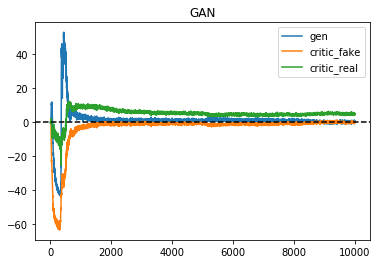

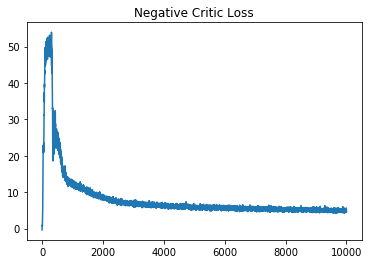

In [26]:
plt.plot(gen_loss_list, label="gen")
plt.plot(critic_fake_list, label="critic_fake")
plt.plot(critic_real_list, label="critic_real")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title("GAN")
plt.savefig(figure_model_path / 'gan.png')
plt.show()

negative_critic_loss = np.array(critic_real_list)-np.array(critic_fake_list)
plt.plot(negative_critic_loss)
plt.title("Negative Critic Loss")
plt.savefig(figure_model_path / 'negative_critic.png')
plt.show()

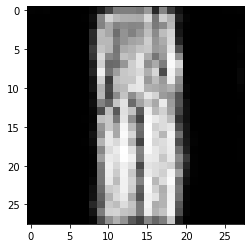

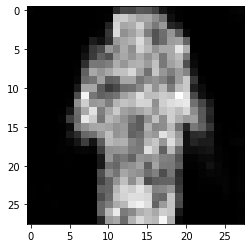

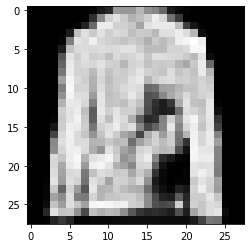

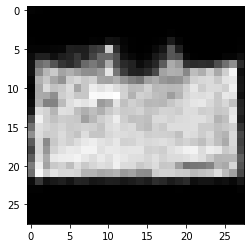

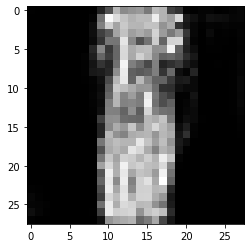

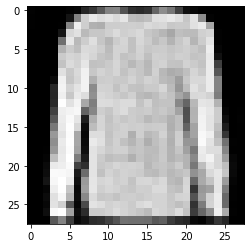

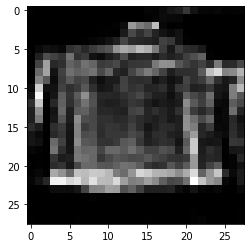

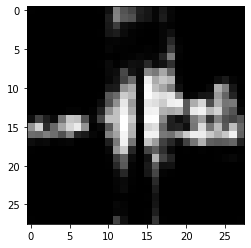

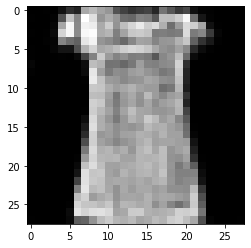

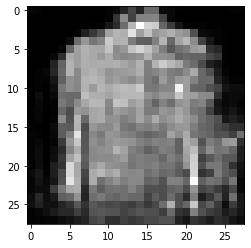

In [25]:
for i in range(10):
    noise = np.random.normal(0,1, (1,100))
    gen_img = unnormalize_tanh( generator.predict(noise)[0])        
    plt.imshow(gen_img.reshape(28,28), cmap='gray')
    plt.show()

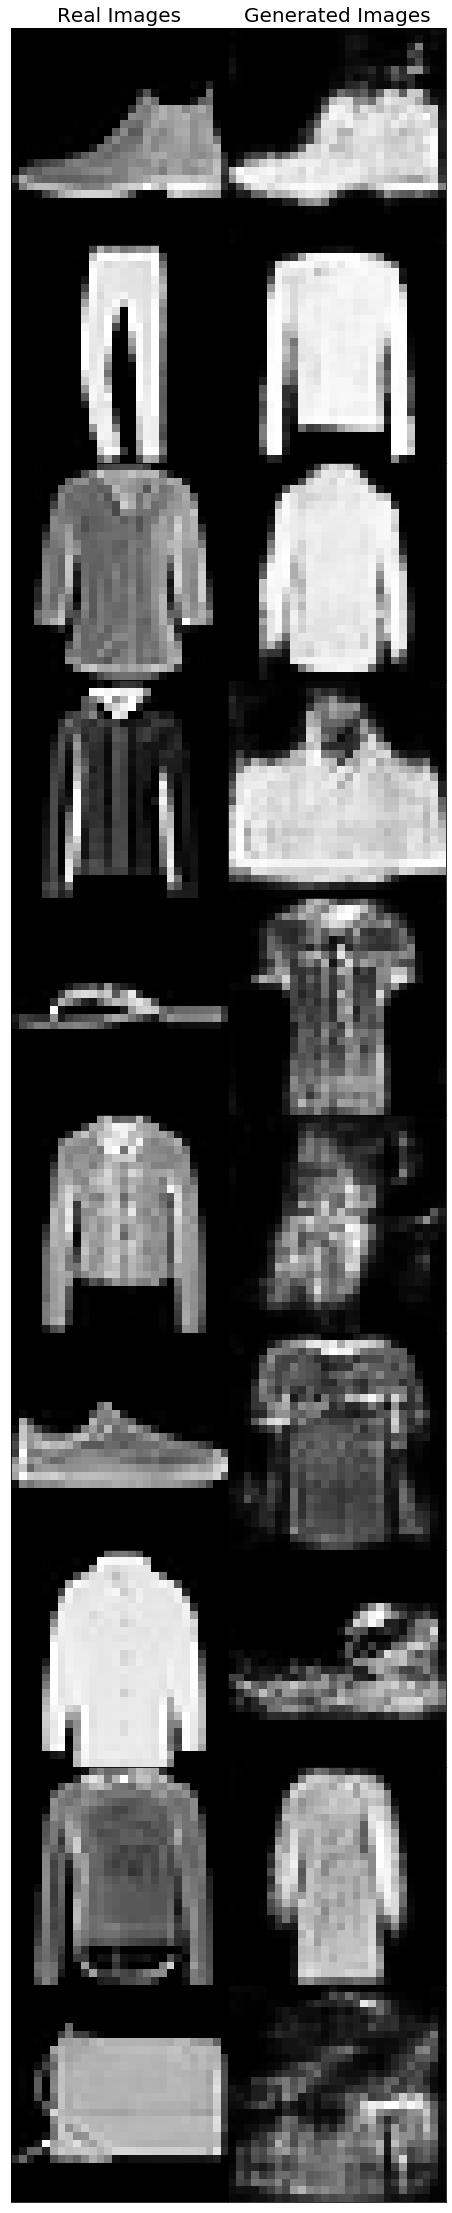

In [31]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(200., 40.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 2),  # creates 2x2 grid of axes
                 axes_pad=0.0,  # pad between axes in inch.
                 )


for i in range(20):
    if i % 2 == 0:
        grid[i].imshow(x_test[i].reshape(28,28), cmap='gray')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
    
    else:
        noise = np.random.normal(0,1, (1,100))
        gen_img = unnormalize_tanh( generator.predict(noise)[0])  
        grid[i].imshow(gen_img.reshape(28,28), cmap='gray')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
grid[0].set_title('Real Images', fontsize=20.)
grid[1].set_title('Generated Images', fontsize=20.)
plt.show()